# Udacity Nanodegree capstone

## Product - Thailand SET stock predictor - 2

Udacity Nanodegree capstone project creating a Thailand stock predictor.
Project is divided in to 3 main notebooks:
1. Data exploration/visualisation/preparation
2. Data training/modelling/optimisation
3. Data review/prediction

Project involves testing with various data sources including:
- Thailand Stock price data
- Google trends interest information
- Covid19 statistics results

Input to this project will be:
- Stock symbol from Thailand SET100 (ie DELTA, KCE, etc.)
- https://marketdata.set.or.th/mkt/sectorquotation.do?sector=SET100&language=en&country=US

Output of this project is a Jupyter notebook with code that create/train/test model to predict SET Thailand stock prices. 

Features engineered:
- Stock open, high, low, close, volume
- Stock MA (moving average)
- Stock EMA (exponentail moving average)
- Stock RSI (relative strength index)
- Foreign SET trade details
- Similar stock ohlc, volume, MA, EMA, RSI by related industry
- Similar stock close price by correlation analysis (within SET100 stocks)
- SET50, SET100 index
- Google trends interest data with keywords [stock symbol, sector name, industry name, top 2 relates queries]
- Covid19 Thailand statistics results

Data processing:
- Granger causality testing - determining whether a lag price on one have an affect on another
- MinMaxScaled data to process
- Inverse scaled data for predicted output
- Train-test dataset for testing and evaluating model performance
- Train-predict dataset for predicting future data

Modelling:
- Linear regression
- Random forest regressor
- Support Vector Maching (SVM) - LinearSVR
- Support Vector Maching (SVM) - SVR (polynomial)
- Gradient boosting regression
- Facebook prophet

Optimisation:
- Manual parameter tuning
- RandomSearch parameter optimisation
- Facebook prophet add regressor optimisation
- Ensemble model optimisation (selective average from models)

Prediction:
- Review final model
- Predict stock closing price based on stocks which have granger causality lag

Please refer to the other attached documentation for setup instructions.

## Data training, modelling, optimisation
This notebook mainly focuses on training, modelling, and optimisation of the data with the said algorithms. 

Main outcome of this notebook is to have an optimised model that can take in SET stock symbol, and output the prediction and test results. For this notebook, we are going to focus on outputting the most optimised model for prediction.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.model_selection import RandomizedSearchCV

import sqlalchemy as db

import pickle
import requests

import starfishX as sx
from pytrends.request import TrendReq
import pandas_ta as pta
from tqdm.notebook import tqdm 
from statsmodels.tsa.stattools import grangercausalitytests
from prophet import Prophet

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

matplotlib.rc('font', family='Ayuthaya')
%matplotlib inline


### Previous SET stock data information
Here, we are going to note the functions that has been used in the previous notebook so that we can run them and generate the required stock information and its features for modelling.

Note, we are going to only scope our input to be the stock from SET100.

In [2]:
def cal_stock_ema(stock_symbol, df_stock_data):
    '''
    Calculate the stock EMA data overtime for the different set periods (Exponential moving average)
    
    Input:
    - stock data (equivalent to CLOSE column of stock data)
    
    Output:
    - Dataframe with the stock price, and EMA with different periods (10, 30, 50)
    
    '''
        
    # Create dataframe for the finalised output EMA data from stock
    ema_data = pd.concat([
                        df_stock_data.ewm(span=10,adjust=False).mean().rename(stock_symbol + '_ema10')
                        ,df_stock_data.ewm(span=30,adjust=False).mean().rename(stock_symbol + '_ema30')
                        ,df_stock_data.ewm(span=50,adjust=False).mean().rename(stock_symbol + '_ema50')
                    ],axis=1)
    
    return ema_data

In [3]:
def cal_stock_ma(stock_symbol, df_stock_data):
    '''
    Calculate the stock MA data overtime for the different set periods (Moving average)
    
    Input:
    - stock data (equivalent to CLOSE column of stock data)
    
    Output:
    - Dataframe with the stock price, and MA with different periods (10, 30, 50, 100)
    
    '''
        
    # Create dataframe for the finalised output MA data from stock
    ma_data = pd.concat([
                        df_stock_data.rolling(10).mean().rename(stock_symbol + '_ma10')
                        ,df_stock_data.rolling(30).mean().rename(stock_symbol + '_ma30')
                        ,df_stock_data.rolling(50).mean().rename(stock_symbol + '_ma50')
                        ,df_stock_data.rolling(100).mean().rename(stock_symbol + '_ma100')
                    ],axis=1)
    
    return ma_data

In [4]:
def cal_stock_rsi(stock_symbol, df_stock_data):
    '''
    Calculate the stock RSI data overtime for the different set periods (Relative Strength Index)
    
    Input:
    - stock data (equivalent to CLOSE column of stock data)
    
    Output:
    - Dataframe with the stock price, and RSI with different periods (2, 6, 14, 30)
    
    '''
        
    # Create dataframe for the finalised output RSI data from stock
    rsi_data = pd.concat([
                        pta.rsi(df_stock_data, length = 2).rename(stock_symbol + '_rsi2')
                        ,pta.rsi(df_stock_data, length = 6).rename(stock_symbol + '_rsi6')
                        ,pta.rsi(df_stock_data, length = 14).rename(stock_symbol + '_rsi14')
                        ,pta.rsi(df_stock_data, length = 30).rename(stock_symbol + '_rsi30')
                    ],axis=1)
    
    return rsi_data

In [5]:
def min_max_scaler_transform(df_raw):
    '''
    Function to transform the input dataframe to be normalised between 1 and 0.
    This is used to be able to normalise the data from different sources and format so that it is on the same scale.
    
    For example, comparing the trend between data of different dimensions such as stock price and google trend interest.
    By transforming and normalising them, we are able to see them on the same scale (ie, stock price may be different value
    to the google interest trends value and the scalability of the covid19 Thailand statistics as the rate of change
    may be different so it is wise to transform them and use the rescaled values.)

    Input:
    - Dataframe
    
    Output:
    - Transformed dataframe scaled in each column
    - min_max_scaler (used to revert transform the data back to its original scale)


    Example:
    - min_max_scaler_transform(df) -> df_transformed, min_max_scaler
    - min_max_scaler_inverse_transform(df_transformed, min_max_scaler) -> original_df
    
    Note:
    - Require usage with the min_max_scaler_inverse_transform function
    - Save the min_max_scaler output information to be able to reverse it appropriately
    
    '''
    
    # Create a MinMaxScaler and fit_transform them to normalise the data
    min_max_scaler = MinMaxScaler()
    df_transformed = min_max_scaler.fit_transform(df_raw)
    df_transformed = pd.DataFrame(df_transformed)
    
    # Rename the columns so they can be identified
    df_transformed.columns = df_raw.columns
    df_transformed.index = df_raw.index
    
    return df_transformed, min_max_scaler

In [6]:
def min_max_scaler_inverse_transform(df_transformed, min_max_scaler):
    '''
    Function to inverse the transformation of the dataframe

    Input:
    - Dataframe
    - min_max_scaler
    
    Output:
    - Inverse transform of dataframe to original 

    Example:
    - min_max_scaler_transform(df) -> df_transformed, min_max_scaler
    - min_max_scaler_inverse_transform(df_transformed, min_max_scaler) -> original_df
    
    '''
    
    # Inverse transform the normalised or minmaxscaled data
    df_reverted = min_max_scaler.inverse_transform(df_transformed)
    df_reverted = pd.DataFrame(df_reverted)
    
    # Rename the columns so they can be identified
    df_reverted.columns = df_transformed.columns
    df_reverted.index = df_transformed.index
    
    return df_reverted

In [7]:
def get_all_sources_stock_data(stock_symbol = 'DELTA'):
    '''
    Function to get all the functions we did above to create big data table for raw data frame
    Then output different tables that we can use for machine learning and train, test, pipelines, prediction
    
    Function includes information from
    - SET stock information
    - SET index information
    - Similar stocks based on same sector
    - SET stock MA, EMA, RSI
    - Google trends interese keywords
    - Similar stocks based on SET100 correlation
    - Covid19 Thailand stats
    
    Here, we are cleaning NaN data with forward/backward fill because there are cases when the data is not available
    in the weekends and the data extracted does not align in days (some return in weekly, some weekdays, etc).
    Forward/backward fill is used to fill in the data gaps for these parts.
        
    Input:
    - stock_symbol
    
    Process:
    - Retrieve the data from the used sources
    - Clean the data format
    - Merge the different data sources to the same dataframe
    - Forward/Backward to fill the missing data
    
    Output:
    - Dataframe with index date, and data feature columns for stock information
    
    Note
    - No plots or visualisation is made in this function. Please refer to the other 
    
    '''
    
    ########## Initiate stock data and fetch stock details ##########
    # Capitalise symbol so base usage standard
    stock_symbol = stock_symbol.upper()
    start_date = '20200101'
    
    # Check whether the stock is in SET100 or not
    is_stock_in_set100 = sx.getMemberOfIndex(sx.indexMarket.SET100)['symbol'].isin([stock_symbol]).any()
    
    # Check whether the input stock is in SET100. If not, then we reject them.
    if not is_stock_in_set100:
        print('Stock:', stock_symbol, ': is not in SET100. Please try again')
        return 0

    # Create a file name to save the SET stock data and its path
    set_sector_filename = '20210901_set_stock_industry'
    set_sector_csv = Path('./' + set_sector_filename + '.csv')

    # If the file exists, then read the csv data, else fetch latest data
    if set_sector_csv.is_file():
        print('File already exist....')

    else:
        # Fetch latest stock name and industry data (takes a long time to load)
        df_all_stock = sx.listSecurities(industry=True) # Getting name and market
        df_all_stock.to_csv(set_sector_filename +'.csv')
        print('File does not exist....created new csv file')

    # Read the stock name and its industry from file as it is faster
    df_all_stock = pd.read_csv(set_sector_csv)
    
    # Load stock historical data
    df_stock = sx.loadHistData(stock_symbol,start=start_date,OHLC=True, Volume=True)
    
    ########## Calculate SET50 SET100 index ##########
    # Get SET50 and SET100 index value
    df_index_50 = sx.marketview(sx.indexMarket.SET50,start=start_date)['index'].rename('set50_index')
    df_index_100 = sx.marketview(sx.indexMarket.SET100,start=start_date)['index'].rename('set100_index')
    df_set50_set100_index = pd.concat([df_index_50, df_index_100], axis=1)
    
    ########## Calculate foreign SET trade ##########
    # Fetch the foreign SET trade buy/sell value
    df_foreign_SET_trade = sx.marketViewForeignTrade(sx.indexMarket.SET, viewplot=True, start=start_date)

    # Filter based on the start date (as there is a bug with the library)
    df_foreign_SET_trade = df_foreign_SET_trade[['SET.BUY','SET.SELL']][df_foreign_SET_trade.index >= start_date].add_prefix('foreign_')
    
    ########## Calculate similar stocks by industry ##########
    # Create dataframe for similar stock stats
    df_sim_stock_industry = pd.DataFrame()

    # Fetch the stock list data for similar stock symbol from same sector
    stocks_list = sx.listStockInSector(stock_symbol)

    # Loop through the similar stocks
    for stock_name_in_sector in tqdm(stocks_list['symbol']):
        # Print stock data that is being fetched
        print('Fetching stock data in sector:', stock_name_in_sector)
        
        # Try catch loop to loop through and if some stock fails, then skil
        try:
            # Get the historical price of a specific stock
            temp_stock_data = sx.loadHistData(stock_name_in_sector,start=start_date,OHLC=True, Volume=True)

            # Get EMA, MA, RSI data
            ema_data = cal_stock_ema(stock_name_in_sector, temp_stock_data['CLOSE'])
            ma_data = cal_stock_ma(stock_name_in_sector, temp_stock_data['CLOSE'])
            rsi_data = cal_stock_rsi(stock_name_in_sector, temp_stock_data['CLOSE'])

            # Update suffix of the stock symbol
            temp_stock_data = temp_stock_data.add_prefix(stock_name_in_sector + '_')

            # Concatenate the dataframe to create a final output
            df_sim_stock_industry = pd.concat([df_sim_stock_industry, temp_stock_data, ema_data, ma_data, rsi_data],axis=1)

        except Exception as e:
            print(e)

    ########## Calculate similar stocks by SET100 correlation ##########
    df_stock_set100 = pd.DataFrame()
    
    # Get SET100 stock symbol list
    set100_symbol_list = sx.getMemberOfIndex(sx.indexMarket.SET100)

    # Loop through the list of set100 stock and create dataframe with all stock close
    for set100_stock_symbol in tqdm(set100_symbol_list['symbol']):
        # Print stock data that is being fetched
        print('Fetching stock data set100:', set100_stock_symbol)
        
        # Try and catch statement to skip those we cannot fetch data
        try:

            # Load the stock data for the specific stock from SET100
            stock_data = sx.loadHistData(set100_stock_symbol,start=start_date,OHLC=False, Volume=False)

            # Concat to the dataframe for SET100 stocks
            df_stock_set100 = pd.concat([df_stock_set100, stock_data],axis=1)

        except Exception as e:
            print(e)

    # Define the temp dataframe for stock correlation
    df_sim_stock_SET100_corr = pd.DataFrame()

    # Find the stocks with highest correlation
    corr_values = abs(df_stock_set100.corr())[stock_symbol].sort_values(ascending=False)[1:6]

    # For the stocks with top correlation value, get the data and create new dataframe
    for corr_stock in tqdm(corr_values.index.values):
        # Print stock data that is being fetched
        print('Fetching stock data correlation:', corr_stock)

        # Fetch the data for the correlated stock
        stock_data = sx.loadHistData(corr_stock,start=start_date,OHLC=False, Volume=False)

        # Concat the stock data together so that we can identify them
        df_sim_stock_SET100_corr = pd.concat([df_sim_stock_SET100_corr, stock_data], axis=1)

    # Rename and add suffix as identifier
    df_sim_stock_SET100_corr = df_sim_stock_SET100_corr.add_suffix('_SET100_corr')
    
    ########## Calculate Google trends interest with stock ##########
    # Setup empty dataframe to use for concat data
    df_stock_gg_trends = pd.DataFrame()

    # Instantiate pytrend class for setup
    pytrend = TrendReq()

    # Build the keyword payload
    pytrend.build_payload(kw_list=[stock_symbol],geo='TH', timeframe='today 5-y')

    # Identify the interest overtime with the inputted keyword, and filter unwanted case
    interest_data = pytrend.interest_over_time()[:-1].drop('isPartial',axis=1)
    interest_data = interest_data[interest_data.index >= start_date]

    # Instantiate pytrend class for setup
    pytrend2 = TrendReq()
    pytrend3 = TrendReq()

    # Get the name of the sector and industry for search
    sector_industry_data = df_all_stock[df_all_stock['symbol'] == stock_symbol]['industry'].str.split('/',expand=True).rename(columns={0: "sector", 1: "industry"})
    sector_name = sector_industry_data['sector'].values[0]
    industry_name = sector_industry_data['industry'].values[0]

    # Build the keyword payload
    pytrend2.build_payload(kw_list=[sector_name],geo='TH', timeframe='today 5-y')    
    pytrend3.build_payload(kw_list=[industry_name],geo='TH', timeframe='today 5-y')    

    sector_interest = pytrend2.interest_over_time()[:-1].drop('isPartial',axis=1)
    sector_interest = sector_interest[sector_interest.index >= start_date]
    industry_interest = pytrend3.interest_over_time()[:-1].drop('isPartial',axis=1)
    industry_interest = industry_interest[industry_interest.index >= start_date]

    # Instantiate pytrend class for related keywords
    pytrend4 = TrendReq()
    pytrend5 = TrendReq()

    # Identify the related query terms
    related_queries1 = pytrend.related_queries()[stock_symbol]['top'].iloc[0]['query']
    related_queries2 = pytrend.related_queries()[stock_symbol]['top'].iloc[1]['query']

    # Build the keyword payload
    pytrend4.build_payload(kw_list=[related_queries1],geo='TH')
    pytrend5.build_payload(kw_list=[related_queries2],geo='TH')

    # Get keyword interest data for related queries
    related_query_interest_data1 = pytrend4.interest_over_time()[:-1].drop('isPartial',axis=1)
    related_query_interest_data1 = related_query_interest_data1[related_query_interest_data1.index >= start_date]
    related_query_interest_data2 = pytrend5.interest_over_time()[:-1].drop('isPartial',axis=1)
    related_query_interest_data2 = related_query_interest_data2[related_query_interest_data2.index >= start_date]

    # Concat and create dataframe for output Google interest trends
    df_stock_gg_trends = pd.concat([interest_data, sector_interest, industry_interest, related_query_interest_data1, related_query_interest_data2], axis=1)

    # Rename column names to be static so it does not change overtime for prediction
    df_stock_gg_trends.columns = [stock_symbol + '_gg_trends'
                                     , 'sector_gg_interest'
                                     , 'industry_gg_interest'
                                     , 'top1_related_gg_interest'
                                     , 'top2_related_gg_interest']


    ########## Calculate COVID19 Thailand stats ##########
    # Fetch request statistics information from Thailand website for stats
    covid19_th_raw = requests.get('https://covid19.ddc.moph.go.th/api/Cases/timeline-cases-all')

    # Create dataframe extracting the data from json dictionary
    df_covid19_th = pd.DataFrame(covid19_th_raw.json())

    # Set index as Date
    df_covid19_th = df_covid19_th.set_index('txn_date')

    # Create information to filter based on start date of the covid stats
    df_covid19_th = df_covid19_th[df_covid19_th.index >= start_date]

    # Drop the last data update column as we do not want to use it
    df_covid19_th.drop('update_date',axis=1, inplace=True)

    # Remove today's data as may not be fully accurate yet for usage
    df_covid19_th = df_covid19_th[:-1]

    # Scope the data for only the new and total case for usage
    df_covid19_th = df_covid19_th[['new_case','total_case']]

    ########## Merge data to create single dataframe source ##########
    # Create merged dataframe (without covid19 stats data)
    df_merge = pd.concat([df_stock.add_prefix(stock_symbol + '_')[stock_symbol + '_CLOSE']
                          , df_set50_set100_index
                          , df_foreign_SET_trade 
                          , df_sim_stock_industry
                          , df_sim_stock_SET100_corr
                          , df_stock_gg_trends], axis=1)
    
    # Update the index type to be string so that it matches covid19 dataframe index type
    df_temp_merge = df_merge.reset_index()
    df_temp_merge['index'] = df_temp_merge.reset_index()['index'].dt.strftime('%Y-%m-%d')
    df_temp_merge = df_temp_merge.set_index('index')
    
    # Merge all data sources with covid19 stats
    df_merge_all = pd.concat([df_temp_merge, df_covid19_th],axis=1)
    
    # Sort the index so that it is sorted by date properly
    df_merge_all.sort_index(inplace=True)

    # Forward fill and backward fill for the data since there are gaps in the data.
    df_final = df_merge_all.ffill(axis=0).bfill(axis=0)
    
    # Drop any duplicate columns
    df_final = df_final.loc[:,~df_final.columns.duplicated()]

    return df_final
    

File already exist....


  0%|          | 0/9 [00:00<?, ?it/s]

Fetching stock data in sector: TEAM
Fetching stock data in sector: KCE
Fetching stock data in sector: METCO
Fetching stock data in sector: HANA
Fetching stock data in sector: SVI
Fetching stock data in sector: NEX
Fetching stock data in sector: DELTA
Fetching stock data in sector: CCET
Fetching stock data in sector: SMT


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: KCE
Fetching stock data correlation: BEC
Fetching stock data correlation: SINGER
Fetching stock data correlation: HANA
Fetching stock data correlation: KTC
File already exist....


  0%|          | 0/9 [00:00<?, ?it/s]

Fetching stock data in sector: TEAM
Fetching stock data in sector: KCE
Fetching stock data in sector: METCO
Fetching stock data in sector: HANA
Fetching stock data in sector: SVI
Fetching stock data in sector: NEX
Fetching stock data in sector: DELTA
Fetching stock data in sector: CCET
Fetching stock data in sector: SMT


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: HANA
Fetching stock data correlation: SCGP
Fetching stock data correlation: DOHOME
Fetching stock data correlation: SINGER
Fetching stock data correlation: BEC
File already exist....


  0%|          | 0/11 [00:00<?, ?it/s]

Fetching stock data in sector: CIMBT
Fetching stock data in sector: TISCO
Fetching stock data in sector: KKP
Fetching stock data in sector: KBANK
Fetching stock data in sector: BBL
Fetching stock data in sector: SCB
Fetching stock data in sector: BAY
Fetching stock data in sector: TTB
'NoneType' object has no attribute 'rename'
Fetching stock data in sector: TCAP
Fetching stock data in sector: KTB
Fetching stock data in sector: LHFG


  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: MINT
Fetching stock data correlation: KBANK
Fetching stock data correlation: BCP
Fetching stock data correlation: AMATA
Fetching stock data correlation: KKP
File already exist....


  0%|          | 0/31 [00:00<?, ?it/s]

Fetching stock data in sector: BLISS
Fetching stock data in sector: TWZ
Fetching stock data in sector: THCOM
Fetching stock data in sector: DTAC
Fetching stock data in sector: AMR
'NoneType' object has no attribute 'rename'
Fetching stock data in sector: SAMART
Fetching stock data in sector: SDC
Fetching stock data in sector: JMART
Fetching stock data in sector: FORTH
Fetching stock data in sector: SYMC
Fetching stock data in sector: JTS
Fetching stock data in sector: PT
Fetching stock data in sector: DIF
Fetching stock data in sector: SIS
Fetching stock data in sector: JR
Fetching stock data in sector: AIT
Fetching stock data in sector: ILINK
Fetching stock data in sector: SVOA
Fetching stock data in sector: INET
Fetching stock data in sector: JAS
Fetching stock data in sector: MSC
Fetching stock data in sector: SAMTEL
Fetching stock data in sector: SYNEX
Fetching stock data in sector: JASIF
Fetching stock data in sector: ALT
Fetching stock data in sector: HUMAN
Fetching stock data in

  0%|          | 0/100 [00:00<?, ?it/s]

Fetching stock data set100: AAV
Fetching stock data set100: ACE
Fetching stock data set100: ADVANC
Fetching stock data set100: AEONTS
Fetching stock data set100: AMATA
Fetching stock data set100: AOT
Fetching stock data set100: AP
Fetching stock data set100: BAM
Fetching stock data set100: BANPU
Fetching stock data set100: BBL
Fetching stock data set100: BCH
Fetching stock data set100: BCP
Fetching stock data set100: BCPG
Fetching stock data set100: BDMS
Fetching stock data set100: BEC
Fetching stock data set100: BEM
Fetching stock data set100: BGRIM
Fetching stock data set100: BH
Fetching stock data set100: BJC
Fetching stock data set100: BTS
Fetching stock data set100: CBG
Fetching stock data set100: CENTEL
Fetching stock data set100: CHG
Fetching stock data set100: CK
Fetching stock data set100: CKP
Fetching stock data set100: COM7
Fetching stock data set100: CPALL
Fetching stock data set100: CPF
Fetching stock data set100: CPN
Fetching stock data set100: CRC
Fetching stock data set

  0%|          | 0/5 [00:00<?, ?it/s]

Fetching stock data correlation: SCGP
Fetching stock data correlation: PSL
Fetching stock data correlation: BCH
Fetching stock data correlation: GUNKUL
Fetching stock data correlation: CHG


,DELTA_CLOSE,set50_index,set100_index,foreign_SET.BUY,foreign_SET.SELL,TEAM_OPEN,TEAM_HIGH,TEAM_LOW,TEAM_CLOSE,TEAM_VOLUME,...,SINGER_SET100_corr,HANA_SET100_corr,KTC_SET100_corr,DELTA_gg_trends,sector_gg_interest,industry_gg_interest,top1_related_gg_interest,top2_related_gg_interest,new_case,total_case
2020-01-01,51.75,1018.08,2225.62,523660.32,540962.77,0.88,0.90,0.87,0.87,402300.0,...,5.50,33.25,39.25,13.0,68.0,19.0,0.0,0.0,26.0,28889.0
2020-01-02,51.75,1018.08,2225.62,523660.32,540962.77,0.88,0.90,0.87,0.87,402300.0,...,5.50,33.25,39.25,13.0,68.0,19.0,0.0,0.0,26.0,28889.0
2020-01-03,51.50,1018.08,2225.62,523660.32,540962.77,0.88,0.88,0.86,0.86,395400.0,...,5.50,33.00,38.75,13.0,68.0,19.0,0.0,0.0,26.0,28889.0
2020-01-05,51.50,1018.08,2225.62,523660.32,540962.77,0.88,0.88,0.86,0.86,395400.0,...,5.50,33.00,38.75,13.0,68.0,19.0,0.0,0.0,26.0,28889.0
2020-01-06,50.25,1018.08,2225.62,523660.32,540962.77,0.86,0.87,0.78,0.78,668500.0,...,5.00,33.00,37.75,13.0,68.0,19.0,0.0,0.0,26.0,28889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30,570.00,992.13,2254.77,766179.43,760739.72,5.35,5.55,5.10,5.15,23598500.0,...,38.00,72.50,65.50,16.0,62.0,37.0,4.0,24.0,15972.0,1190063.0
2021-08-31,584.00,992.13,2254.77,766179.43,760739.72,5.20,5.25,4.94,4.96,14197300.0,...,39.75,70.50,66.25,16.0,62.0,37.0,4.0,24.0,14666.0,1204729.0
2021-09-01,656.00,992.13,2254.77,766179.43,760739.72,4.98,5.20,4.78,5.15,15360400.0,...,42.00,72.25,66.25,16.0,62.0,37.0,4.0,24.0,14802.0,1219531.0
2021-09-02,726.00,992.13,2254.77,766179.43,760739.72,5.30,5.65,5.15,5.45,33616100.0,...,43.00,72.75,66.25,16.0,62.0,37.0,4.0,24.0,14956.0,1234487.0


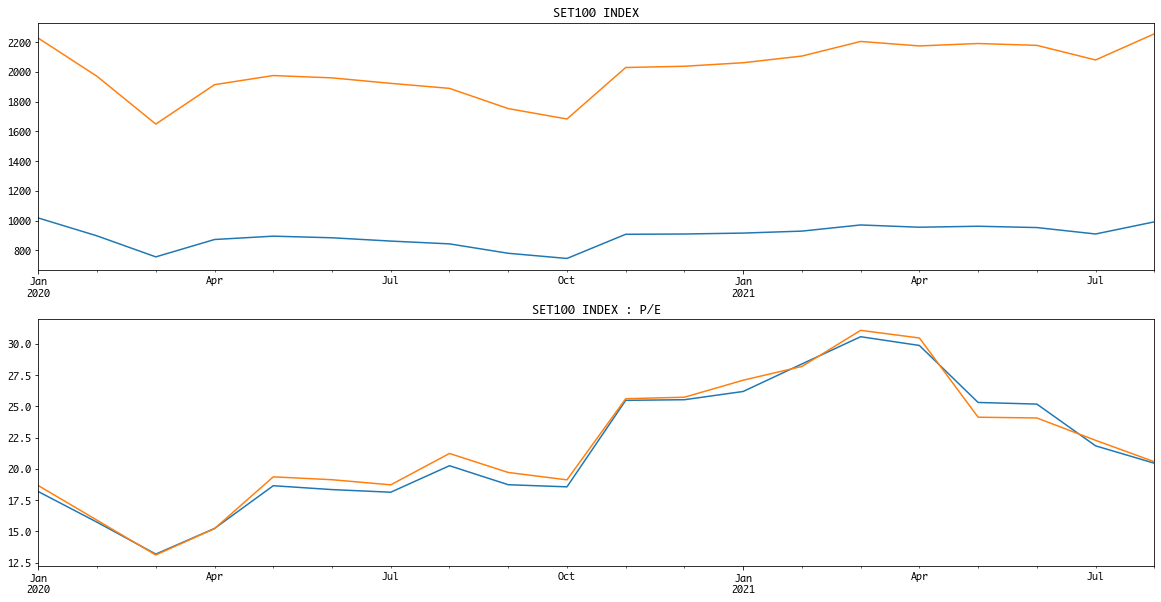

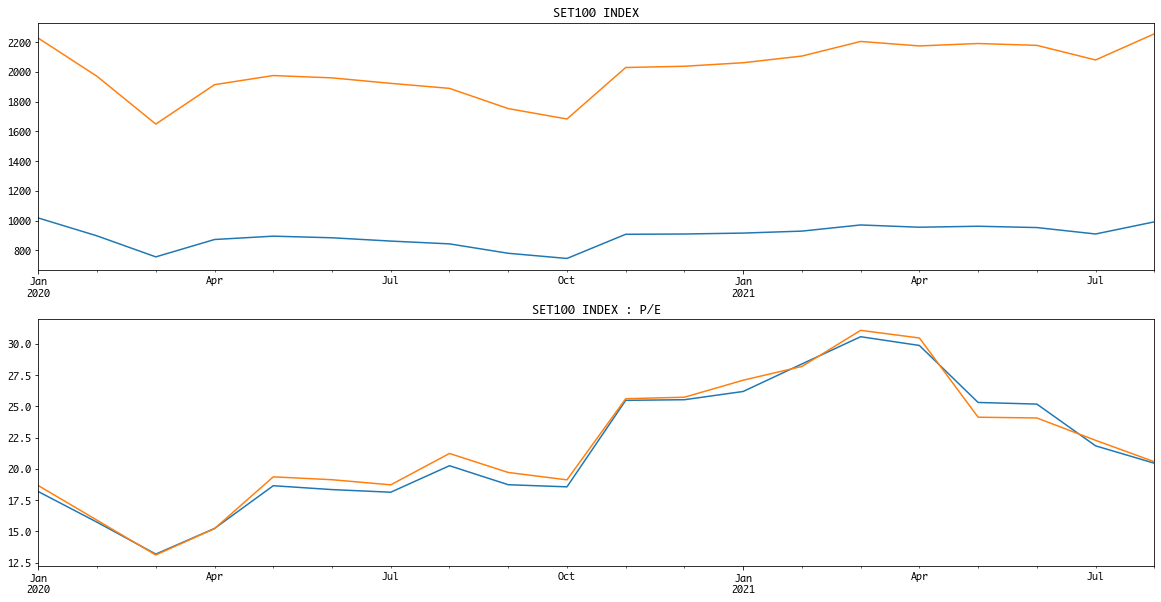

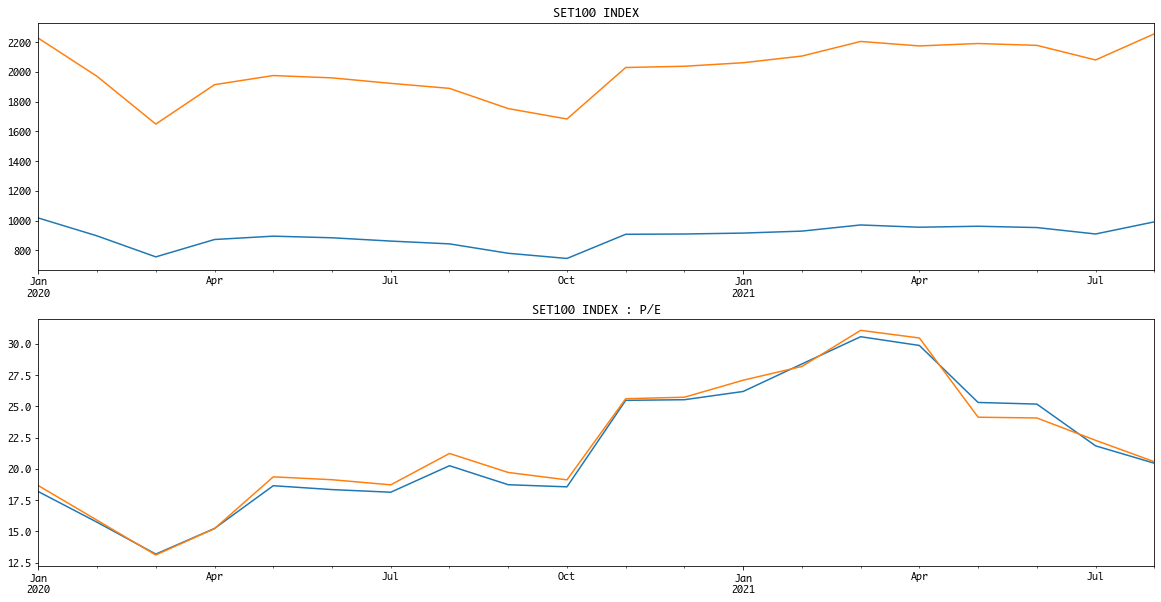

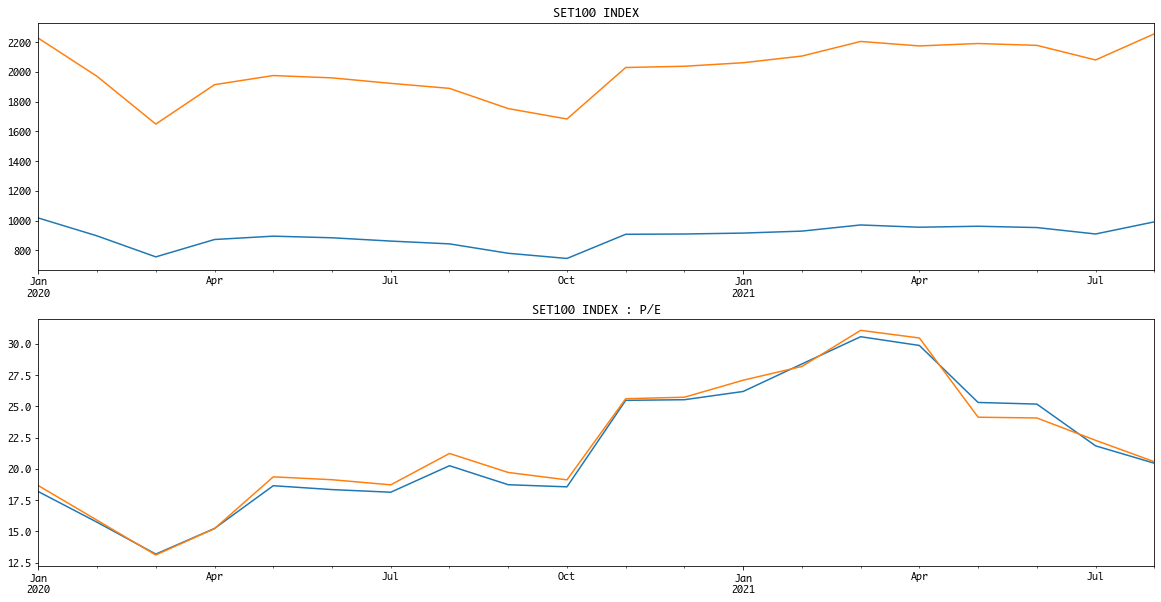

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


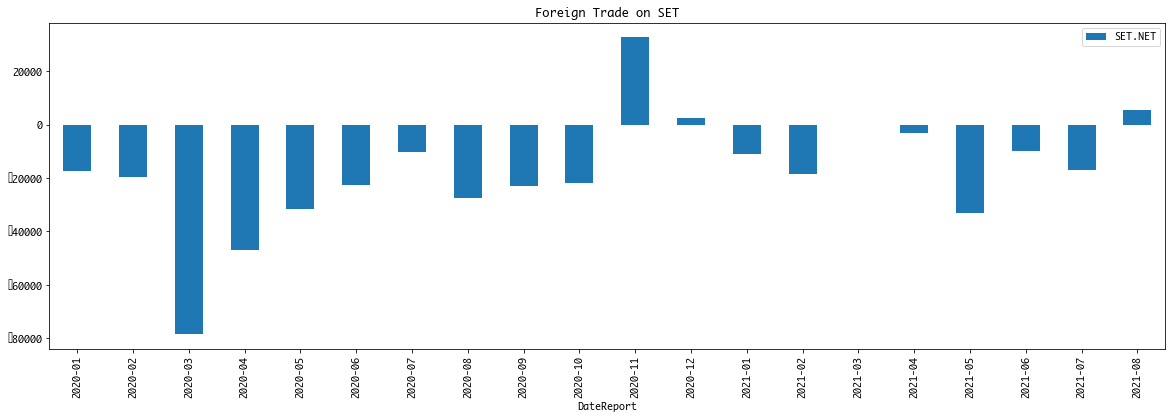

In [8]:
# List of stock symbols we are testing
stock_symbol_list = ['DELTA','KCE','SCB','INTUCH']

# Create stock data for the different symbols for testing
stock_all_data1 = get_all_sources_stock_data(stock_symbol_list[0])
stock_all_data2 = get_all_sources_stock_data(stock_symbol_list[1])
stock_all_data3 = get_all_sources_stock_data(stock_symbol_list[2])
stock_all_data4 = get_all_sources_stock_data(stock_symbol_list[3])

# Show stock data
stock_all_data1

In [9]:
# -> Granger incorrect way to use this? well it shifted but all other data is null so not good
# df_granger_transformed = create_granger_transformed_df(stock_symbol = stock_symbol, granger_period = 10)

# df_stock_scaled, stock_scaler = min_max_scaler_transform(df_stock)
# df_granger_scaled, granger_scaler = min_max_scaler_transform(df_granger_transformed)

## Explore granger causality testing
Before we are able to make any train test dataset for testing, we have to first understand that this is a time series problem. This means that if we were to use the current features for testing, we do not have the values for when we try to predict the stock prices in the future. 

In this case, we explore the granger causality testing to identify whether there is a causality lag between the two datasets. By doing so, we are able to create train sets which incorporates for the lag, which will be able to be used for further prediction.

The Granger Causality testing definition are as follows:
- The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.
- Granger causality is a statistical concept of causality that is based on prediction. 
- According to Granger causality, if a signal X1 "Granger-causes" (or "G-causes") a signal X2, then past values of X1 should contain information that helps predict X2 above and beyond the information contained in past values of X2 alone.
- Based on f test case sum square regression (error)
- The Sum of Squared regression is the sum of the differences between the predicted value and the mean of the dependent variable.

p value
- p value is the statistical significance. 
- More than 0.05 = there is no significance so no causality from these metrics
- Therefore, we take p value is less than 0.05

f test 
- The F-test is to test whether or not a group of variables has an effect on y, meaning we are to test if these variables are jointly significant.
- f test to see how significant based on others and square error for each lag time
- https://tien89.wordpress.com/2010/03/18/testing-multiple-linear-restrictions-the-f-test/

So ultimately, we want to capture the pvalue < 0.05 and the highest ftest value for each case.

In [10]:
# Explore sample data set
stock_all_data1.iloc[:,0:2]

,DELTA_CLOSE,set50_index
2020-01-01,51.75,1018.08
2020-01-02,51.75,1018.08
2020-01-03,51.50,1018.08
2020-01-05,51.50,1018.08
2020-01-06,50.25,1018.08
...,...,...
2021-08-30,570.00,992.13
2021-08-31,584.00,992.13
2021-09-01,656.00,992.13
2021-09-02,726.00,992.13


In [11]:
# Print the data columns that we are finding granger causality in
print('Granger causality testing columns:', stock_all_data1.iloc[:,0:2].columns.values)

# Test running granger causality test function for the output data
test_granger = grangercausalitytests(stock_all_data1.iloc[:,0:2],10)

Granger causality testing columns: ['DELTA_CLOSE' 'set50_index']

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4911  , p=0.4837  , df_denom=526, df_num=1
ssr based chi2 test:   chi2=0.4939  , p=0.4822  , df=1
likelihood ratio test: chi2=0.4937  , p=0.4823  , df=1
parameter F test:         F=0.4911  , p=0.4837  , df_denom=526, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2947  , p=0.7449  , df_denom=523, df_num=2
ssr based chi2 test:   chi2=0.5950  , p=0.7427  , df=2
likelihood ratio test: chi2=0.5947  , p=0.7428  , df=2
parameter F test:         F=0.2947  , p=0.7449  , df_denom=523, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2079  , p=0.8909  , df_denom=520, df_num=3
ssr based chi2 test:   chi2=0.6321  , p=0.8891  , df=3
likelihood ratio test: chi2=0.6317  , p=0.8891  , df=3
parameter F test:         F=0.2079  , p=0.8909  , df_denom=520, df_num=3

Granger Causality
number of 

In [12]:
# Initiate temp dataframe
df_granger_results = pd.DataFrame()

# Loop in the granger results data in order to sort and find the most appropriate lag period
for num, item in test_granger.items():

    # Extract the data and transpose it 
    df_ftest = pd.DataFrame(item[0]['ssr_ftest']).transpose()

    # Returned results (Fvalue, pValue, df_denom, df_num) for each of the results
    df_granger_results = pd.concat([df_granger_results, df_ftest],axis=0)

# Rename the column data for ease of access
df_granger_results.columns = ['Fvalue','pvalue','df_denom','df_num']

# Print show the results (note, we want to find the pvalue < 0.05 for significance)
df_granger_results

,Fvalue,pvalue,df_denom,df_num
0,0.491135,0.483731,526.0,1.0
0,0.294682,0.744892,523.0,2.0
0,0.207886,0.890944,520.0,3.0
0,0.172436,0.952481,517.0,4.0
0,0.139594,0.982994,514.0,5.0
0,0.127589,0.992906,511.0,6.0
0,0.114888,0.997366,508.0,7.0
0,0.109617,0.998892,505.0,8.0
0,0.163029,0.997326,502.0,9.0
0,0.143071,0.999110,499.0,10.0


## Conclude granger causality testing
Here, we can conlcude that we output the different values from granger causality testing. 
Putting it all together, we need to find the mapping for each section, and then create a transformed dataframe for the causality shift.

In [13]:
granger_period = 10

# Get data source for all stocks with its features
df_data = stock_all_data1.copy()

# Create temp dataframe to hold the granger data
df_granger = pd.DataFrame()

lag_data = []

# Loop through each data column and then evaluate the granger causality between each pair with first column of interested stock
for idx, col in tqdm(enumerate(df_data.columns)):

    # Skip the data of the first column which is our interested stock
    if idx == 0:
        continue

    # Calculate the granger causality of each pair with the first column
    df_granger_raw = grangercausalitytests(pd.concat([df_data.iloc[:,0],df_data.iloc[:,idx]],axis=1), granger_period, verbose=False)

    # Create temporary dataframe for holding the granger results
    df_granger_results = pd.DataFrame()

    # Loop in the granger results data in order to sort and find the most appropriate lag period
    for num, item in df_granger_raw.items():

        # Extract the data and transpose it 
        df_ftest = pd.DataFrame(item[0]['ssr_ftest']).transpose()

        # Returned results (Fvalue, pValue, df_denom, df_num) for each of the results
        df_granger_results = pd.concat([df_granger_results, df_ftest],axis=0)

    # Rename the column data for ease of access
    df_granger_results.columns = ['Fvalue','pvalue','df_denom','df_num']

    # Sort by the pvalue less than 0.05 for significance, and choose the highest Fvalue
    lag_array = df_granger_results[df_granger_results['pvalue'] < 0.05].sort_values(by='Fvalue', ascending=False).head(1).df_num.values

    # Set initial lag value of grangercausality to 0
    lag_value = 0

    # If the value is not zero, then get the lag. otherwise lag_value is zero
    if len(lag_array) != 0:
        lag_value = lag_array[0]
    
    # Print to show results
    print(lag_value, col)
    
    # Append data to lag value list
    lag_data.append((lag_value, col))

# Rename thee dataframe for appropriate column naming
lag_data = pd.DataFrame(lag_data).rename(columns={0 : 'lag_value', 1 : 'col'})

# Filter out the ones with lag data more than 1
lag_data = lag_data[lag_data['lag_value'] > 1].sort_values(by='lag_value', ascending=False)

0it [00:00, ?it/s]

0 set50_index
0 set100_index
0 foreign_SET.BUY
0 foreign_SET.SELL
0 TEAM_OPEN
0 TEAM_HIGH
0 TEAM_LOW
0 TEAM_CLOSE
0 TEAM_VOLUME
0 TEAM_ema10
0 TEAM_ema30
0 TEAM_ema50
0 TEAM_ma10
1.0 TEAM_ma30
0 TEAM_ma50
1.0 TEAM_ma100
0 TEAM_rsi2
0 TEAM_rsi6
8.0 TEAM_rsi14
0 TEAM_rsi30
0 KCE_OPEN
0 KCE_HIGH
3.0 KCE_LOW
0 KCE_CLOSE
2.0 KCE_VOLUME
3.0 KCE_ema10
1.0 KCE_ema30
1.0 KCE_ema50
2.0 KCE_ma10
1.0 KCE_ma30
1.0 KCE_ma50
1.0 KCE_ma100
0 KCE_rsi2
0 KCE_rsi6
0 KCE_rsi14
0 KCE_rsi30
0 METCO_OPEN
0 METCO_HIGH
0 METCO_LOW
0 METCO_CLOSE
0 METCO_VOLUME
0 METCO_ema10
0 METCO_ema30
0 METCO_ema50
3.0 METCO_ma10
0 METCO_ma30
0 METCO_ma50
0 METCO_ma100
0 METCO_rsi2
0 METCO_rsi6
0 METCO_rsi14
0 METCO_rsi30
0 HANA_OPEN
0 HANA_HIGH
0 HANA_LOW
0 HANA_CLOSE
0 HANA_VOLUME
0 HANA_ema10
3.0 HANA_ema30
2.0 HANA_ema50
0 HANA_ma10
2.0 HANA_ma30
1.0 HANA_ma50
1.0 HANA_ma100
0 HANA_rsi2
0 HANA_rsi6
0 HANA_rsi14
0 HANA_rsi30
2.0 SVI_OPEN
0 SVI_HIGH
0 SVI_LOW
0 SVI_CLOSE
0 SVI_VOLUME
0 SVI_ema10
0 SVI_ema30
1.0 SVI_ema50
0

In [469]:
def get_granger_causality_lag(df, granger_period = 10):
    '''
    Function to take in the dataframe, analyse the granger causality between the column with the rest of the features using the first column as its base.
    Then output data with the delayed lag time.
    
    Granger Causality testing
    - The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.
    - Granger causality is a statistical concept of causality that is based on prediction. 
    - According to Granger causality, if a signal X1 "Granger-causes" (or "G-causes") a signal X2, then past values of X1 should contain information that helps predict X2 above and beyond the information contained in past values of X2 alone.
    - Based on f test case sum square regression (error)
    - The Sum of Squared regression is the sum of the differences between the predicted value and the mean of the dependent variable.

    p value
    - p value is the statistical significance. 
    - More than 0.05 = there is no significance so no causality from these metrics
    - Therefore, we take p value is less than 0.05

    f test 
    - The F-test is to test whether or not a group of variables has an effect on y, meaning we are to test if these variables are jointly significant.
    - f test to see how significant based on others and square error for each lag time
    - https://tien89.wordpress.com/2010/03/18/testing-multiple-linear-restrictions-the-f-test/
    
    Input:
    - DataFrame of the stock information to process
    - granger_period - For granger causality to calculate
    
    Process:
    - Loop through data to find granger causality for each pair with the first column (with interested data)
    - Identify the most appropriate delay/lag with granger causality testing

    Output:
    - Dataframe of stock transformed data with granger causality
    - Dataframe of grangercausality lag for each column
    - Dataframe of grouped lag value data by their columns for ease of reference
    
    '''
    
    # Get data source for all stocks with its features
    df_data = df.copy()
    
    # Create dataframe for granger transformed information
    df_granger_transformed = df.copy()
    
    # Create temp dataframe to hold the granger data
    df_granger = pd.DataFrame()
    
    # Create list for temp of lag_data
    lag_data = []
    
    # Loop through each data column and then evaluate the granger causality between each pair with first column of interested stock
    for idx, col in tqdm(enumerate(df_data.columns)):

        # Skip the data of the first column which is our interested stock
        if idx == 0:
            continue
        
        try:
            
            # Calculate the granger causality of each pair with the first column
            df_granger_raw = grangercausalitytests(pd.concat([df_data.iloc[:,0],df_data.iloc[:,idx]],axis=1), granger_period, verbose=False)

            # Create temporary dataframe for holding the granger results
            df_granger_results = pd.DataFrame()

            # Loop in the granger results data in order to sort and find the most appropriate lag period
            for num, item in df_granger_raw.items():

                # Extract the data and transpose it 
                df_ftest = pd.DataFrame(item[0]['ssr_ftest']).transpose()

                # Returned results (Fvalue, pValue, df_denom, df_num) for each of the results
                df_granger_results = pd.concat([df_granger_results, df_ftest],axis=0)

            # Rename the column data for ease of access
            df_granger_results.columns = ['Fvalue','pvalue','df_denom','df_num']

            # Sort by the pvalue less than 0.05 for significance, and choose the highest Fvalue
            lag_array = df_granger_results[df_granger_results['pvalue'] < 0.05].sort_values(by='Fvalue', ascending=False).head(1).df_num.values

            # Set initial lag value of grangercausality to 0
            lag_value = 0

            # If the value is not zero, then get the lag. otherwise lag_value is zero
            if len(lag_array) != 0:
                lag_value = lag_array[0]

            # Append the data to the lag data list
            lag_data.append((lag_value, col))

            # Shift the data in the column according to the granger causality test shift
            df_granger_transformed.iloc[:,idx] = df_data.iloc[:,idx].shift(int(lag_value))

            # Backfill the data from the shift as it results in null
            df_granger_transformed.bfill(axis=0, inplace=True)
        
        except Exception as e:
            print(e)

    # Rename thee dataframe for appropriate column naming
    lag_data = pd.DataFrame(lag_data).rename(columns={0 : 'lag_value', 1 : 'col'})
    
    # Filter out the ones with lag data more than 1
    lag_data = lag_data[lag_data['lag_value'] > 1].sort_values(by='lag_value', ascending=False)
    
    # Filter out only the columns which have granger causality affect
    df_granger_transformed = df_granger_transformed[lag_data['col']]

    # Group the data by its count so ease of reference usage
    lag_data_col = lag_data.groupby('lag_value').col.apply(list).reset_index().sort_values(by='lag_value',ascending=False)
    
    return df_granger_transformed, lag_data, lag_data_col

In [15]:
df_granger_transformed, lag_data, lag_data_col = get_granger_causality_lag(stock_all_data1)
lag_data

0it [00:00, ?it/s]

,lag_value,col
108,10.0,DELTA_ma30
105,9.0,DELTA_ema30
104,9.0,DELTA_ema10
18,8.0,TEAM_rsi14
106,8.0,DELTA_ema50
109,7.0,DELTA_ma50
103,6.0,DELTA_VOLUME
135,5.0,SMT_VOLUME
102,4.0,DELTA_LOW
100,4.0,DELTA_OPEN


In [16]:
lag_data_col

,lag_value,col
8,10.0,[DELTA_ma30]
7,9.0,"[DELTA_ema30, DELTA_ema10]"
6,8.0,"[TEAM_rsi14, DELTA_ema50]"
5,7.0,[DELTA_ma50]
4,6.0,[DELTA_VOLUME]
3,5.0,[SMT_VOLUME]
2,4.0,"[DELTA_LOW, DELTA_OPEN, DELTA_gg_trends, top1_..."
1,3.0,"[SMT_ema30, CCET_VOLUME, SMT_ema10, SMT_ema50,..."
0,2.0,"[DELTA_HIGH, SVI_ma30, SVI_OPEN, HANA_ma30, HA..."


In [17]:
df_granger_transformed

,DELTA_ma30,DELTA_ema30,DELTA_ema10,TEAM_rsi14,DELTA_ema50,DELTA_ma50,DELTA_VOLUME,SMT_VOLUME,DELTA_LOW,DELTA_OPEN,...,KCE_ema10,top2_related_gg_interest,DELTA_HIGH,SVI_ma30,SVI_OPEN,HANA_ma30,HANA_ema50,KTC_SET100_corr,KCE_ma10,KCE_VOLUME
2020-01-01,53.550000,51.750000,51.750000,37.589564,51.750000,52.74,1077800.0,549500.0,51.25,53.5,...,23.200001,0.0,53.75,3.284000,3.60,35.300000,33.250000,39.25,21.440,43574700.0
2020-01-02,53.550000,51.750000,51.750000,37.589564,51.750000,52.74,1077800.0,549500.0,51.25,53.5,...,23.200001,0.0,53.75,3.284000,3.60,35.300000,33.250000,39.25,21.440,43574700.0
2020-01-03,53.550000,51.750000,51.750000,37.589564,51.750000,52.74,1077800.0,549500.0,51.25,53.5,...,23.200001,0.0,53.75,3.284000,3.60,35.300000,33.250000,39.25,21.440,43574700.0
2020-01-05,53.550000,51.750000,51.750000,37.589564,51.750000,52.74,1077800.0,549500.0,51.25,53.5,...,23.200001,0.0,53.75,3.284000,3.60,35.300000,33.250000,39.25,21.440,43574700.0
2020-01-06,53.550000,51.750000,51.750000,37.589564,51.750000,52.74,1077800.0,549500.0,51.25,53.5,...,23.200001,0.0,53.00,3.284000,3.54,35.300000,33.240196,38.75,21.440,32994100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30,577.066667,568.016270,563.069492,57.725873,556.107701,567.76,676800.0,5530000.0,556.00,572.0,...,81.504183,24.0,576.00,4.875333,4.84,75.208333,72.047608,64.50,83.025,23484500.0
2021-08-31,577.066667,568.016270,563.069492,58.090880,556.260340,567.48,1117400.0,4225600.0,562.00,564.0,...,81.504183,24.0,576.00,4.875333,4.84,75.208333,72.047608,64.50,83.025,23484500.0
2021-09-01,577.066667,567.499092,562.511402,64.099616,556.406994,567.60,849700.0,3401900.0,562.00,564.0,...,81.504183,24.0,576.00,4.874667,4.86,75.166667,72.065349,65.50,82.700,20155800.0
2021-09-02,576.933333,567.015279,562.054784,70.438984,556.940053,567.80,816900.0,3401900.0,562.00,564.0,...,80.912513,24.0,590.00,4.876000,4.86,75.033333,72.003962,66.25,81.700,36450000.0


## Create train test-predict dataset
Here, we then need to create the train-test, and train-predict dataset for our models. In our case, the only difference is that due to the fact that some of the results have different lag values, for the prediction, we will only be able to work on those grouped together so we need to create a separate train-test and train-predict.

For example, out of 100 features, only 5 features have a granger causality lag of 7 days. This means that we can only predict up to 7 days for those 5 features.

Another case that we have to consider is that out of 100 features, 5 features (A, B, C, D, E) have a lag of 7 days, and 3 features (F, G, H), have a lag of 4 days. This means that there are 2 groups that we can predict:
- Predict 7 days - Features used (A, B, C, D, E)
- Predict 4 days - Features used (A, B, C, D, E, F, G, H)

This is because there is an overlap in the lagging data.

For the difference between the train-test and train-predict case:
- Train-test -> We are using the data up to the latest day to train-test
- Train-predict -> We are using the training data up to the latest day and the granger causality lagged features part to predict

In [18]:
lag_data_col

,lag_value,col
8,10.0,[DELTA_ma30]
7,9.0,"[DELTA_ema30, DELTA_ema10]"
6,8.0,"[TEAM_rsi14, DELTA_ema50]"
5,7.0,[DELTA_ma50]
4,6.0,[DELTA_VOLUME]
3,5.0,[SMT_VOLUME]
2,4.0,"[DELTA_LOW, DELTA_OPEN, DELTA_gg_trends, top1_..."
1,3.0,"[SMT_ema30, CCET_VOLUME, SMT_ema10, SMT_ema50,..."
0,2.0,"[DELTA_HIGH, SVI_ma30, SVI_OPEN, HANA_ma30, HA..."


In [19]:
# Define the train and test size set
train_size = 200
test_size = 50

# Create an array for train-test and train-predict set for the different granger periods
train_test_list_array = []
train_pred_list_array = []

# Create a list for the accumulated column for storage and reference
col_accum = []

# Create the stock data based on the data used 
df_data = stock_all_data1.copy()

# Set the stock data that we want to compare with for creating train dataset
df_stock_data = stock_all_data1[stock_symbol_list[0] + '_CLOSE']

# Set the index to datetime format so we can shift them
df_data.index = pd.to_datetime(df_data.index)

# Loop for each lag_data_column 
for idx, data in lag_data_col.iterrows():
    
    # For each data in each column, we append the accumulated column data
    # For this case, the most lag should be in all receding data to use
    for col in data['col']:
        col_accum.append(col)
    
    # Extract the lag_value data for the stock
    lag_value = int(data['lag_value'])
    
    ########## Section to create the dataframe for train-test results ##########
    # Create the dataset for train_x
    df_train = df_granger_transformed[col_accum][-(train_size + test_size):-test_size]
    
    # Create the dataset for test_x
    df_test = df_granger_transformed[col_accum][-test_size:]
    
    # Create the dataset for train_y 
    df_stock_data_train = df_stock_data[-(train_size + test_size):-test_size]
    
    # Create the dataset for test_y
    df_stock_data_test = df_stock_data[-test_size:]
    
    # Append the data into the list for the specific lag_value
    train_test_list_array.append([lag_value, df_train, df_test, df_stock_data_train, df_stock_data_test])

    ########## Section to create the dataframe for train-predict results ##########
    # Shift the feature data for granger causality lag value
    shifted_data = df_data[col_accum].shift(periods=lag_value,freq='D')

    # Create the dataset for train_x (prediction)
    df_train_pred = shifted_data[col_accum][-(train_size + lag_value):-lag_value]
    
    # Create the dataset for test_x (prediction)
    df_test_pred = shifted_data[col_accum][-lag_value:]
    
    # Create the dataset for train_y (prediction)
    df_stock_data_train_pred = df_stock_data[-train_size:]

    # Store the data in train prediction list dataset
    train_pred_list_array.append([lag_value, df_train_pred, df_test_pred, df_stock_data_train_pred])
    

In [20]:
# Print out the lag value corresponding with lag_data_col
print('lag_value:',train_test_list_array[2][0])
print(lag_data_col[lag_data_col['lag_value'] >= train_test_list_array[2][0]])

# Print out to test the case 
train_test_list_array[2][1]

lag_value: 8
   lag_value                         col
8       10.0                [DELTA_ma30]
7        9.0  [DELTA_ema30, DELTA_ema10]
6        8.0   [TEAM_rsi14, DELTA_ema50]


,DELTA_ma30,DELTA_ema30,DELTA_ema10,TEAM_rsi14,DELTA_ema50
2020-12-06,184.450000,181.274566,189.438860,67.347346,172.494677
2020-12-08,184.450000,184.095562,195.904522,61.304763,174.985082
2020-12-09,185.283333,187.444235,203.194609,61.304763,174.985082
2020-12-13,186.983333,187.444235,203.194609,61.304763,177.181746
2020-12-14,186.983333,190.254285,208.250135,61.304763,179.174618
...,...,...,...,...,...
2021-07-11,551.133333,537.259154,558.528799,55.445976,509.911108
2021-07-12,552.600000,537.259154,558.528799,55.445976,509.911108
2021-07-13,552.600000,537.259154,558.528799,53.392006,511.326359
2021-07-14,552.600000,537.823079,556.250836,53.392006,513.627286


In [21]:
# Print out the lag value corresponding with lag_data_col
print('lag_value:',train_pred_list_array[2][0])
print(lag_data_col[lag_data_col['lag_value'] >= train_pred_list_array[2][0]])

# Print out to test the case 
train_pred_list_array[2][1]

lag_value: 8
   lag_value                         col
8       10.0                [DELTA_ma30]
7        9.0  [DELTA_ema30, DELTA_ema10]
6        8.0   [TEAM_rsi14, DELTA_ema50]


,DELTA_ma30,DELTA_ema30,DELTA_ema10,TEAM_rsi14,DELTA_ema50
2021-02-05,542.800000,517.076928,546.270964,58.951131,452.552280
2021-02-06,548.866667,517.781642,542.948970,58.951131,455.511014
2021-02-08,548.866667,517.781642,542.948970,58.951131,455.511014
2021-02-09,553.333333,515.989278,533.321885,48.225071,456.863524
2021-02-10,557.966667,514.957712,527.263360,48.225071,458.555150
...,...,...,...,...,...
2021-08-30,577.066667,568.016270,563.069492,57.725873,556.107701
2021-08-31,576.933333,567.499092,562.511402,58.090880,556.260340
2021-09-01,576.933333,567.015279,562.054784,64.099616,556.406994
2021-09-02,576.333333,567.207842,563.499369,70.438984,556.940053


In [22]:
stock_all_data2.iloc[:,0]

2020-01-01    23.200001
2020-01-02    23.200001
2020-01-03    22.400000
2020-01-05    22.400000
2020-01-06    21.500000
                ...    
2021-08-30    78.250000
2021-08-31    76.500000
2021-09-01    78.250000
2021-09-02    79.250000
2021-09-03    78.250000
Name: KCE_CLOSE, Length: 530, dtype: float64

## Conclude train test-predict dataset
In conclusion to this case, we are going to create a function that takes in the stock raw dataframe, the train size, and test size, and will output the train-test split with granger causality considered

In [435]:
def create_train_test_predict_split_with_granger(df, train_size = 200, test_size = 50):
    '''
    Function to create train-test, train-predict dataset split for the stock source data input.
    Outcome of this function is to return the list of data with the train/test/predict split based on the different lag values.
    
    Input:
    - df = Dataframe of the stock_all_source data (with the first column being the stock of interest)
    - train_size = Training size for the split
    - test_size = Testing size for the split
    
    Output:
    - train_test_list_array = List of train_test split with (lag_value, train_x, test_x, train_y, test_y) dataset
    - train_pred_list_array = List of train_pred split with (lag_value, train_pred_x, test_pred_x, train_pred_y) dataset
    
    '''
    
    # Create an array for train-test and train-predict set for the different granger periods
    train_test_list_array = []
    train_pred_list_array = []

    # Create a list for the accumulated column for storage and reference
    col_accum = []

    # Create the stock data based on the data used 
    df_data = df.copy()

    # Set the stock data that we are testing for y value (assume first column data)
    df_stock_data = df.iloc[:,0]

    # Set the index to datetime format so we can shift them
    df_data.index = pd.to_datetime(df_data.index)
        
    # Create granger transformed and lag data
    df_granger_transformed, lag_data, lag_data_col = get_granger_causality_lag(df)

    # Loop for each lag_data_column 
    for idx, data in lag_data_col.iterrows():

        # For each data in each column, we append the accumulated column data
        # For this case, the most lag should be in all receding data to use
        for col in data['col']:
            col_accum.append(col)

        # Extract the lag_value data for the stock
        lag_value = int(data['lag_value'])

        ########## Section to create the dataframe for train-test results ##########
        # Create the dataset for train_x
        df_train = df_granger_transformed[col_accum][-(train_size + test_size):-test_size]

        # Create the dataset for test_x
        df_test = df_granger_transformed[col_accum][-test_size:]

        # Create the dataset for train_y 
        df_stock_data_train = df_stock_data[-(train_size + test_size):-test_size]

        # Create the dataset for test_y
        df_stock_data_test = df_stock_data[-test_size:]

        # Append the data into the list for the specific lag_value
        train_test_list_array.append([lag_value, df_train, df_test, df_stock_data_train, df_stock_data_test])

        ########## Section to create the dataframe for train-predict results ##########
        # Shift the feature data for granger causality lag value
        shifted_data = df_data[col_accum].shift(periods=lag_value,freq='D')

        # Create the dataset for train_x (prediction)
        df_train_pred = shifted_data[col_accum][-(train_size + lag_value):-lag_value]

        # Create the dataset for test_x (prediction)
        df_test_pred = shifted_data[col_accum][-lag_value:]

        # Create the dataset for train_y (prediction)
        df_stock_data_train_pred = df_stock_data[-train_size:]

        # Store the data in train prediction list dataset
        train_pred_list_array.append([lag_value, df_train_pred, df_test_pred, df_stock_data_train_pred])

    return train_test_list_array, train_pred_list_array

In [436]:
train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)
train_test1[0][1]

0it [00:00, ?it/s]

,DELTA_ma30
2020-12-06,184.450000
2020-12-08,184.450000
2020-12-09,185.283333
2020-12-13,186.983333
2020-12-14,186.983333
...,...
2021-07-11,551.133333
2021-07-12,552.600000
2021-07-13,552.600000
2021-07-14,552.600000


## Training and optimising models
Here, we are going to be using our train-test split data to model our results. Model algorithms that we are going to work with are the following:
- Linear regression
- Random forest regressor
- SVM (SVR)
- Gradient boosting regression
- SVR (poly)
- Facebook prophet
- LSTM

These were picked based on research and their performance with stock data prediction.
The main performance measure that we are going to use for this case is RMSE (Root Mean Square Error) as there is no definite way to say whether the prediction is 100% correct or not, only how close to the prediction it gets.

For each model
- Test multiple stocks inputted
- Test different train/test dataset size
- Output performance for each model and stock in a dataframe
- Show the plots for performance RMSE
- Show the train/test result plot


### Simple modelling of each algorithm
First here, we are going to go through simple modelling of each algorithm used to get familiar with it and show basic plots. After that, we can then move on to identify the appropriate training size and other parameters.

For each algorithm, we are going to run 4 results, and show 4 plots for the train_test 
- Linear regression
- Random forest regressor
- SVM (SVR)
- Gradient boosting regression
- SVR (poly)
- Facebook prophet
- LSTM

Note, as we work with multiple features, we need to scale them appropriately as well otherwise the features have different dimensions and would not be able to train appropriately. This is using the minmaxscaler function we created before.

In [25]:
# Create train test set for stock data1
train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)

# Define the data point that we want to use (which lag value data)
data_point = 2

# Define the stock symbol column name with _CLOSE
stock_symbol_close = stock_symbol_list[0] + '_CLOSE'

# Define the train and test datasets
train_x = train_test_list_array[data_point][1]
test_x = train_test_list_array[data_point][2]
train_y = train_test_list_array[data_point][3]
test_y = train_test_list_array[data_point][4]

# Scale all the features so that it is in the same scale for testing
df_transformed1, scaler1 = min_max_scaler_transform(pd.concat([train_x,train_y],axis=1))

# Drop and split the transformed dataframe out appropriately
train_x = df_transformed1.drop(stock_symbol_close,axis=1)
train_y = df_transformed1[stock_symbol_close]

# Scale the test results using the same scaler as above
temp_scale_test = pd.DataFrame(scaler1.transform(pd.concat([test_x,test_y], axis=1)))
temp_scale_test.columns = np.concatenate((test_x.columns, [stock_symbol_close]))

# Drop the interest data in the dataframe that we do not want
test_x = temp_scale_test.drop(stock_symbol_close,axis=1)
test_y = temp_scale_test[stock_symbol_close]

# Reset the index data for the date for each as lost when scale
test_x.index = train_test_list_array[data_point][2].index
test_y.index = train_test_list_array[data_point][4].index

# Create dataframe for test_y for plotting and testing performance purposes
df_test_y = test_y.reset_index().drop('index',axis=1)
df_test_y.index = test_y.index

print('lag_value:', train_test_list_array[data_point][0])
print('train size:', train_x.shape[0])
print('test size:', test_x.shape[0])
print('features used:', train_x.shape[1])
print('feature columns:', train_x.columns.values)

200


0it [00:00, ?it/s]

lag_value: 8
train size: 200
test size: 50
features used: 5
feature columns: ['DELTA_ma30' 'DELTA_ema30' 'DELTA_ema10' 'TEAM_rsi14' 'DELTA_ema50']


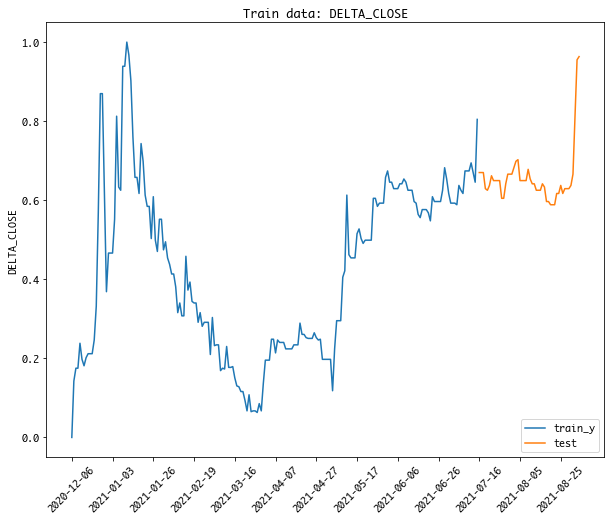

In [26]:
# Plot to show the training data and testing data used
plt.figure(figsize=(10,8))
sns.lineplot(data=train_y, x = train_y.index, y=train_y, label='train_y')
sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='test')
plt.title('Train data: ' + stock_symbol_close)
plt.xticks(np.arange(0, train_size + test_size, step=20),rotation=45)
plt.show()

In [27]:
########## Linear Regression ##########
# Linear regression model and prediction
reg = LinearRegression().fit(train_x,train_y)
pred_reg = reg.predict(test_x)

########## Random forest regressor ##########
# Random Forest regressor training and testing
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(train_x,train_y)
pred_regr = regr.predict(test_x)

########## Linear SVR ##########
# Linear SVR training and testing
lin_svr_regr = LinearSVR(random_state=0, tol=1e-5)
lin_svr_regr.fit(train_x, train_y)
pred_lin_svr = lin_svr_regr.predict(test_x)

########## Gradient boosting regressor ##########
# Gradient boosting regressor training and testing
grad_bst_regr = GradientBoostingRegressor(random_state=0)
grad_bst_regr.fit(train_x, train_y)
pred_grad_bst = grad_bst_regr.predict(test_x)

########## SVR (polynomial) ##########
# SVR polynomial training and testing
regr_svr_poly = svm.SVR(kernel = 'poly') 
regr_svr_poly.fit(train_x, train_y)
pred_svr_poly = regr_svr_poly.predict(test_x)


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.85683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       229.068    0.00210734        79.351   2.847e-05       0.001      157  LS failed, Hessian reset 
      99       229.211    0.00012926       65.5338       0.656       0.656      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       229.966     0.0002211        72.214   3.635e-06       0.001      280  LS failed, Hessian reset 
     199       230.037    2.2229e-06       51.7779      0.2047           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       230.037   9.77804e-09       80.6435     0.04268     0.04268      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


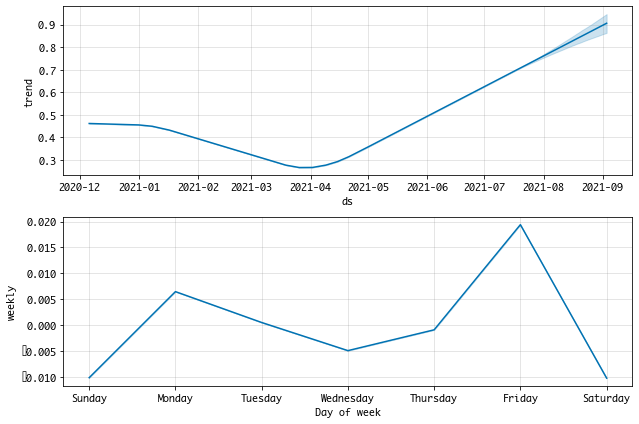

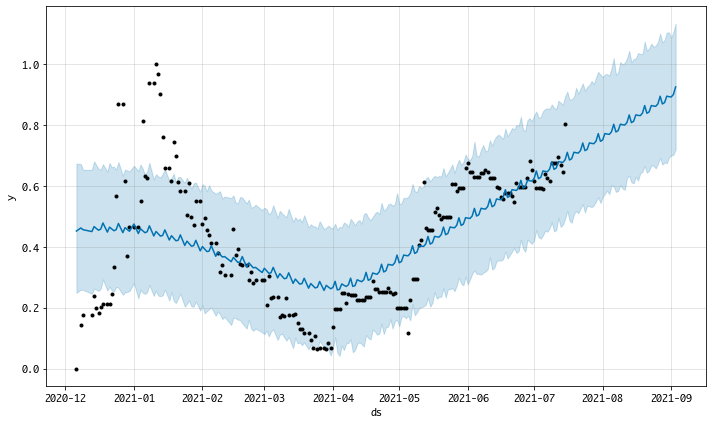

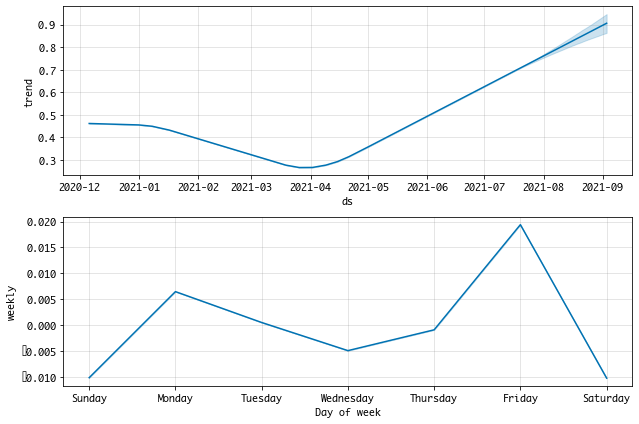

In [28]:
########## Facebook prophet ##########
# Update dataset to match Facebook prophet usage protocol
temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

# Facebook prophet training and testing
m = Prophet()
m.fit(temp_prophet_df)
future = m.make_future_dataframe(periods=len(test_x))
forecast = m.predict(future)

# Shows output plots
m.plot(forecast)
m.plot_components(forecast)

In [29]:
########## LSTM (Long Short Term Memory) ##########
# Setup the data shape accordingly for LSTM
X = np.array(train_x)
train_x2 = X.reshape(X.shape[0],1,X.shape[1])
X2 = np.array(test_x)
test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

# Instantiate LSTM
model = Sequential()

# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
model.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# epoch number times to run data in
model.fit(train_x2,train_y,epochs=10,batch_size=30)
pred_lstm = model.predict(test_x2)

# Input is 3d so need to reshape
pred_lstm = pred_lstm.reshape(-1)


2021-09-04 18:10:48.703611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-04 18:10:48.815368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.2310
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2163
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2021
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1886
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1756
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1632
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1512
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1390
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1275
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1167


In [30]:
# Clean the dataframe to use for calculation and plotting
df_pred_linreg = pd.DataFrame(pred_reg).rename(columns={0:'pred'})
df_pred_randforr = pd.DataFrame(pred_regr).rename(columns={0:'pred'})
df_pred_linsvr = pd.DataFrame(pred_lin_svr).rename(columns={0:'pred'})
df_pred_grad_bst = pd.DataFrame(pred_grad_bst).rename(columns={0:'pred'})
df_pred_svr_poly = pd.DataFrame(pred_svr_poly).rename(columns={0:'pred'})
df_pred_prophet = pd.DataFrame(forecast['yhat'][-test_size:]).rename(columns={0:'pred'})
df_pred_lstm = pd.DataFrame(pred_lstm).rename(columns={0:'pred'})

# Calculate the RMSE for the error and performance
rmse_linreg = mean_squared_error(df_pred_linreg['pred'],df_test_y[stock_symbol_close], squared=False)
rmse_randforr = mean_squared_error(df_pred_randforr['pred'],df_test_y[stock_symbol_close], squared=False)
rmse_linsvr = mean_squared_error(df_pred_linsvr['pred'],df_test_y[stock_symbol_close], squared=False)
rmse_grad_bst = mean_squared_error(df_pred_grad_bst['pred'],df_test_y[stock_symbol_close], squared=False)
rmse_svr_poly = mean_squared_error(df_pred_svr_poly['pred'],df_test_y[stock_symbol_close], squared=False)
rmse_prophet = mean_squared_error(df_pred_prophet['yhat'],df_test_y[stock_symbol_close], squared=False)
rmse_lstm = mean_squared_error(df_pred_lstm['pred'],df_test_y[stock_symbol_close], squared=False)

# Print out the RMSE results
print('RMSE linear regression:',rmse_linreg)
print('RMSE random forest regressor:',rmse_randforr)
print('RMSE Linear SVR:',rmse_linsvr)
print('RMSE Gradient boosting:',rmse_grad_bst)
print('RMSE SVR polynomial:',rmse_svr_poly)
print('RMSE Facebook prophet:',rmse_prophet)
print('RMSE LSTM:',rmse_lstm)

RMSE linear regression: 0.18567002083108686
RMSE random forest regressor: 0.14443313082586015
RMSE Linear SVR: 0.1691357083312035
RMSE Gradient boosting: 0.07859073994897323
RMSE SVR polynomial: 0.1480330908207349
RMSE Facebook prophet: 0.16484067117892764
RMSE LSTM: 0.44606193141195705


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


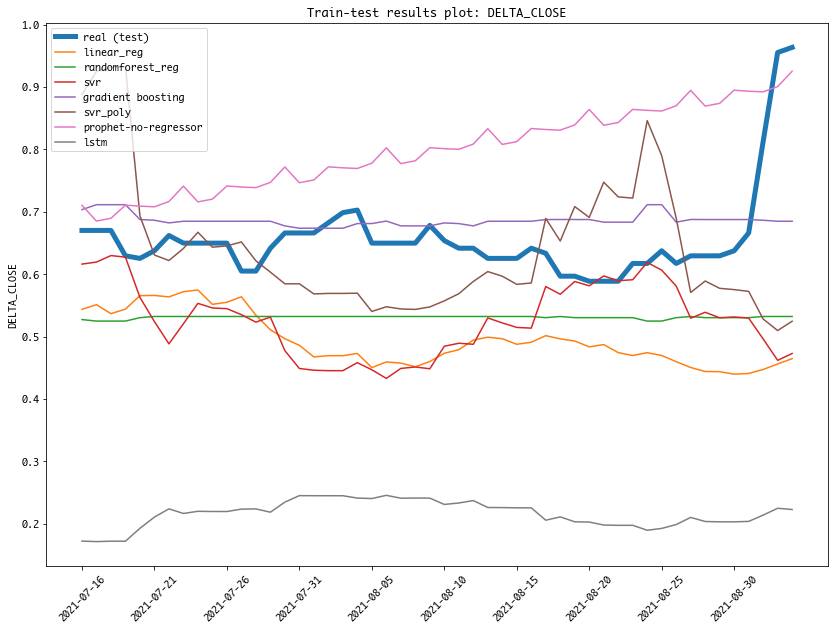

In [31]:
# Set the index of prophet to be the same as others
df_pred_prophet.index = df_pred_linreg.index

# Plot results to visualise output
plt.figure(figsize=(14,10))
sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='real (test)', linewidth = 5)
sns.lineplot(data=df_pred_linreg, x = df_pred_linreg.index, y='pred', label='linear_reg')
sns.lineplot(data=df_pred_randforr, x = df_pred_randforr.index, y='pred', label='randomforest_reg')
sns.lineplot(data=df_pred_linsvr, x = df_pred_linsvr.index, y='pred', label='svr')
sns.lineplot(data=df_pred_grad_bst, x = df_pred_grad_bst.index, y='pred', label='gradient boosting')
sns.lineplot(data=df_pred_svr_poly, x = df_pred_svr_poly.index, y='pred', label='svr_poly')
sns.lineplot(data=df_pred_prophet, x = df_pred_prophet.index, y='yhat', label='prophet-no-regressor')
sns.lineplot(data=df_pred_lstm, x = df_pred_lstm.index, y='pred', label='lstm')
plt.xticks(np.arange(0, test_size, step=5),rotation=45)
plt.title('Train-test results plot: ' + stock_symbol_close)
plt.show()

In [32]:
def simple_modelling_results(train_x, train_y, test_x, test_y, df_test_y):
    ''' 
    Function to run the simple model results provided with the training and test data
    
    Input:
    - train, test dataset
    
    Output:
    - RMSE list of the results for comparison
    
    '''

    ########## Linear Regression ##########
    # Linear regression model and prediction
    reg = LinearRegression().fit(train_x,train_y)
    pred_reg = reg.predict(test_x)

    ########## Random forest regressor ##########
    # Random Forest regressor training and testing
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(train_x,train_y)
    pred_regr = regr.predict(test_x)

    ########## Linear SVR ##########
    # Linear SVR training and testing
    lin_svr_regr = LinearSVR(random_state=0, tol=1e-5)
    lin_svr_regr.fit(train_x, train_y)
    pred_lin_svr = lin_svr_regr.predict(test_x)

    ########## Gradient boosting regressor ##########
    # Gradient boosting regressor training and testing
    grad_bst_regr = GradientBoostingRegressor(random_state=0)
    grad_bst_regr.fit(train_x, train_y)
    pred_grad_bst = grad_bst_regr.predict(test_x)

    ########## SVR (polynomial) ##########
    # SVR polynomial training and testing
    regr_svr_poly = svm.SVR(kernel = 'poly') 
    regr_svr_poly.fit(train_x, train_y)
    pred_svr_poly = regr_svr_poly.predict(test_x)

    ########## Facebook prophet ##########
    # Update dataset to match Facebook prophet usage protocol
    temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

    # Facebook prophet training and testing
    m = Prophet()
    m.fit(temp_prophet_df)
    future = m.make_future_dataframe(periods=len(test_x))
    forecast = m.predict(future)

    ########## LSTM (Long Short Term Memory) ##########
    # Setup the data shape accordingly for LSTM
    X = np.array(train_x)
    train_x2 = X.reshape(X.shape[0],1,X.shape[1])
    X2 = np.array(test_x)
    test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

    # Instantiate LSTM
    model = Sequential()

    # Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
    model.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # epoch number times to run data in
    model.fit(train_x2,train_y,epochs=10,batch_size=30)
    pred_lstm = model.predict(test_x2)

    # Input is 3d so need to reshape
    pred_lstm = pred_lstm.reshape(-1)
    
    # Clean the dataframe to use for calculation and plotting
    df_pred_linreg = pd.DataFrame(pred_reg).rename(columns={0:'pred'})
    df_pred_randforr = pd.DataFrame(pred_regr).rename(columns={0:'pred'})
    df_pred_linsvr = pd.DataFrame(pred_lin_svr).rename(columns={0:'pred'})
    df_pred_grad_bst = pd.DataFrame(pred_grad_bst).rename(columns={0:'pred'})
    df_pred_svr_poly = pd.DataFrame(pred_svr_poly).rename(columns={0:'pred'})
    df_pred_prophet = pd.DataFrame(forecast['yhat'][-test_size:]).rename(columns={0:'pred'})
    df_pred_lstm = pd.DataFrame(pred_lstm).rename(columns={0:'pred'})

    # Calculate the RMSE for the error and performance
    rmse_linreg = mean_squared_error(df_pred_linreg['pred'],df_test_y[stock_symbol_close], squared=False)
    rmse_randforr = mean_squared_error(df_pred_randforr['pred'],df_test_y[stock_symbol_close], squared=False)
    rmse_linsvr = mean_squared_error(df_pred_linsvr['pred'],df_test_y[stock_symbol_close], squared=False)
    rmse_grad_bst = mean_squared_error(df_pred_grad_bst['pred'],df_test_y[stock_symbol_close], squared=False)
    rmse_svr_poly = mean_squared_error(df_pred_svr_poly['pred'],df_test_y[stock_symbol_close], squared=False)
    rmse_prophet = mean_squared_error(df_pred_prophet['yhat'],df_test_y[stock_symbol_close], squared=False)
    rmse_lstm = mean_squared_error(df_pred_lstm['pred'],df_test_y[stock_symbol_close], squared=False)

    # Print out the RMSE results
    print('RMSE linear regression:',rmse_linreg)
    print('RMSE random forest regressor:',rmse_randforr)
    print('RMSE Linear SVR:',rmse_linsvr)
    print('RMSE Gradient boosting:',rmse_grad_bst)
    print('RMSE SVR polynomial:',rmse_svr_poly)
    print('RMSE Facebook prophet:',rmse_prophet)
    print('RMSE LSTM:',rmse_lstm)
    
    # Create list of the data to return
    rmse_list = []
    rmse_list.append(['linear regression',rmse_linreg])
    rmse_list.append(['random forest regressor',rmse_randforr])
    rmse_list.append(['Linear SVR',rmse_linsvr])
    rmse_list.append(['Gradient boosting',rmse_grad_bst])
    rmse_list.append(['SVR polynomial',rmse_svr_poly])
    rmse_list.append(['Facebook prophet',rmse_prophet])
    rmse_list.append(['LSTM',rmse_lstm])
    
    return rmse_list
    

In [34]:
rmse_list = simple_modelling_results(train_x, train_y,test_x,test_y,df_test_y)
rmse_list[0]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.85683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       229.068    0.00210734        79.351   2.847e-05       0.001      157  LS failed, Hessian reset 
      99       229.211    0.00012926       65.5338       0.656       0.656      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       229.966     0.0002211        72.214   3.635e-06       0.001      280  LS failed, Hessian reset 
     199       230.037    2.2229e-06       51.7779      0.2047           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       230.037   9.77804e-09       80.6435     0.04268     0.04268      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.2298
Epoch 2/10
7/7 [==

['linear regression', 0.18567002083108686]

### Optimise training size
Here, we are going to identify the optimial training size to use. This is through testing multiple training pairing and plotting to see which one have the best RMSE performance results and picking that one.

The cases that we are going to test is train size:
- 400
- 350
- 300
- 250
- 200
- 150
- 100
- 50
- 30

For the test size, we are going to fix it at 50

In [446]:
def clean_train_test_data(train_test, stock_symbol = 'DELTA_CLOSE', data_index = 2):
    '''
    Function to clean the train and test data that was prepared before modelling.
    
    Input:
    - train_test dataframe from create_train_test_predict_split_with_granger
    
    Output:
    - train_x, train_y, test_x, test_y = Data for modelling ujsage
    - df_test_y = For plotting purposes
    
    '''


    # Define the data point that we want to use (which lag value data)
    data_point = data_index

    # Define the stock symbol column name with _CLOSE
    stock_symbol_close = stock_symbol

    # Define the train and test datasets
    train_x = train_test[data_point][1]
    test_x = train_test[data_point][2]
    train_y = train_test[data_point][3]
    test_y = train_test[data_point][4]

    # Scale all the features so that it is in the same scale for testing
    df_transformed1, scaler1 = min_max_scaler_transform(pd.concat([train_x,train_y],axis=1))

    # Drop and split the transformed dataframe out appropriately
    train_x = df_transformed1.drop(stock_symbol_close,axis=1)
    train_y = df_transformed1[stock_symbol_close]

    # Scale the test results using the same scaler as above
    temp_scale_test = pd.DataFrame(scaler1.transform(pd.concat([test_x,test_y], axis=1)))
    temp_scale_test.columns = np.concatenate((test_x.columns, [stock_symbol_close]))

    # Drop the interest data in the dataframe that we do not want
    test_x = temp_scale_test.drop(stock_symbol_close,axis=1)
    test_y = temp_scale_test[stock_symbol_close]

    # Reset the index data for the date for each as lost when scale
    test_x.index = train_test[data_point][2].index
    test_y.index = train_test[data_point][4].index

    # Create dataframe for test_y for plotting and testing performance purposes
    df_test_y = test_y.reset_index().drop('index',axis=1)
    df_test_y.index = test_y.index

    return train_x, train_y, test_x, test_y, df_test_y

In [36]:
clean_train_test_data(train_test1)

(            DELTA_ma30  DELTA_ema30  DELTA_ema10  TEAM_rsi14  DELTA_ema50
 2020-12-06    0.000000     0.000000     0.000000    0.560066     0.000000
 2020-12-08    0.000000     0.007866     0.014516    0.412809     0.007258
 2020-12-09    0.002182     0.017204     0.030883    0.412809     0.007258
 2020-12-13    0.006633     0.017204     0.030883    0.412809     0.013661
 2020-12-14    0.006633     0.025039     0.042233    0.412809     0.019469
 ...                ...          ...          ...         ...          ...
 2021-07-11    0.960030     0.992639     0.828635    0.270030     0.983412
 2021-07-12    0.963870     0.992639     0.828635    0.270030     0.983412
 2021-07-13    0.963870     0.992639     0.828635    0.219975     0.987536
 2021-07-14    0.963870     0.994211     0.823521    0.219975     0.994243
 2021-07-15    0.968059     1.000000     0.829133    0.141199     1.000000
 
 [200 rows x 5 columns],
 2020-12-06    0.000000
 2020-12-08    0.142566
 2020-12-09    0.175153
 

In [37]:
# Define the pairing to test
pair_value = [(400,50)
                , (350,50)
                , (300,50)
                , (250,50)
                , (200,50)
                , (150,50)
                , (100,50)
                , (50,50)
                , (30,50)
    ]

In [38]:
# Create the temp list of the results for storage
rmse_all_list = []

# Loop in the data for each pair value
for train_size, test_size in pair_value:
    
    # Create the train test split with the new train_size
    train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = train_size, test_size = 50)
   
    # Create the train test data output
    train_x, train_y, test_x, test_y, df_test_y = clean_train_test_data(train_test1)
    
    # Save and store the data in rmse all lise
    rmse_list = simple_modelling_results(train_x, train_y, test_x, test_y, df_test_y)
    rmse_all_list.append([train_size,rmse_list])
    
    print('train_test1 shape:', train_test1[2][1].shape)
    print('train_pred1 shape:', train_pred1[2][1].shape) 
    print('train_x shape:', train_x.shape)
    print('train_y shape:', train_y.shape)
    print('test_x shape:', test_x.shape)
    print('test_y shape:', test_y.shape)

rmse_all_list

400


0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.15726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.401     0.0246231       109.652           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       646.103   0.000226405       66.2012      0.3723      0.3723      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       646.188    0.00107338       78.9743   1.841e-05       0.001      291  LS failed, Hessian reset 
     299       646.249   7.09621e-08       62.7353      0.3258      0.9001      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       646.249   1.29809e-08       65.8745      0.2973      0.2973      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Epoch 1/10
14/14 [========

0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.19691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       531.146    0.00247835       79.7372      0.8118      0.8118      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       538.336    0.00646832       85.4181           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       540.361    0.00153905       115.018    1.56e-05       0.001      324  LS failed, Hessian reset 
     299       541.112    0.00156675       83.1523           1           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       542.024   2.61499e-05       61.0557      0.4293           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       542.835   0.000239154    

0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.53166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       418.368   0.000299763       61.5048   4.585e-06       0.001      176  LS failed, Hessian reset 
      99       418.372   5.48832e-05       60.1423       0.811       0.811      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       418.382   1.11929e-05       66.4887   1.351e-07       0.001      259  LS failed, Hessian reset 
     167       418.383   1.28875e-08        68.475      0.2869      0.2869      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Epoch 1/10
10/10 [==============================] - 1s 1ms/step - loss: 0.1268
Epoch 2/10
10/10 [==============================] - 0s 947us/step - loss: 0.1057
Epoch 3/10
10/10 [==============================] - 0s 934us/step - loss: 0.0865
Epoch 4/10
10/10 [==============

RMSE linear regression: 0.07493076309679939
RMSE random forest regressor: 0.07691836256147805
RMSE Linear SVR: 0.0638108364415426
RMSE Gradient boosting: 0.0809466733340918
RMSE SVR polynomial: 0.3239631688041654
RMSE Facebook prophet: 0.07898867939511717
RMSE LSTM: 0.06918271305382305
train_test1 shape: (300, 5)
train_pred1 shape: (300, 5)
train_x shape: (300, 5)
train_y shape: (300,)
test_x shape: (50, 5)
test_y shape: (50,)
250


0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.42411
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       307.945     0.0297409       119.438      0.9718      0.9718      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       310.492     0.0015559       77.5904     2.4e-05       0.001      272  LS failed, Hessian reset 
     199       310.656   0.000580407       61.9473      0.7931      0.7931      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       310.841   0.000485577        75.015    7.47e-06       0.001      430  LS failed, Hessian reset 
     299       310.944   4.41945e-06       64.3712      0.6177      0.6177      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       310.946   5.37573e-06       73.2132   7.631e-08       0.001      530  LS failed, Hessian rese

RMSE linear regression: 0.09060339290272187
RMSE random forest regressor: 0.09200034128149992
RMSE Linear SVR: 0.07042243590344925
RMSE Gradient boosting: 0.08897506152289772
RMSE SVR polynomial: 0.30091780419325903
RMSE Facebook prophet: 0.13491645161165772
RMSE LSTM: 0.14700685053913837
train_test1 shape: (250, 5)
train_pred1 shape: (250, 5)
train_x shape: (250, 5)
train_y shape: (250,)
test_x shape: (50, 5)
test_y shape: (50,)
200


0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.85683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       229.068    0.00210734        79.351   2.847e-05       0.001      157  LS failed, Hessian reset 
      99       229.211    0.00012926       65.5338       0.656       0.656      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       229.966     0.0002211        72.214   3.635e-06       0.001      280  LS failed, Hessian reset 
     199       230.037    2.2229e-06       51.7779      0.2047           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       230.037   9.77804e-09       80.6435     0.04268     0.04268      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1652
Epoch 2/10
7/7 [==

0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.3313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55        221.23    0.00687208       93.5559   8.389e-05       0.001      107  LS failed, Hessian reset 
      99       223.275   0.000684599        75.536      0.3759           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       224.346    0.00413681       98.6037    5.82e-05       0.001      224  LS failed, Hessian reset 
     182       225.235   0.000230005       81.3058   3.362e-06       0.001      339  LS failed, Hessian reset 
     199       225.253   7.56082e-05       57.0501      0.8648      0.8648      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       225.607    9.7811e-05       70.0313      0.4891      0.4891      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.87487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81        168.05   0.000500601       67.6033   5.528e-06       0.001      142  LS failed, Hessian reset 
      99       168.085    3.6525e-05       66.8573      0.9435      0.9435      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       168.198   0.000525177       68.9563   7.374e-06       0.001      278  LS failed, Hessian reset 
     199       168.295   8.36045e-06       71.8208      0.4176      0.4176      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       168.296   1.54056e-07       72.8769   1.873e-09       0.001      448  LS failed, Hessian reset 
     259       168.296   4.66846e-09       65.6935      0.3655           1      460   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -18.6518
Iteration  1. Log joint probability =    31.2138. Improved by 49.8656.
Iteration  2. Log joint probability =     57.468. Improved by 26.2542.
Iteration  3. Log joint probability =    66.0641. Improved by 8.59605.
Iteration  4. Log joint probability =    66.2309. Improved by 0.166799.
Iteration  5. Log joint probability =     66.295. Improved by 0.0640982.
Iteration  6. Log joint probability =    66.3006. Improved by 0.00565198.
Iteration  7. Log joint probability =    66.3633. Improved by 0.0626468.
Iteration  8. Log joint probability =    66.3847. Improved by 0.0214722.
Iteration  9. Log joint probability =    66.3976. Improved by 0.0128053.
Iteration 10. Log joint probability =    66.4139. Improved by 0.0163043.
Iteration 11. Log joint probability =    66.4194. Improved by 0.00549747.
Iteration 12. Log joint probability =     66.433. Improved by 0.0136831.
Iteration 13. Log joint probability =    66.4372. Improved by 0.0042131.
Iteration 14. 

0it [00:00, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.63838
Iteration  1. Log joint probability =    17.9774. Improved by 20.6158.
Iteration  2. Log joint probability =    21.0371. Improved by 3.05972.
Iteration  3. Log joint probability =    40.8426. Improved by 19.8055.
Iteration  4. Log joint probability =    41.1552. Improved by 0.312606.
Iteration  5. Log joint probability =    41.2019. Improved by 0.0466752.
Iteration  6. Log joint probability =    43.9991. Improved by 2.79717.
Iteration  7. Log joint probability =    44.5645. Improved by 0.565429.
Iteration  8. Log joint probability =    44.6022. Improved by 0.0376981.
Iteration  9. Log joint probability =     44.669. Improved by 0.0667962.
Iteration 10. Log joint probability =    45.7507. Improved by 1.08172.
Iteration 11. Log joint probability =    45.7707. Improved by 0.0200027.
Iteration 12. Log joint probability =    45.8011. Improved by 0.0304483.
Iteration 13. Log joint probability =    45.8429. Improved by 0.0417605.
Iteration 14. Log joi

[[400,
  [['linear regression', 0.05707648898908646],
   ['random forest regressor', 0.07083599024075819],
   ['Linear SVR', 0.05771134245170488],
   ['Gradient boosting', 0.06802236181850826],
   ['SVR polynomial', 0.2811546474432022],
   ['Facebook prophet', 0.10660933653176971],
   ['LSTM', 0.06629574158693367]]],
 [350,
  [['linear regression', 0.05972965881108179],
   ['random forest regressor', 0.07093559416765224],
   ['Linear SVR', 0.058701475697225274],
   ['Gradient boosting', 0.07546483738974129],
   ['SVR polynomial', 0.2994346688674148],
   ['Facebook prophet', 0.12661297078108832],
   ['LSTM', 0.05884025088301245]]],
 [300,
  [['linear regression', 0.07493076309679939],
   ['random forest regressor', 0.07691836256147805],
   ['Linear SVR', 0.0638108364415426],
   ['Gradient boosting', 0.0809466733340918],
   ['SVR polynomial', 0.3239631688041654],
   ['Facebook prophet', 0.07898867939511717],
   ['LSTM', 0.06918271305382305]]],
 [250,
  [['linear regression', 0.0906033929

In [43]:
train_test1[2][1].shape

(30, 5)

In [44]:
# Define the dataframe to store RMSE values
df_plot_rmse = pd.DataFrame()

# Loop for the list of RMSE data
for data in rmse_all_list:
    
    # Fetch the inner data part of the results
    for inner_data in data[1]:
        
        # Create temp dataframe for the rmse results and update columns
        temp = pd.DataFrame([data[0],inner_data[0],inner_data[1]]).transpose()
        temp.columns = ['train_size','type','rmse']
        
        # Concat the dataframe to output
        df_plot_rmse = pd.concat([df_plot_rmse,temp])

df_plot_rmse


,train_size,type,rmse
0,400,linear regression,0.057076
0,400,random forest regressor,0.070836
0,400,Linear SVR,0.057711
0,400,Gradient boosting,0.068022
0,400,SVR polynomial,0.281155
...,...,...,...
0,30,Linear SVR,0.515998
0,30,Gradient boosting,0.522572
0,30,SVR polynomial,2.723565
0,30,Facebook prophet,0.6708


In [554]:
# Output one of the data to see the results for different training size
df_plot_rmse[df_plot_rmse.type == 'linear regression']

,train_size,type,rmse
0,400,linear regression,0.057076
0,350,linear regression,0.05973
0,300,linear regression,0.074931
0,250,linear regression,0.090603
0,200,linear regression,0.18567
0,150,linear regression,0.126497
0,100,linear regression,0.394298
0,50,linear regression,0.296832
0,30,linear regression,0.961707


### Conclude optimise the training model
Conclusion of the results from choosing the optimal training size.
Here, from our results, we have explored to see which one to use.
Based on the explored graphs, we can see that it would be best ot use the value at 200 to ensure that there is no overfit happening.

<AxesSubplot:xlabel='train_size', ylabel='rmse'>

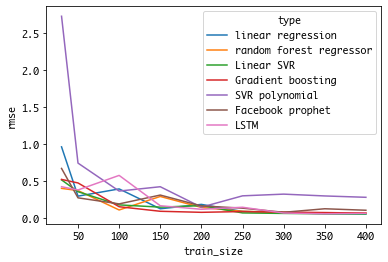

In [46]:
# Plot the training size
sns.lineplot(data=df_plot_rmse,x='train_size',y='rmse',hue='type')

### Optimising model of each algorithm
Here, we are going to go through and look to optimise the model for each algorithm before we finalise its usage.

We are going to reference the old data and then compare to see that there is an improvement in performance so that we can finalise the parameters to use and select the most optimal model to use.

Algorithms tested:
- Linear regression (no optimisation)
- Random forest regressor
- SVM (SVR)
- Gradient boosting regression
- SVR (poly)
- Facebook prophet
- LSTM

Output of this section is to plot and see the optimal test results.

Note, for these data that we tested, we are using the third data point. This means that it is using the 3rd train test set based on the lag value from granger causality.

In [97]:
# Previously trained data performance. Aim to achieve better performance
# NOTE, this data is based on the last point as well with might have different training size?
df_optimise_rmse = df_plot_rmse[df_plot_rmse.train_size == 200]
df_optimise_rmse

,train_size,type,rmse
0,200,linear regression,0.18567
0,200,random forest regressor,0.144433
0,200,Linear SVR,0.169136
0,200,Gradient boosting,0.078591
0,200,SVR polynomial,0.148033
0,200,Facebook prophet,0.164841
0,200,LSTM,0.119643


In [145]:
# Create the train test split with the new train_size
train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)

# Create the train test data output
train_x, train_y, test_x, test_y, df_test_y = clean_train_test_data(train_test1, data_index = 2)

200


0it [00:00, ?it/s]

In [430]:
lag_data_col

,lag_value,col
8,10.0,[DELTA_ma30]
7,9.0,"[DELTA_ema30, DELTA_ema10]"
6,8.0,"[TEAM_rsi14, DELTA_ema50]"
5,7.0,[DELTA_ma50]
4,6.0,[DELTA_VOLUME]
3,5.0,[SMT_VOLUME]
2,4.0,"[DELTA_LOW, DELTA_OPEN, DELTA_gg_trends, top1_..."
1,3.0,"[SMT_ema30, CCET_VOLUME, SMT_ema10, SMT_ema50,..."
0,2.0,"[DELTA_HIGH, SVI_ma30, SVI_OPEN, HANA_ma30, HA..."


In [555]:
train_test1

[[10,
              DELTA_ma30
  2020-12-06  184.450000
  2020-12-08  184.450000
  2020-12-09  185.283333
  2020-12-13  186.983333
  2020-12-14  186.983333
  ...                ...
  2021-07-11  551.133333
  2021-07-12  552.600000
  2021-07-13  552.600000
  2021-07-14  552.600000
  2021-07-15  554.200000
  
  [200 rows x 1 columns],
              DELTA_ma30
  2021-07-16  556.466667
  2021-07-17  558.533333
  2021-07-18  558.733333
  2021-07-19  560.200000
  2021-07-20  560.200000
  2021-07-21  560.200000
  2021-07-22  561.866667
  2021-07-23  562.066667
  2021-07-24  561.600000
  2021-07-25  564.200000
  2021-07-26  564.866667
  2021-07-27  564.866667
  2021-07-28  564.866667
  2021-07-29  564.666667
  2021-07-30  564.400000
  2021-07-31  564.133333
  2021-08-01  564.400000
  2021-08-02  564.800000
  2021-08-03  564.800000
  2021-08-04  564.800000
  2021-08-05  564.800000
  2021-08-06  564.933333
  2021-08-07  564.933333
  2021-08-08  565.733333
  2021-08-09  567.400000
  2021-08-10  5

RMSE Linear regression: 2.911870829523653
RMSE random forest regressor: 1.3173005828146616
RMSE random forest regressor: 1.3243463666134316
RMSE random forest regressor: 1.317171719573031
RMSE Linear SVR: 1.1146774261614016


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/svm/_base.py:985: Convergence

RMSE Linear SVR: 0.8498115706997522
RMSE gradient boosting: 1.3235989618538873


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 1.4366655269812467
RMSE SVR polynomial: 0.5669289729651661
RMSE SVR polynomial: 0.7161727040606687
RMSE SVR polynomial: 0.3517929864373682
RMSE SVR polynomial: 0.5690841047008592
RMSE SVR polynomial: 0.3511618017646763
Initial log joint probability = -6.21193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       253.023     0.0210935       106.128    0.000217       0.001       93  LS failed, Hessian reset 
      68       253.656   6.62648e-05       57.8289   1.152e-06       0.001      163  LS failed, Hessian reset 
      96       253.702   0.000585428       71.8124    7.28e-06       0.001      231  LS failed, Hessian reset 
      99       253.713   0.000127984         54.16           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       253.725   2.40416e-05       64.0527   3.387e-07       0.001      358  LS failed, Hessian reset 
 

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Facebook Prophet: 0.6601500239461178
Initial log joint probability = -6.21193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       538.477    0.00472755       402.009           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       559.762    0.00140382       315.417           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       570.849     0.0066086       495.039           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       583.097     0.0105263       516.686           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       590.151   0.000259304       326.116      0.4193      0.9568      560   
    Iter      log prob

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 1.5647988894259952
Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.3140
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1377
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0266
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0243
RMSE LSTM: 0.5264786622265378
Epoch 1/10
40/40 [==============================] - 2s 2ms/step - loss: 0.2837
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.0740

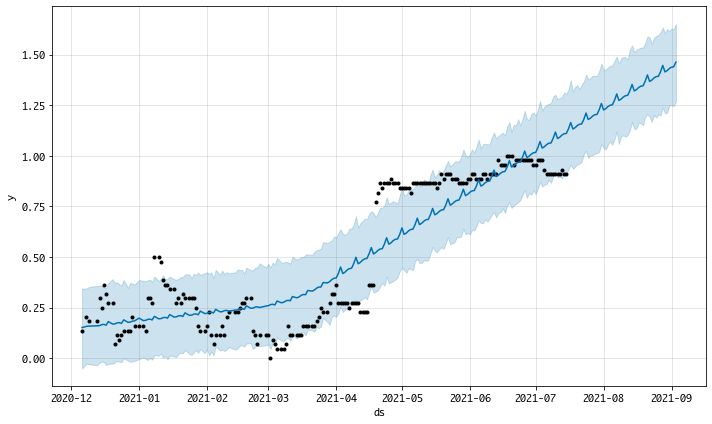

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


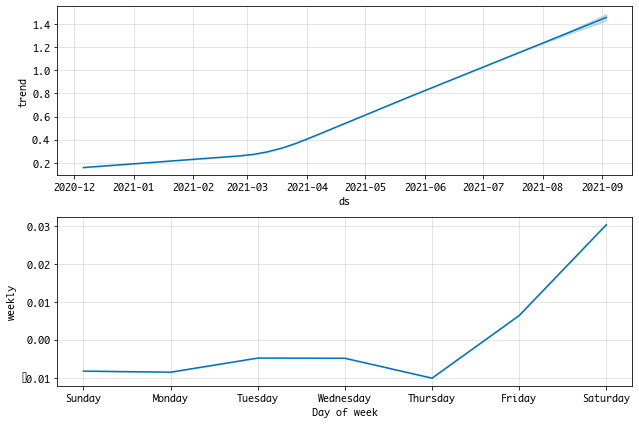

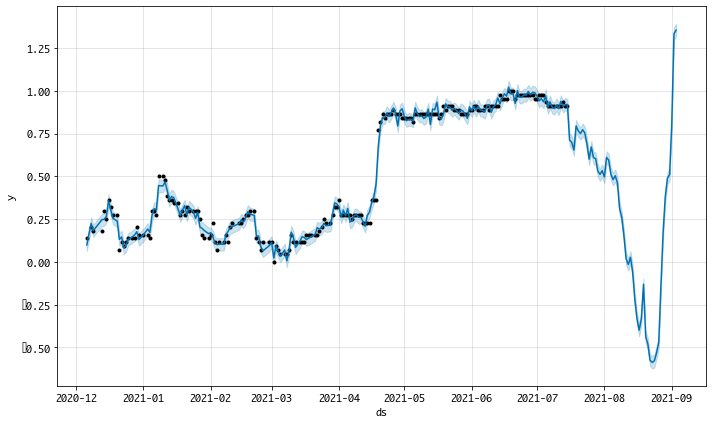

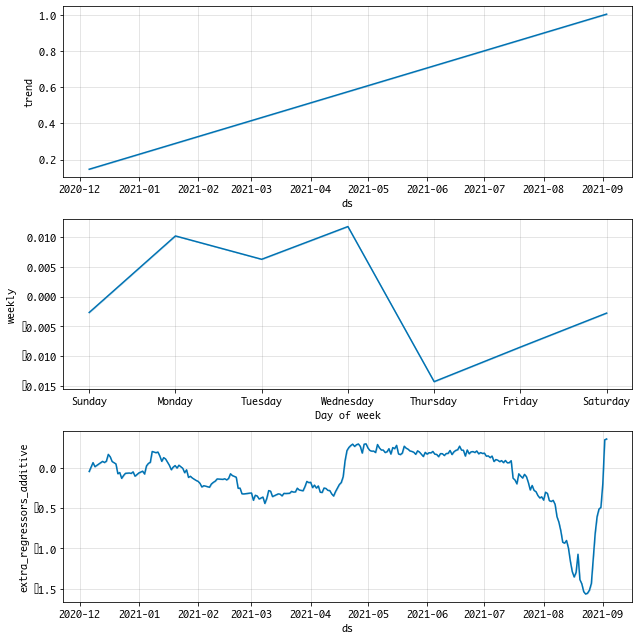

In [556]:
########## Linear Regression ##########
# Linear regression model and prediction (no extra optimisation)
lin_reg = LinearRegression().fit(train_x,train_y)
pred_lin_reg = lin_reg.predict(test_x)
df_pred_lin_reg = pd.DataFrame(pred_lin_reg).rename(columns={0:'pred'})
rmse_lin_reg = mean_squared_error(df_pred_lin_reg['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Linear regression:',rmse_lin_reg)

########## Random forest regressor ##########
# Random Forest regressor training and testing
randf_reg1 = RandomForestRegressor(max_depth=2, random_state=0)
randf_reg1.fit(train_x,train_y)
pred_randf1 = randf_reg1.predict(test_x)
df_pred_randf1 = pd.DataFrame(pred_randf1).rename(columns={0:'pred'})
rmse_randf1 = mean_squared_error(df_pred_randf1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE random forest regressor:',rmse_randf1)

randf_reg2 = RandomForestRegressor(n_estimators=100, min_samples_leaf= 1, max_depth= 5,random_state=0)
randf_reg2.fit(train_x,train_y)
pred_randf2 = randf_reg2.predict(test_x)
df_pred_randf2 = pd.DataFrame(pred_randf2).rename(columns={0:'pred'})
rmse_randf2 = mean_squared_error(df_pred_randf2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE random forest regressor:',rmse_randf2)

randf_params = {'max_depth':[5,10,15],'n_estimators':[50,100,200],'min_samples_leaf':[1,2,5]}
randf_reg3 = RandomizedSearchCV(estimator= RandomForestRegressor(random_state=0,criterion='mse'),param_distributions=randf_params,cv=5)
randf_reg3.fit(train_x,train_y)
randf_reg3 = randf_reg3.best_estimator_
pred_randf3 = randf_reg3.predict(test_x)
df_pred_randf3 = pd.DataFrame(pred_randf3).rename(columns={0:'pred'})
rmse_randf3 = mean_squared_error(df_pred_randf3['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE random forest regressor:',rmse_randf3)

########## Linear SVR ##########
# Linear SVR training and testing
lin_svr_regr1 = LinearSVR(random_state=0, tol=1e-5)
lin_svr_regr1.fit(train_x, train_y)
pred_lin_svr1 = lin_svr_regr1.predict(test_x)
df_pred_svr1 = pd.DataFrame(pred_lin_svr1).rename(columns={0:'pred'})
rmse_lin_svr1 = mean_squared_error(df_pred_svr1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Linear SVR:',rmse_lin_svr1)

svr_params = {'C':[1,3,5,10,20], 'epsilon':[0.05 ,0.1,0.2,0.3,0.4,0.5]}
lin_svr_regr2 = RandomizedSearchCV(estimator= LinearSVR(random_state=0, tol=1e-5),param_distributions=svr_params,cv=10)
lin_svr_regr2.fit(train_x,train_y)
lin_svr_regr2 = lin_svr_regr2.best_estimator_
pred_lin_svr2 = lin_svr_regr2.predict(test_x)
df_pred_lin_svr2 = pd.DataFrame(pred_lin_svr2).rename(columns={0:'pred'})
rmse_lin_svr2 = mean_squared_error(df_pred_lin_svr2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Linear SVR:',rmse_lin_svr2)

########## Gradient boosting regressor ##########
# Gradient boosting regressor training and testing
grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
grad_bst_regr1.fit(train_x, train_y)
pred_grad_bst1 = grad_bst_regr1.predict(test_x)
df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})
rmse_grad_bst1 = mean_squared_error(df_pred_grad_bst1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE gradient boosting:',rmse_grad_bst1)

gradient_params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[5,10,15],'n_estimators':[50,100,200,500],'min_samples_leaf':[1,2,5]}
grad_bst_regr2 = RandomizedSearchCV(estimator= GradientBoostingRegressor(random_state=0,criterion='mse'),param_distributions=gradient_params,cv=10,n_iter=20)
grad_bst_regr2.fit(train_x,train_y)
grad_bst_regr2 = grad_bst_regr2.best_estimator_
pred_grad_bst2 = grad_bst_regr2.predict(test_x)
df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})
rmse_grad_bst2 = mean_squared_error(df_pred_grad_bst2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE gradient boosting:',rmse_grad_bst2)

########## SVR (polynomial) ##########
# SVR polynomial training and testing
svr_poly_regr1 = svm.SVR(kernel = 'poly') 
svr_poly_regr1.fit(train_x, train_y)
pred_svr_poly1 = svr_poly_regr1.predict(test_x)
df_pred_svr_poly1 = pd.DataFrame(pred_svr_poly1).rename(columns={0:'pred'})
rmse_svr_poly1 = mean_squared_error(df_pred_svr_poly1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE SVR polynomial:',rmse_svr_poly1)

svr_poly_regr2 = svm.SVR(kernel = 'poly', C=1, epsilon = 0.05) 
svr_poly_regr2.fit(train_x, train_y)
pred_svr_poly2 = svr_poly_regr2.predict(test_x)
df_pred_svr_poly2 = pd.DataFrame(pred_svr_poly2).rename(columns={0:'pred'})
rmse_svr_poly2 = mean_squared_error(df_pred_svr_poly2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE SVR polynomial:',rmse_svr_poly2)

svr_poly_regr3 = svm.SVR(kernel='poly',degree=2, coef0=0,C=3)
svr_poly_regr3.fit(train_x, train_y)
pred_svr_poly3 = svr_poly_regr3.predict(test_x)
df_pred_svr_poly3 = pd.DataFrame(pred_svr_poly3).rename(columns={0:'pred'})
rmse_svr_poly3 = mean_squared_error(df_pred_svr_poly3['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE SVR polynomial:',rmse_svr_poly3)

svr_poly_regr4 = svm.SVR(kernel = 'poly', C=3, epsilon = 0.2, degree=2) 
svr_poly_regr4.fit(train_x, train_y)
pred_svr_poly4 = svr_poly_regr4.predict(test_x)
df_pred_svr_poly4 = pd.DataFrame(pred_svr_poly4).rename(columns={0:'pred'})
rmse_svr_poly4 = mean_squared_error(df_pred_svr_poly4['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE SVR polynomial:',rmse_svr_poly4)

svr_poly_regr5 = svm.SVR(kernel = 'poly', C=5, epsilon = 0.1, degree=2) 
svr_poly_regr5.fit(train_x, train_y)
pred_svr_poly5 = svr_poly_regr5.predict(test_x)
df_pred_svr_poly5 = pd.DataFrame(pred_svr_poly5).rename(columns={0:'pred'})
rmse_svr_poly5 = mean_squared_error(df_pred_svr_poly5['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE SVR polynomial:',rmse_svr_poly5)

########## Facebook prophet ##########
# Update dataset to match Facebook prophet usage protocol
temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

# Facebook prophet training and testing
model_prophet1 = Prophet()
model_prophet1.fit(temp_prophet_df)
future1 = model_prophet1.make_future_dataframe(periods=len(test_x))
forecast_prophet1 = model_prophet1.predict(future1)
model_prophet1.plot(forecast_prophet1)
model_prophet1.plot_components(forecast_prophet1)
df_pred_prophet1 = pd.DataFrame(forecast_prophet1['yhat'][-test_size:]).rename(columns={0:'pred'})
rmse_prophet1 = mean_squared_error(df_pred_prophet1['yhat'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Facebook Prophet:',rmse_prophet1)

model_prophet2 = Prophet()
for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        model_prophet2.add_regressor(col)
model_prophet2.fit(temp_prophet_df)
future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        df_aggresor = pd.concat([train_x[col], test_x[col]]).reset_index().drop('index',axis=1)
        future2 = pd.concat([future2, df_aggresor],axis=1)
forecast_prophet2 = model_prophet2.predict(future2)
model_prophet2.plot(forecast_prophet2)
model_prophet2.plot_components(forecast_prophet2)
df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat'][-test_size:]).rename(columns={0:'pred'})
rmse_prophet2 = mean_squared_error(df_pred_prophet2['yhat'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Facebook Prophet:',rmse_prophet2)

########## LSTM (Long Short Term Memory) ##########
# Setup the data shape accordingly for LSTM
X = np.array(train_x)
train_x2 = X.reshape(X.shape[0],1,X.shape[1])
X2 = np.array(test_x)
test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm1 = Sequential()
model_lstm1.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm1.add(Dense(1))
model_lstm1.compile(optimizer='adam', loss='mse')
model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
pred_lstm1 = model_lstm1.predict(test_x2)
pred_lstm1 = pred_lstm1.reshape(-1)
df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})
rmse_lstm1 = mean_squared_error(df_pred_lstm1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm1)


# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# Dropout layer added to avoid overfit
# Add output layer
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm2 = Sequential()
model_lstm2.add(LSTM(30, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(Dense(1))
model_lstm2.compile(optimizer='adam', loss='mse')
model_lstm2.fit(train_x2,train_y,epochs=10,batch_size=5)
pred_lstm2 = model_lstm2.predict(test_x2)
pred_lstm2 = pred_lstm2.reshape(-1)
df_pred_lstm2 = pd.DataFrame(pred_lstm2).rename(columns={0:'pred'})
rmse_lstm2 = mean_squared_error(df_pred_lstm2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm2)

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# Dropout layer added to avoid overfit
# Add output layer
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm3 = Sequential()
model_lstm3.add(LSTM(40, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm3.add(Dropout(0.1))
model_lstm3.add(LSTM(40, activation='relu', return_sequences=True))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(1))
model_lstm3.compile(optimizer='adam', loss='mse')
model_lstm3.fit(train_x2,train_y,epochs=15,batch_size=20)
pred_lstm3 = model_lstm3.predict(test_x2)
pred_lstm3 = pred_lstm3.reshape(-1)
df_pred_lstm3 = pd.DataFrame(pred_lstm3).rename(columns={0:'pred'})
rmse_lstm3 = mean_squared_error(df_pred_lstm3['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm3)

In [452]:
stock_all_data_list = []
stock_all_data_list.append([stock_symbol_list[0],stock_all_data1])
stock_all_data_list.append([stock_symbol_list[1],stock_all_data2])
stock_all_data_list.append([stock_symbol_list[2],stock_all_data3])
stock_all_data_list.append([stock_symbol_list[3],stock_all_data4])

In [536]:
# Set path name and check if it exists then read from file otherwise run code
set_rmse_filepath = Path('./20210904_rmse_feature_table.csv')
if set_rmse_filepath.is_file():
    print('File already exist....load data instead.')
    df_rmse_feature_table = pd.read_csv('20210904_rmse_feature_table.csv')
else:
    print('File does not exist....creatingn rmse table...this might take awhile ~ 40mins')
    
    # Create the table for RMSE scoring
    df_rmse_feature_table = pd.DataFrame()

    # Loop for the data for each stock in the list for testing
    for stock_all_data in tqdm(stock_all_data_list):
        
        # Create train test and prediction data sets for usage
        train_test, train_pred = create_train_test_predict_split_with_granger(stock_all_data[1], train_size = 200, test_size = 50)

        # Run loop for each dataset information for process prediction
        for data_index in tqdm(range(0,len(train_test))):
            
            # Clean the dataset for the specific train_test case
            train_x, train_y, test_x, test_y, df_test_y = clean_train_test_data(train_test,stock_all_data[0] + '_CLOSE', data_index = data_index)

            print('stock:',stock_all_data[0])
            print('data_index:',data_index)
            print('lag value in train_test',train_test[data_index][0])
            
            # Set the stock symbol to use and loop
            stock_symbol_close = stock_all_data[0] + '_CLOSE'

            ########## Linear Regression ##########
            # Linear regression model and prediction (no extra optimisation)
            lin_reg = LinearRegression().fit(train_x,train_y)
            pred_lin_reg = lin_reg.predict(test_x)
            df_pred_lin_reg = pd.DataFrame(pred_lin_reg).rename(columns={0:'pred'})
            rmse_lin_reg = mean_squared_error(df_pred_lin_reg['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE Linear regression:',rmse_lin_reg)

            ########## Random forest regressor ##########
            # Random Forest regressor training and testing
            randf_reg1 = RandomForestRegressor(max_depth=2, random_state=0)
            randf_reg1.fit(train_x,train_y)
            pred_randf1 = randf_reg1.predict(test_x)
            df_pred_randf1 = pd.DataFrame(pred_randf1).rename(columns={0:'pred'})
            rmse_randf1 = mean_squared_error(df_pred_randf1['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE random forest regressor:',rmse_randf1)

            randf_reg2 = RandomForestRegressor(n_estimators=100, min_samples_leaf= 1, max_depth= 5,random_state=0)
            randf_reg2.fit(train_x,train_y)
            pred_randf2 = randf_reg2.predict(test_x)
            df_pred_randf2 = pd.DataFrame(pred_randf2).rename(columns={0:'pred'})
            rmse_randf2 = mean_squared_error(df_pred_randf2['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE random forest regressor:',rmse_randf2)

            randf_params = {'max_depth':[5,10,15],'n_estimators':[50,100,200],'min_samples_leaf':[1,2,5]}
            randf_reg3 = RandomizedSearchCV(estimator= RandomForestRegressor(random_state=0,criterion='mse'),param_distributions=randf_params,cv=5)
            randf_reg3.fit(train_x,train_y)
            randf_reg3 = randf_reg3.best_estimator_
            pred_randf3 = randf_reg3.predict(test_x)
            df_pred_randf3 = pd.DataFrame(pred_randf3).rename(columns={0:'pred'})
            rmse_randf3 = mean_squared_error(df_pred_randf3['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE random forest regressor:',rmse_randf3)

            ########## Linear SVR ##########
            # Linear SVR training and testing
            lin_svr_regr1 = LinearSVR(random_state=0, tol=1e-5)
            lin_svr_regr1.fit(train_x, train_y)
            pred_lin_svr1 = lin_svr_regr1.predict(test_x)
            df_pred_svr1 = pd.DataFrame(pred_lin_svr1).rename(columns={0:'pred'})
            rmse_lin_svr1 = mean_squared_error(df_pred_svr1['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE Linear SVR:',rmse_lin_svr1)

            svr_params = {'C':[1,3,5,10,20], 'epsilon':[0.05 ,0.1,0.2,0.3,0.4,0.5]}
            lin_svr_regr2 = RandomizedSearchCV(estimator= LinearSVR(random_state=0, tol=1e-5),param_distributions=svr_params,cv=10)
            lin_svr_regr2.fit(train_x,train_y)
            lin_svr_regr2 = lin_svr_regr2.best_estimator_
            pred_lin_svr2 = lin_svr_regr2.predict(test_x)
            df_pred_lin_svr2 = pd.DataFrame(pred_lin_svr2).rename(columns={0:'pred'})
            rmse_lin_svr2 = mean_squared_error(df_pred_lin_svr2['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE Linear SVR:',rmse_lin_svr2)

            ########## Gradient boosting regressor ##########
            # Gradient boosting regressor training and testing
            grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
            grad_bst_regr1.fit(train_x, train_y)
            pred_grad_bst1 = grad_bst_regr1.predict(test_x)
            df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})
            rmse_grad_bst1 = mean_squared_error(df_pred_grad_bst1['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE gradient boosting:',rmse_grad_bst1)

            gradient_params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[5,10,15],'n_estimators':[50,100,200,500],'min_samples_leaf':[1,2,5]}
            grad_bst_regr2 = RandomizedSearchCV(estimator= GradientBoostingRegressor(random_state=0,criterion='mse'),param_distributions=gradient_params,cv=10,n_iter=20)
            grad_bst_regr2.fit(train_x,train_y)
            grad_bst_regr2 = grad_bst_regr2.best_estimator_
            pred_grad_bst2 = grad_bst_regr2.predict(test_x)
            df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})
            rmse_grad_bst2 = mean_squared_error(df_pred_grad_bst2['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE gradient boosting:',rmse_grad_bst2)

            ########## SVR (polynomial) ##########
            # SVR polynomial training and testing
            svr_poly_regr1 = svm.SVR(kernel = 'poly') 
            svr_poly_regr1.fit(train_x, train_y)
            pred_svr_poly1 = svr_poly_regr1.predict(test_x)
            df_pred_svr_poly1 = pd.DataFrame(pred_svr_poly1).rename(columns={0:'pred'})
            rmse_svr_poly1 = mean_squared_error(df_pred_svr_poly1['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE SVR polynomial:',rmse_svr_poly1)

            svr_poly_regr2 = svm.SVR(kernel = 'poly', C=1, epsilon = 0.05) 
            svr_poly_regr2.fit(train_x, train_y)
            pred_svr_poly2 = svr_poly_regr2.predict(test_x)
            df_pred_svr_poly2 = pd.DataFrame(pred_svr_poly2).rename(columns={0:'pred'})
            rmse_svr_poly2 = mean_squared_error(df_pred_svr_poly2['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE SVR polynomial:',rmse_svr_poly2)

            svr_poly_regr3 = svm.SVR(kernel='poly',degree=2, coef0=0,C=3)
            svr_poly_regr3.fit(train_x, train_y)
            pred_svr_poly3 = svr_poly_regr3.predict(test_x)
            df_pred_svr_poly3 = pd.DataFrame(pred_svr_poly3).rename(columns={0:'pred'})
            rmse_svr_poly3 = mean_squared_error(df_pred_svr_poly3['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE SVR polynomial:',rmse_svr_poly3)

            svr_poly_regr4 = svm.SVR(kernel = 'poly', C=3, epsilon = 0.2, degree=2) 
            svr_poly_regr4.fit(train_x, train_y)
            pred_svr_poly4 = svr_poly_regr4.predict(test_x)
            df_pred_svr_poly4 = pd.DataFrame(pred_svr_poly4).rename(columns={0:'pred'})
            rmse_svr_poly4 = mean_squared_error(df_pred_svr_poly4['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE SVR polynomial:',rmse_svr_poly4)

            svr_poly_regr5 = svm.SVR(kernel = 'poly', C=5, epsilon = 0.1, degree=2) 
            svr_poly_regr5.fit(train_x, train_y)
            pred_svr_poly5 = svr_poly_regr5.predict(test_x)
            df_pred_svr_poly5 = pd.DataFrame(pred_svr_poly5).rename(columns={0:'pred'})
            rmse_svr_poly5 = mean_squared_error(df_pred_svr_poly5['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE SVR polynomial:',rmse_svr_poly5)

            ########## Facebook prophet ##########
            # Update dataset to match Facebook prophet usage protocol
            temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

            # Facebook prophet training and testing
            model_prophet1 = Prophet()
            model_prophet1.fit(temp_prophet_df)
            future1 = model_prophet1.make_future_dataframe(periods=len(test_x))
            forecast_prophet1 = model_prophet1.predict(future1)
            model_prophet1.plot(forecast_prophet1)
            model_prophet1.plot_components(forecast_prophet1)
            df_pred_prophet1 = pd.DataFrame(forecast_prophet1['yhat'][-test_size:]).rename(columns={0:'pred'})
            rmse_prophet1 = mean_squared_error(df_pred_prophet1['yhat'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE Facebook Prophet:',rmse_prophet1)

            model_prophet2 = Prophet()
            for col in temp_prophet_df.columns:
                if col not in ('y','ds'):
                    model_prophet2.add_regressor(col)
            model_prophet2.fit(temp_prophet_df)
            future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
            for col in temp_prophet_df.columns:
                if col not in ('y','ds'):
                    df_aggresor = pd.concat([train_x[col], test_x[col]]).reset_index().drop('index',axis=1)
                    future2 = pd.concat([future2, df_aggresor],axis=1)
            forecast_prophet2 = model_prophet2.predict(future2)
            model_prophet2.plot(forecast_prophet2)
            model_prophet2.plot_components(forecast_prophet2)
            df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat'][-test_size:]).rename(columns={0:'pred'})
            rmse_prophet2 = mean_squared_error(df_pred_prophet2['yhat'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE Facebook Prophet:',rmse_prophet2)

            ########## LSTM (Long Short Term Memory) ##########
            # Setup the data shape accordingly for LSTM
            X = np.array(train_x)
            train_x2 = X.reshape(X.shape[0],1,X.shape[1])
            X2 = np.array(test_x)
            test_x2 = X2.reshape(X2.shape[0],1,X2.shape[1])

            # Instantiate LSTM
            # Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
            # epoch number times to run data in
            # Input is 3d so need to reshape
            model_lstm1 = Sequential()
            model_lstm1.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
            model_lstm1.add(Dense(1))
            model_lstm1.compile(optimizer='adam', loss='mse')
            model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
            pred_lstm1 = model_lstm1.predict(test_x2)
            pred_lstm1 = pred_lstm1.reshape(-1)
            df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})
            rmse_lstm1 = mean_squared_error(df_pred_lstm1['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE LSTM:',rmse_lstm1)

            # Instantiate LSTM
            # Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
            # Dropout layer added to avoid overfit
            # Add output layer
            # epoch number times to run data in
            # Input is 3d so need to reshape
            model_lstm2 = Sequential()
            model_lstm2.add(LSTM(30, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
            model_lstm2.add(Dropout(0.1))
            model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
            model_lstm2.add(Dropout(0.1))
            model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
            model_lstm2.add(Dropout(0.1))
            model_lstm2.add(Dense(1))
            model_lstm2.compile(optimizer='adam', loss='mse')
            model_lstm2.fit(train_x2,train_y,epochs=10,batch_size=5)
            pred_lstm2 = model_lstm2.predict(test_x2)
            pred_lstm2 = pred_lstm2.reshape(-1)
            df_pred_lstm2 = pd.DataFrame(pred_lstm2).rename(columns={0:'pred'})
            rmse_lstm2 = mean_squared_error(df_pred_lstm2['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE LSTM:',rmse_lstm2)

            # Instantiate LSTM
            # Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
            # Dropout layer added to avoid overfit
            # Add output layer
            # epoch number times to run data in
            # Input is 3d so need to reshape
            model_lstm3 = Sequential()
            model_lstm3.add(LSTM(40, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
            model_lstm3.add(Dropout(0.1))
            model_lstm3.add(LSTM(40, activation='relu', return_sequences=True))
            model_lstm3.add(Dropout(0.2))
            model_lstm3.add(Dense(1))
            model_lstm3.compile(optimizer='adam', loss='mse')
            model_lstm3.fit(train_x2,train_y,epochs=15,batch_size=20)
            pred_lstm3 = model_lstm3.predict(test_x2)
            pred_lstm3 = pred_lstm3.reshape(-1)
            df_pred_lstm3 = pd.DataFrame(pred_lstm3).rename(columns={0:'pred'})
            rmse_lstm3 = mean_squared_error(df_pred_lstm3['pred'],df_test_y[stock_symbol_close], squared=False)
            print('RMSE LSTM:',rmse_lstm3)

            # Create temp list to create rmse data table
            list_temp = []
            list_temp.append(('lag_' + str(train_test[data_index][0]) + '_' + stock_all_data[0]))
            list_temp.append(rmse_lin_reg)
            list_temp.append(rmse_randf1)
            list_temp.append(rmse_randf2)
            list_temp.append(rmse_randf3)
            list_temp.append(rmse_lin_svr1)
            list_temp.append(rmse_lin_svr2)
            list_temp.append(rmse_grad_bst1)
            list_temp.append(rmse_grad_bst2)
            list_temp.append(rmse_svr_poly1)
            list_temp.append(rmse_svr_poly2)
            list_temp.append(rmse_svr_poly3)
            list_temp.append(rmse_svr_poly4)
            list_temp.append(rmse_svr_poly5)
            list_temp.append(rmse_prophet1)
            list_temp.append(rmse_prophet2)
            list_temp.append(rmse_lstm1)
            list_temp.append(rmse_lstm2)
            list_temp.append(rmse_lstm3)

            df_rmse_feature_table = pd.concat([df_rmse_feature_table, pd.DataFrame(list_temp).transpose()])

    # Set the rmse column names and table
    col_names = ['data','lin_reg','randf1','randf2','randf3'
        ,'lin_svr1','lin_svr2','grad_bst1','grad_bst2','svr_poly1'
        ,'svr_poly2','svr_poly3','svr_poly4','svr_poly5','prophet1'
        ,'prophet2','lstm1','lstm2','lstm3']
    df_rmse_feature_table.columns = col_names
    df_rmse_feature_table
    
    # Save file as csv to not need to rerun data again
    df_rmse_feature_table.to_csv('20210904_rmse_feature_table.csv',index=False)
    

File already exist....load data instead.


In [699]:
df_rmse_feature_table

,data,lin_reg,randf1,randf2,randf3,lin_svr1,lin_svr2,grad_bst1,grad_bst2,svr_poly1,svr_poly2,svr_poly3,svr_poly4,svr_poly5,prophet1,prophet2,lstm1,lstm2,lstm3
0,lag_10_DELTA,0.204086,0.250049,0.247647,0.237012,0.121672,0.227532,0.287218,0.273143,0.139958,0.096877,0.148242,0.216314,0.148237,0.164841,0.175478,0.585031,0.199376,0.170039
1,lag_9_DELTA,0.199623,0.148814,0.130924,0.175365,0.152884,0.164938,0.067052,0.198754,0.104519,0.098354,0.172737,0.258888,0.162974,0.164841,0.123381,0.514554,0.107165,0.120001
2,lag_8_DELTA,0.185670,0.144433,0.127165,0.127165,0.169136,0.171206,0.078591,0.246699,0.148033,0.161872,0.087236,0.095855,0.083472,0.164841,0.103765,0.447728,0.117970,0.115452
3,lag_7_DELTA,0.197085,0.144433,0.128578,0.141692,0.182381,0.168344,0.084535,0.068998,0.341580,0.252231,0.125343,0.088007,0.143683,0.164841,0.098374,0.080993,0.157415,0.143221
4,lag_6_DELTA,0.184795,0.143754,0.135997,0.126046,0.186625,0.179289,0.089214,0.069926,0.213329,0.186485,0.112881,0.160528,0.118103,0.164841,0.091679,0.333444,0.136792,0.129790
5,lag_5_DELTA,0.187792,0.137556,0.142927,0.151730,0.189196,0.146782,0.088290,0.061053,0.213370,0.161351,0.139706,0.187144,0.139378,0.164841,0.094073,0.373033,0.226876,0.120013
6,lag_4_DELTA,0.136462,0.088846,0.082755,0.087905,0.117577,0.113864,0.093708,0.090982,0.179345,0.129982,0.100466,0.151718,0.124601,0.164841,0.072945,0.409466,0.138581,0.093968
7,lag_3_DELTA,0.166079,0.093244,0.077955,0.085539,0.094703,0.077603,0.108042,0.099794,0.461767,0.246063,0.344601,0.120552,0.354064,0.164841,0.100878,0.211569,0.086891,0.076550
8,lag_2_DELTA,0.272696,0.097860,0.077849,0.082387,0.073392,0.070921,0.114392,0.094390,0.099028,0.155917,0.077052,0.177607,0.079845,0.164841,0.109955,0.093995,0.083988,0.073591
9,lag_10_KCE,0.564652,0.501399,0.536502,0.558798,0.599335,0.600387,0.525901,0.559158,0.561160,0.583835,0.571346,0.512254,0.571295,0.091972,0.088553,0.955568,0.569903,0.581384


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


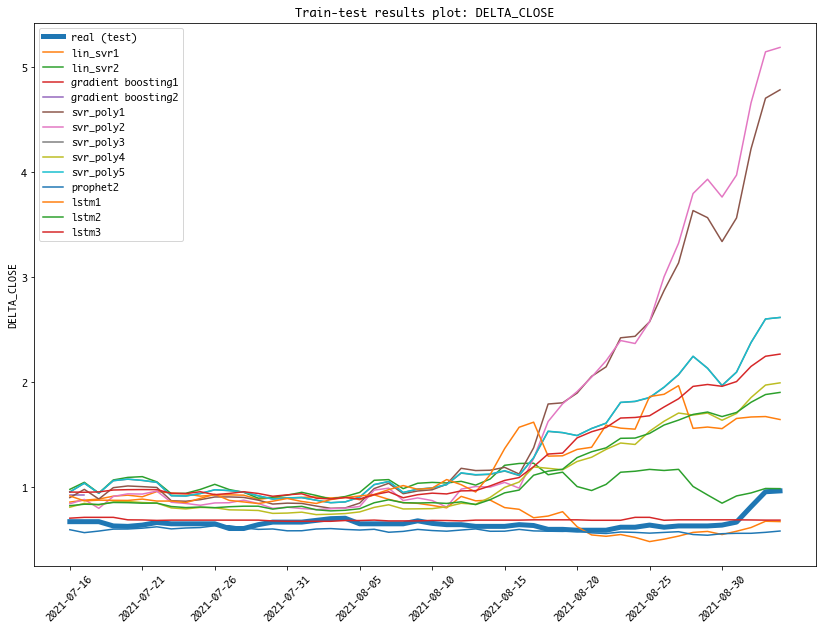

In [714]:
# Set the index of prophet to be the same as others
# df_pred_prophet.index = df_pred_linreg.index

# Plot results to visualise output
plt.figure(figsize=(14,10))
sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='real (test)', linewidth = 5)
# sns.lineplot(data=df_pred_linreg, x = df_pred_linreg.index, y='pred', label='linear_reg')
# sns.lineplot(data=df_pred_randf1, x = df_pred_randf1.index, y='pred', label='randomforest_reg1')
# sns.lineplot(data=df_pred_randf2, x = df_pred_randf2.index, y='pred', label='randomforest_reg2')
# sns.lineplot(data=df_pred_randf3, x = df_pred_randf3.index, y='pred', label='randomforest_reg3')
sns.lineplot(data=df_pred_svr1, x = df_pred_svr1.index, y='pred', label='lin_svr1')
sns.lineplot(data=df_pred_lin_svr2, x = df_pred_lin_svr2.index, y='pred', label='lin_svr2')
sns.lineplot(data=df_pred_grad_bst1, x = df_pred_grad_bst1.index, y='pred', label='gradient boosting1')
sns.lineplot(data=df_pred_grad_bst2, x = df_pred_grad_bst2.index, y='pred', label='gradient boosting2')
sns.lineplot(data=df_pred_svr_poly1, x = df_pred_svr_poly1.index, y='pred', label='svr_poly1')
sns.lineplot(data=df_pred_svr_poly2, x = df_pred_svr_poly2.index, y='pred', label='svr_poly2')
sns.lineplot(data=df_pred_svr_poly3, x = df_pred_svr_poly3.index, y='pred', label='svr_poly3')
sns.lineplot(data=df_pred_svr_poly4, x = df_pred_svr_poly4.index, y='pred', label='svr_poly4')
sns.lineplot(data=df_pred_svr_poly5, x = df_pred_svr_poly5.index, y='pred', label='svr_poly5')
# sns.lineplot(data=df_pred_prophet1, x = df_pred_prophet1.index, y='yhat', label='prophet1')
sns.lineplot(data=df_pred_prophet2, x = df_pred_prophet2.index, y='pred', label='prophet2')
sns.lineplot(data=df_pred_lstm1, x = df_pred_lstm1.index, y='pred', label='lstm1')
sns.lineplot(data=df_pred_lstm2, x = df_pred_lstm2.index, y='pred', label='lstm2')
sns.lineplot(data=df_pred_lstm3, x = df_pred_lstm3.index, y='pred', label='lstm3')
plt.xticks(np.arange(0, test_size, step=5),rotation=45)
plt.title('Train-test results plot: ' + stock_symbol_close)
plt.show()

In [708]:
forecast_prophet2['yhat']

0      0.283178
1      0.301676
2      0.317638
3      0.313764
4      0.332004
         ...   
245    0.555348
246    0.559022
247    0.559265
248    0.568448
249    0.580879
Name: yhat, Length: 250, dtype: float64

### Conclude optimise performance
Here, we can conlcude about the performance and model to choose based on the RMSE data table that we created.
Based on this table, we have explored multiple cases. As we can see, if we scope the RMSE less than 0.08, there is a lot of low value grouped in lag_2_delta. Due the the fact that it is lagging by 2 days, or 2 data points, so the data here may be overfitted so we should aim for models around 5-8 lag points.

In this case, we further scope down and can see that the most optimal model is grad_bst2. This is the gradient boosting regressor model with radomized search.

This would be a good model because it create trees and the data is based on the previous value, which is like how stocks work as it depends on the previous value as well for the next.

In [546]:
# Clean index data and then scope data for explore and view
df_rmse_feature_table2 = df_rmse_feature_table.set_index('data')
df_rmse_feature_table2[df_rmse_feature_table2 < 0.08]

,lin_reg,randf1,randf2,randf3,lin_svr1,lin_svr2,grad_bst1,grad_bst2,svr_poly1,svr_poly2,svr_poly3,svr_poly4,svr_poly5,prophet1,prophet2,lstm1,lstm2,lstm3
data,,,,,,,,,,,,,,,,,,
lag_10_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_9_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,0.067052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_8_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,0.078591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_7_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_6_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_5_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lag_4_DELTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072945,NaN,NaN,NaN
lag_3_DELTA,NaN,NaN,0.077955,NaN,NaN,0.077603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076550
lag_2_DELTA,NaN,NaN,0.077849,NaN,0.073392,0.070921,NaN,NaN,NaN,NaN,0.077052,NaN,0.079845,NaN,NaN,NaN,NaN,0.073591


In [558]:
# Scope the data only for the data available
df_rmse_feature_table2[df_rmse_feature_table2 < 0.07].dropna(how='all').dropna(how='all',axis=1)

,grad_bst1,grad_bst2,prophet2
data,,,
lag_9_DELTA,0.067052,NaN,NaN
lag_7_DELTA,NaN,0.068998,NaN
lag_6_DELTA,NaN,0.069926,NaN
lag_5_DELTA,NaN,0.061053,NaN
lag_2_SCB,NaN,NaN,0.058875


## Test optimisation with ensemble model optimisation
As a quick test, what we choose to do is to mix multiple models together to further increase their performance.
The method that is used is through taking the average ofmultiple model predictions and see whether it results in a better performance.

This is based on multiple combinations as shown in the plots.

In [1037]:
lag_data_col

,lag_value,col
8,10.0,[DELTA_ma30]
7,9.0,"[DELTA_ema30, DELTA_ema10]"
6,8.0,"[TEAM_rsi14, DELTA_ema50]"
5,7.0,[DELTA_ma50]
4,6.0,[DELTA_VOLUME]
3,5.0,[SMT_VOLUME]
2,4.0,"[DELTA_LOW, DELTA_OPEN, DELTA_gg_trends, top1_..."
1,3.0,"[SMT_ema30, CCET_VOLUME, SMT_ema10, SMT_ema50,..."
0,2.0,"[DELTA_HIGH, SVI_ma30, SVI_OPEN, HANA_ma30, HA..."


In [907]:
# Set the stock symbol based on stock all data
stock_symbol_close = 'DELTA_CLOSE'

# Create the train test split with the new train_size
train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)

# Create the train test data output
train_x, train_y, test_x, test_y, df_test_y = clean_train_test_data(train_test1,stock_symbol = stock_symbol_close, data_index = 3)

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 0.08453468756558967
RMSE gradient boosting: 0.08534313363613176
Initial log joint probability = -9.85683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       347.086   3.28534e-07       91.8434       1.859      0.1859      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       347.086   7.10059e-09       90.9602      0.2781      0.2781      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 0.09837448716207757
Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.1868
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0885
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0479
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0383
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0307
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0266
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0252
RMSE LSTM: 0.25373175115764246
Epoch 1/10
40/40 [==============================] - 2s 2ms/step - loss: 0.1512
Epoch 2/10
40/40 [==============================] - 0s 2ms/step - loss: 0.04

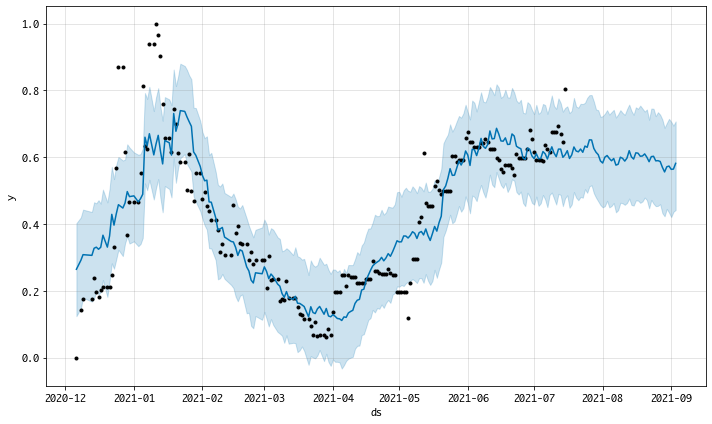

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


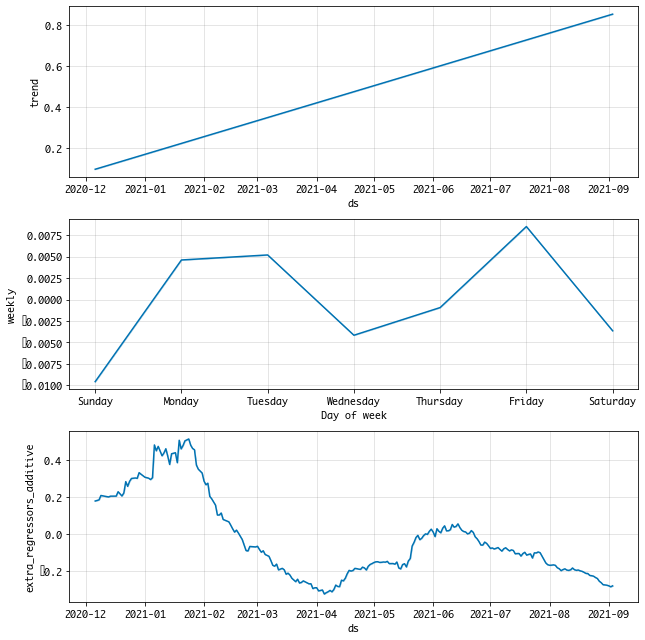

In [908]:
########## Gradient boosting regressor ##########
# Gradient boosting regressor training and testing
grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
grad_bst_regr1.fit(train_x, train_y)
pred_grad_bst1 = grad_bst_regr1.predict(test_x)
df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})
rmse_grad_bst1 = mean_squared_error(df_pred_grad_bst1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE gradient boosting:',rmse_grad_bst1)

gradient_params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[5,10,15],'n_estimators':[50,100,200,500],'min_samples_leaf':[1,2,5]}
grad_bst_regr2 = GradientBoostingRegressor(random_state=0,criterion='mse', learning_rate=0.05, max_depth=5, n_estimators=50)
grad_bst_regr2.fit(train_x,train_y)
pred_grad_bst2 = grad_bst_regr2.predict(test_x)
df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})
rmse_grad_bst2 = mean_squared_error(df_pred_grad_bst2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE gradient boosting:',rmse_grad_bst2)

########## Facebook prophet ##########
# Update dataset to match Facebook prophet usage protocol
temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

model_prophet2 = Prophet()
for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        model_prophet2.add_regressor(col)
model_prophet2.fit(temp_prophet_df)
future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
for col in temp_prophet_df.columns:
    if col not in ('y','ds'):
        df_aggresor = pd.concat([train_x[col], test_x[col]]).reset_index().drop('index',axis=1)
        future2 = pd.concat([future2, df_aggresor],axis=1)
forecast_prophet2 = model_prophet2.predict(future2)
model_prophet2.plot(forecast_prophet2)
model_prophet2.plot_components(forecast_prophet2)
df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat'][-test_size:]).rename(columns={0:'pred'})
rmse_prophet2 = mean_squared_error(df_pred_prophet2['yhat'],df_test_y[stock_symbol_close], squared=False)
print('RMSE Facebook Prophet:',rmse_prophet2)

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm1 = Sequential()
model_lstm1.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm1.add(Dense(1))
model_lstm1.compile(optimizer='adam', loss='mse')
model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
pred_lstm1 = model_lstm1.predict(test_x2)
pred_lstm1 = pred_lstm1.reshape(-1)
df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})
rmse_lstm1 = mean_squared_error(df_pred_lstm1['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm1)

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# Dropout layer added to avoid overfit
# Add output layer
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm2 = Sequential()
model_lstm2.add(LSTM(30, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(LSTM(30, activation='relu', return_sequences=True))
model_lstm2.add(Dropout(0.1))
model_lstm2.add(Dense(1))
model_lstm2.compile(optimizer='adam', loss='mse')
model_lstm2.fit(train_x2,train_y,epochs=10,batch_size=5)
pred_lstm2 = model_lstm2.predict(test_x2)
pred_lstm2 = pred_lstm2.reshape(-1)
df_pred_lstm2 = pd.DataFrame(pred_lstm2).rename(columns={0:'pred'})
rmse_lstm2 = mean_squared_error(df_pred_lstm2['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm2)

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# Dropout layer added to avoid overfit
# Add output layer
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm3 = Sequential()
model_lstm3.add(LSTM(40, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm3.add(Dropout(0.1))
model_lstm3.add(LSTM(40, activation='relu', return_sequences=True))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(1))
model_lstm3.compile(optimizer='adam', loss='mse')
model_lstm3.fit(train_x2,train_y,epochs=15,batch_size=20)
pred_lstm3 = model_lstm3.predict(test_x2)
pred_lstm3 = pred_lstm3.reshape(-1)
df_pred_lstm3 = pd.DataFrame(pred_lstm3).rename(columns={0:'pred'})
rmse_lstm3 = mean_squared_error(df_pred_lstm3['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm3)

# Instantiate LSTM
# Add layer, 30 hidden layers (neurons), reshape accordingly because it takes in 3d
# epoch number times to run data in
# Input is 3d so need to reshape
model_lstm4 = Sequential()
model_lstm4.add(LSTM(15, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
model_lstm4.add(Dense(1))
model_lstm4.compile(optimizer='adam', loss='mse')
model_lstm4.fit(train_x2,train_y,epochs=10,batch_size=30)
pred_lstm4 = model_lstm4.predict(test_x2)
pred_lstm4 = pred_lstm4.reshape(-1)
df_pred_lstm4 = pd.DataFrame(pred_lstm4).rename(columns={0:'pred'})
rmse_lstm4 = mean_squared_error(df_pred_lstm4['pred'],df_test_y[stock_symbol_close], squared=False)
print('RMSE LSTM:',rmse_lstm4)
    

In [909]:
print('RMSE gradient boosting1:',rmse_grad_bst1)
print('RMSE gradient boosting2:',rmse_grad_bst2)
print('RMSE Facebook Prophet2:',rmse_prophet2)
print('RMSE LSTM1:',rmse_lstm1)
print('RMSE LSTM2:',rmse_lstm2)
print('RMSE LSTM3:',rmse_lstm3)
print('RMSE LSTM3:',rmse_lstm4)

RMSE gradient boosting1: 0.08453468756558967
RMSE gradient boosting2: 0.08534313363613176
RMSE Facebook Prophet2: 0.09837448716207757
RMSE LSTM1: 0.25373175115764246
RMSE LSTM2: 0.44126312973278264
RMSE LSTM3: 0.35514868600577165
RMSE LSTM3: 0.17412635915538655


In [910]:
# Update prophet data for index
df_pred_prophet2.rename(columns={'yhat' : 'pred'},inplace=True)
df_pred_prophet2 = df_pred_prophet2.reset_index().drop('index',axis=1)
df_pred_prophet2.head()

,pred
0,0.619654
1,0.596231
2,0.606871
3,0.630759
4,0.618708


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


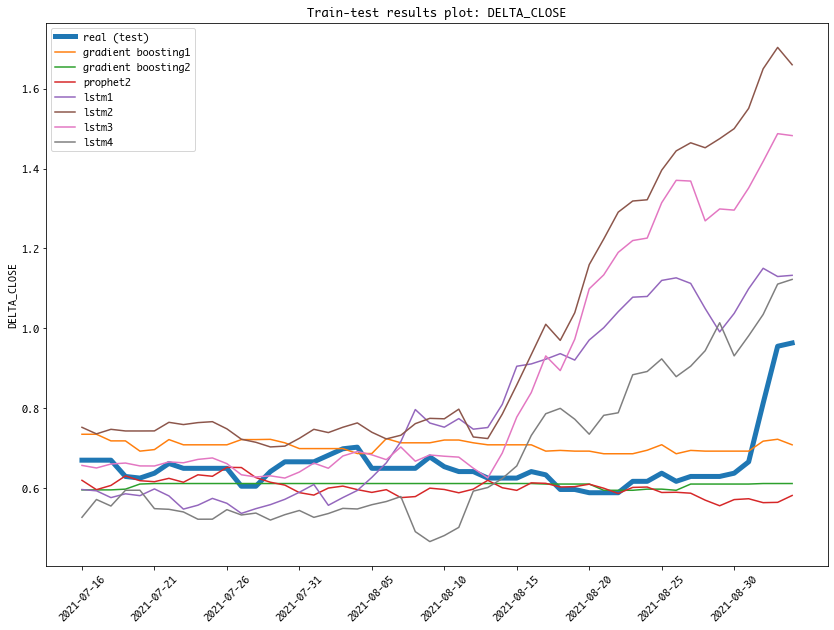

In [911]:
# Set the index of prophet to be the same as others
# df_pred_prophet.index = df_pred_linreg.index

# Plot results to visualise output
plt.figure(figsize=(14,10))
sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='real (test)', linewidth = 5)
sns.lineplot(data=df_pred_grad_bst1, x = df_pred_grad_bst1.index, y='pred', label='gradient boosting1')
sns.lineplot(data=df_pred_grad_bst2, x = df_pred_grad_bst2.index, y='pred', label='gradient boosting2')
sns.lineplot(data=df_pred_prophet2, x = df_pred_prophet2.index, y='pred', label='prophet2')
sns.lineplot(data=df_pred_lstm1, x = df_pred_lstm1.index, y='pred', label='lstm1')
sns.lineplot(data=df_pred_lstm2, x = df_pred_lstm2.index, y='pred', label='lstm2')
sns.lineplot(data=df_pred_lstm3, x = df_pred_lstm3.index, y='pred', label='lstm3')
sns.lineplot(data=df_pred_lstm4, x = df_pred_lstm4.index, y='pred', label='lstm4')

plt.xticks(np.arange(0, test_size, step=5),rotation=45)
plt.title('Train-test results plot: ' + stock_symbol_close)
plt.show()

In [912]:
# Find the average of the predicted results and then test for RMSE
df_ensem_1 = (df_pred_grad_bst1 + df_pred_grad_bst2 + df_pred_prophet2)/3
print(mean_squared_error(df_ensem_1['pred'],df_test_y[stock_symbol_close], squared=False))

0.07496081717250935


In [913]:
# Find the average of the predicted results and then test for RMSE
df_ensem_2 = (df_pred_grad_bst1 + df_pred_prophet2)/2
print(mean_squared_error(df_ensem_2['pred'],df_test_y[stock_symbol_close], squared=False))

0.07440703693674522


In [914]:
# Find the average of the predicted results and then test for RMSE
df_ensem_3 = (df_pred_grad_bst1 + df_pred_prophet2 + df_pred_lstm1)/3
print(mean_squared_error(df_ensem_3['pred'],df_test_y[stock_symbol_close], squared=False))

0.09778509515292355


In [915]:
# Find the average of the predicted results and then test for RMSE
df_ensem_4 = (df_pred_lstm1 + df_pred_lstm2)/2
print(mean_squared_error(df_ensem_4['pred'],df_test_y[stock_symbol_close], squared=False))

0.3395605824359055


In [916]:
# Find the average of the predicted results and then test for RMSE
df_ensem_5 = (df_pred_lstm1 + df_pred_lstm2 + df_pred_lstm3)/3
print(mean_squared_error(df_ensem_5['pred'],df_test_y[stock_symbol_close], squared=False))

0.34395981094894673


In [917]:
# Find the average of the predicted results and then test for RMSE
df_ensem_5 = (df_pred_grad_bst1 + df_pred_grad_bst2 + df_pred_prophet2 + df_pred_lstm1)/4
print(mean_squared_error(df_ensem_5['pred'],df_test_y[stock_symbol_close], squared=False))

0.08097717990564801


In [918]:
# Find the average of the predicted results and then test for RMSE
df_ensem_6 = (df_pred_grad_bst1 + df_pred_grad_bst2 + df_pred_prophet2 + df_pred_lstm1 + df_pred_lstm3)/5
print(mean_squared_error(df_ensem_6['pred'],df_test_y[stock_symbol_close], squared=False))

0.11907116942189616


In [919]:
# Find the average of the predicted results and then test for RMSE
df_ensem_7 = (df_pred_grad_bst2 + df_pred_prophet2 + df_pred_lstm2)/3
print(mean_squared_error(df_ensem_7['pred'],df_test_y[stock_symbol_close], squared=False))

0.12475008129257076


In [920]:
# Find the average of the predicted results and then test for RMSE
df_ensem_8 = (df_pred_lstm1 + df_pred_lstm2 + df_pred_prophet2)/3
print(mean_squared_error(df_ensem_8['pred'],df_test_y[stock_symbol_close], squared=False))

0.2124209697496714


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


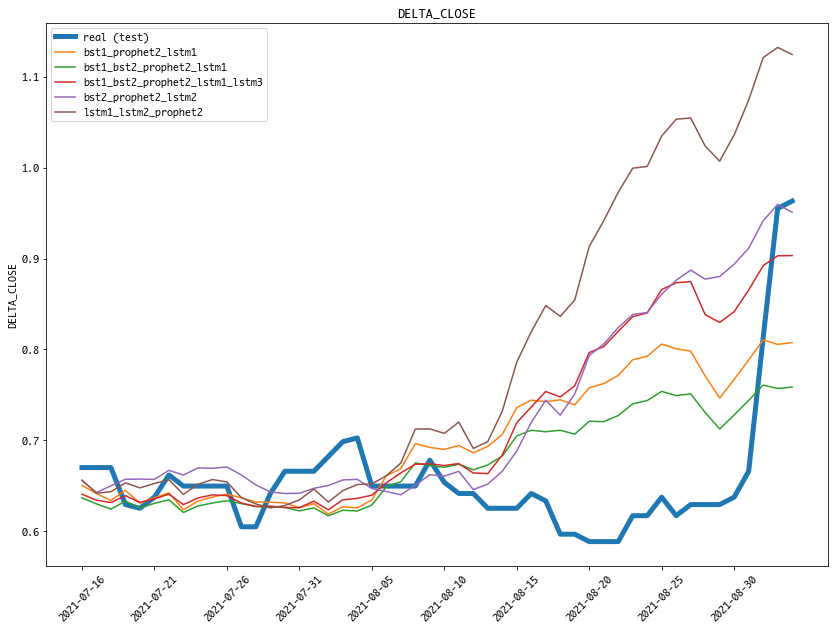

In [921]:
# Plot results to visualise output
plt.figure(figsize=(14,10))
sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='real (test)', linewidth = 5)
sns.lineplot(data=df_ensem_3, x = df_ensem_3.index, y='pred', label='bst1_prophet2_lstm1')
sns.lineplot(data=df_ensem_5, x = df_ensem_5.index, y='pred', label='bst1_bst2_prophet2_lstm1')
sns.lineplot(data=df_ensem_6, x = df_ensem_6.index, y='pred', label='bst1_bst2_prophet2_lstm1_lstm3')
sns.lineplot(data=df_ensem_7, x = df_ensem_7.index, y='pred', label='bst2_prophet2_lstm2')
sns.lineplot(data=df_ensem_8, x = df_ensem_8.index, y='pred', label='lstm1_lstm2_prophet2')
plt.xticks(np.arange(0, test_size, step=5),rotation=45)
plt.title(stock_symbol_close)
plt.show()

## Conclude model performance
In conclusion, we have found out that since RMSE is not the best factor to use for determining performance due to spikes in the stock prices, from our testing, the final optimisation is through RMSE and visualisation.

The output that we finalise is through using the ensemble model optimisation by averaging thee outputs. 
The algorithm that we have chosen to combine, with equal weights, is:
- Gradient boosting 1
- Gradient boosting 2
- Facebook prophet 2
- LSTM 1

This shows that it is prone to changes in the data and spikes.
This might not be the perfect solution but it would account for changes in prediction as stock pricing has other factors that has not been included in this project's scope.

In [927]:
def plot_final_model_train_test(stock_all_data, stock_symbol_close = 'DELTA_CLOSE', data_index = 3):

    # Set the stock symbol based on stock all data
    stock_symbol_close = stock_symbol_close
    train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data, train_size = 200, test_size = 50)
    train_x, train_y, test_x, test_y, df_test_y = clean_train_test_data(train_test1,stock_symbol = stock_symbol_close, data_index = data_index)

    ########## Gradient boosting regressor ##########
    # Gradient boosting regressor training and testing
    grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
    grad_bst_regr1.fit(train_x, train_y)
    pred_grad_bst1 = grad_bst_regr1.predict(test_x)
    df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})
    rmse_grad_bst1 = mean_squared_error(df_pred_grad_bst1['pred'],df_test_y[stock_symbol_close], squared=False)
    print('RMSE gradient boosting:',rmse_grad_bst1)

    gradient_params = {'learning_rate':[0.05,0.1,0.2],'max_depth':[5,10,15],'n_estimators':[50,100,200,500],'min_samples_leaf':[1,2,5]}
    grad_bst_regr2 = GradientBoostingRegressor(random_state=0,criterion='mse', learning_rate=0.05, max_depth=5, n_estimators=50)
    grad_bst_regr2.fit(train_x,train_y)
    pred_grad_bst2 = grad_bst_regr2.predict(test_x)
    df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})
    rmse_grad_bst2 = mean_squared_error(df_pred_grad_bst2['pred'],df_test_y[stock_symbol_close], squared=False)
    print('RMSE gradient boosting:',rmse_grad_bst2)

    ########## Facebook prophet ##########
    # Update dataset to match Facebook prophet usage protocol
    temp_prophet_df = pd.concat([train_y.rename('y'),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})

    model_prophet2 = Prophet()
    for col in temp_prophet_df.columns:
        if col not in ('y','ds'):
            model_prophet2.add_regressor(col)
    model_prophet2.fit(temp_prophet_df)
    future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
    for col in temp_prophet_df.columns:
        if col not in ('y','ds'):
            df_aggresor = pd.concat([train_x[col], test_x[col]]).reset_index().drop('index',axis=1)
            future2 = pd.concat([future2, df_aggresor],axis=1)
    forecast_prophet2 = model_prophet2.predict(future2)
    model_prophet2.plot(forecast_prophet2)
    model_prophet2.plot_components(forecast_prophet2)
    df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat'][-test_size:]).rename(columns={0:'pred'})
    rmse_prophet2 = mean_squared_error(df_pred_prophet2['yhat'],df_test_y[stock_symbol_close], squared=False)
    print('RMSE Facebook Prophet:',rmse_prophet2)

    # Update prophet data for index
    df_pred_prophet2.rename(columns={'yhat' : 'pred'},inplace=True)
    df_pred_prophet2 = df_pred_prophet2.reset_index().drop('index',axis=1)
    df_pred_prophet2.head()

    model_lstm1 = Sequential()
    model_lstm1.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
    model_lstm1.add(Dense(1))
    model_lstm1.compile(optimizer='adam', loss='mse')
    model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
    pred_lstm1 = model_lstm1.predict(test_x2)
    pred_lstm1 = pred_lstm1.reshape(-1)
    df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})
    rmse_lstm1 = mean_squared_error(df_pred_lstm1['pred'],df_test_y[stock_symbol_close], squared=False)

    # Find the average of the predicted results and then test for RMSE
    df_ensem_5 = (df_pred_grad_bst1 + df_pred_grad_bst2 + df_pred_prophet2 + df_pred_lstm1)/4
    print(mean_squared_error(df_ensem_5['pred'],df_test_y[stock_symbol_close], squared=False))

    # Plot results to visualise output
    plt.figure(figsize=(14,10))
    sns.lineplot(data=df_test_y, x = df_test_y.index, y=stock_symbol_close, label='real (test)', linewidth = 5)
    sns.lineplot(data=df_ensem_5, x = df_ensem_5.index, y='pred', label='bst1_bst2_prophet2_lstm1')
    plt.xticks(np.arange(0, test_size, step=5),rotation=45)
    plt.title(stock_symbol_close)
    plt.show()

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 0.08453468756558967
RMSE gradient boosting: 0.08534313363613176
Initial log joint probability = -9.85683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       347.086   3.28534e-07       91.8434       1.859      0.1859      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       347.086   7.10059e-09       90.9602      0.2781      0.2781      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 0.09837448716207757
Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.3430
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1406
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0637
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0386
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0329
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0307
0.06122977995613058


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


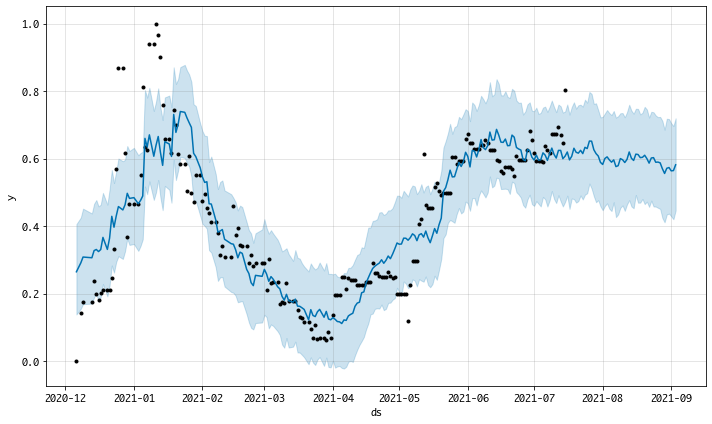

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


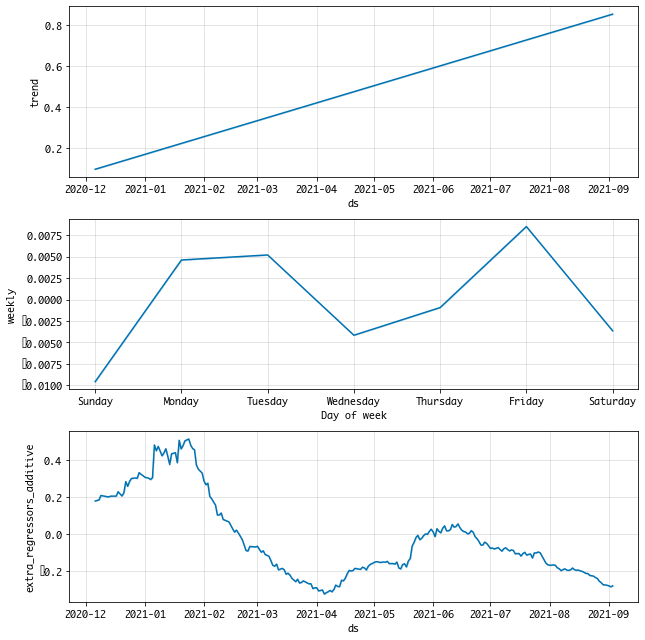

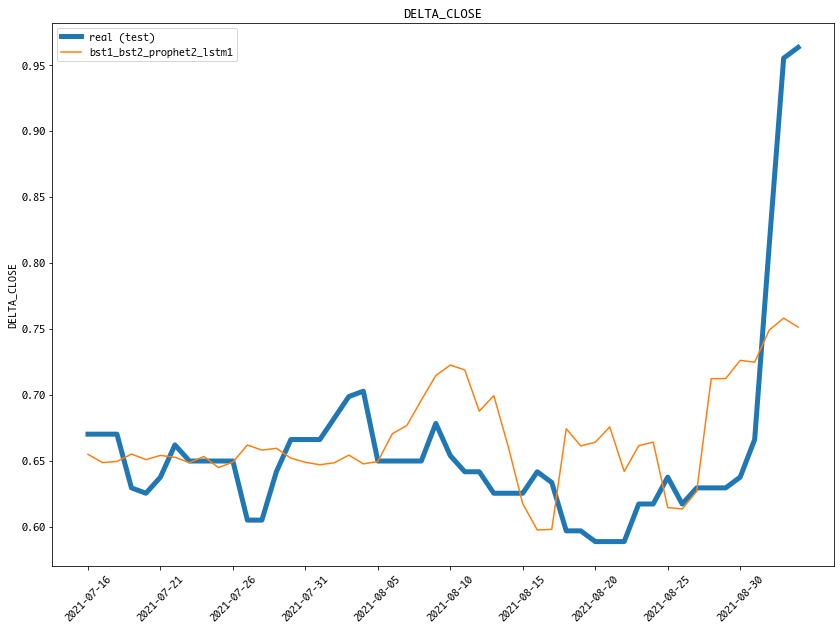

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 0.12559655392217606
RMSE gradient boosting: 0.1829876764154518
Initial log joint probability = -2.87754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       479.445    0.00308476       120.842      0.2575           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       480.494    0.00120639       122.295   1.212e-05       0.001      192  LS failed, Hessian reset 
     199       480.844   6.81726e-05       88.1409      0.8734      0.8734      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       481.048   0.000313569       82.0679       1.724      0.5086      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       481.055   3.07265e-05       97.7722   3.347e-07       0.001      436  LS failed, Hessian reset 
     399       481.12

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 0.6048573643985645
Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2366
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1238
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0603
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0092
0.11873576445266784


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


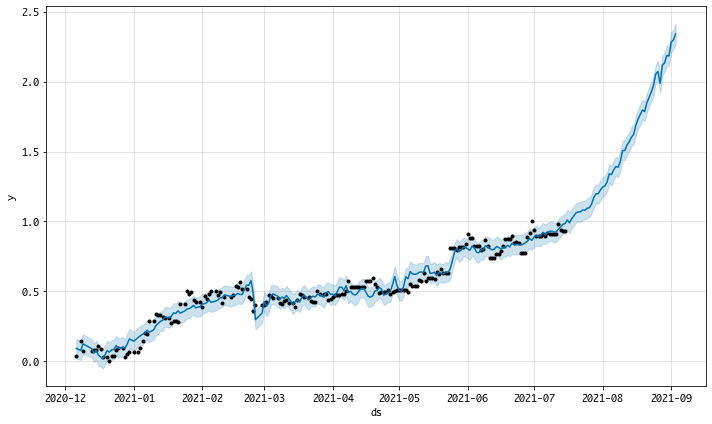

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


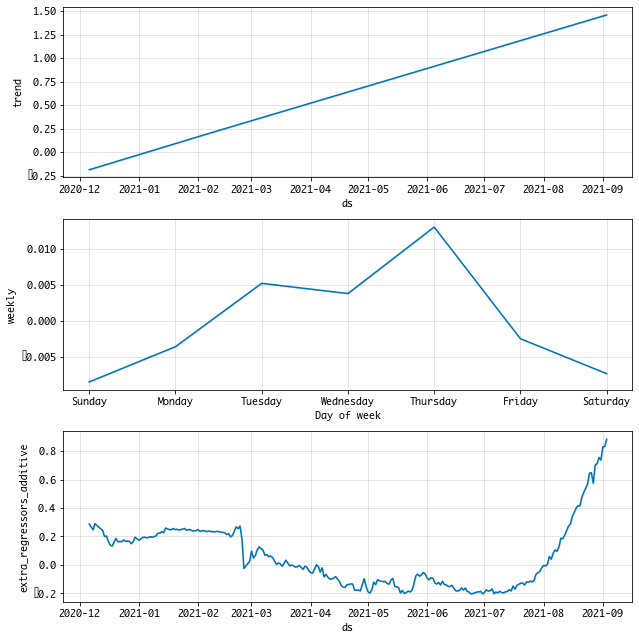

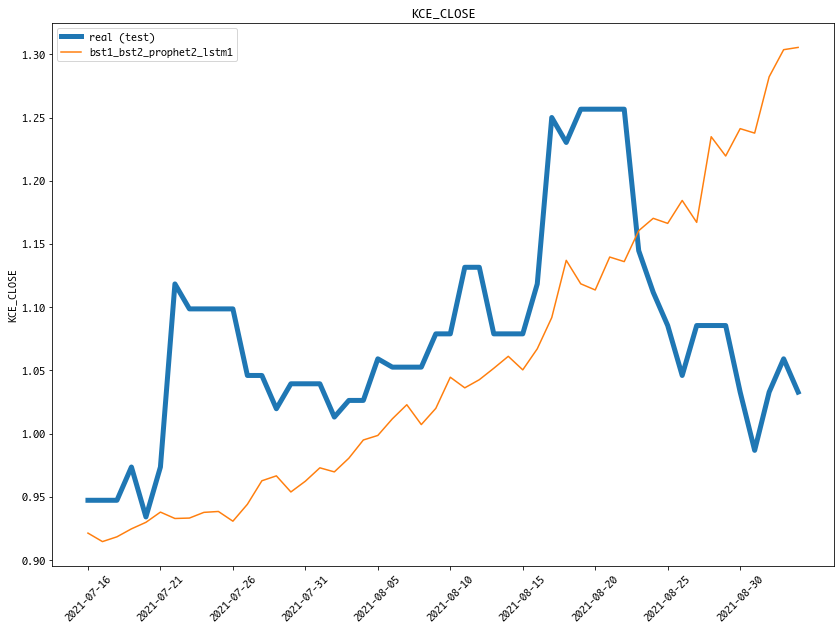

0it [00:00, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 0.15536111440443032
RMSE gradient boosting: 0.18403693880879413
Initial log joint probability = -16.7941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.328    0.00625371       62.7096      0.6913      0.6913      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       381.269   3.98475e-05       58.6009   9.989e-07       0.001      293  LS failed, Hessian reset 
     199       381.271   2.39156e-05       47.1207      0.3081           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288        381.32   4.03769e-05       50.8415   7.583e-07       0.001      476  LS failed, Hessian reset 
     299       381.321   4.99207e-06        43.593       0.678      0.2171      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       381.3

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 0.08522251108466518
Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.0914
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0638
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0362
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0274
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0112
0.11036987788631976


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


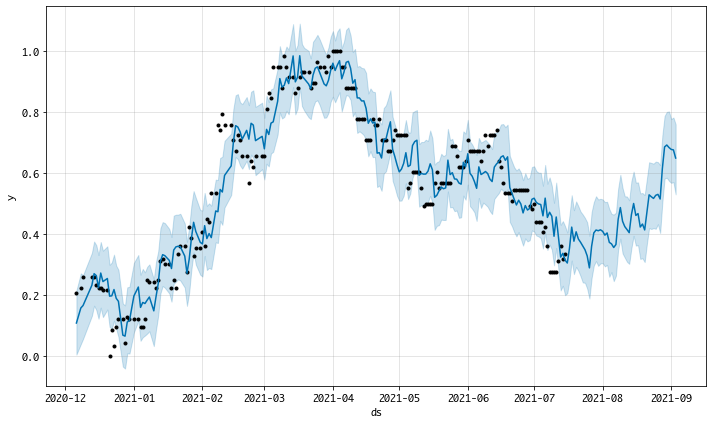

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


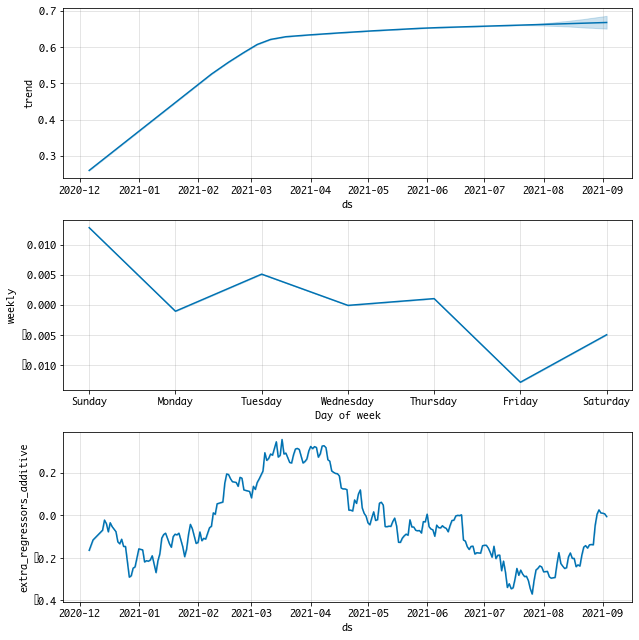

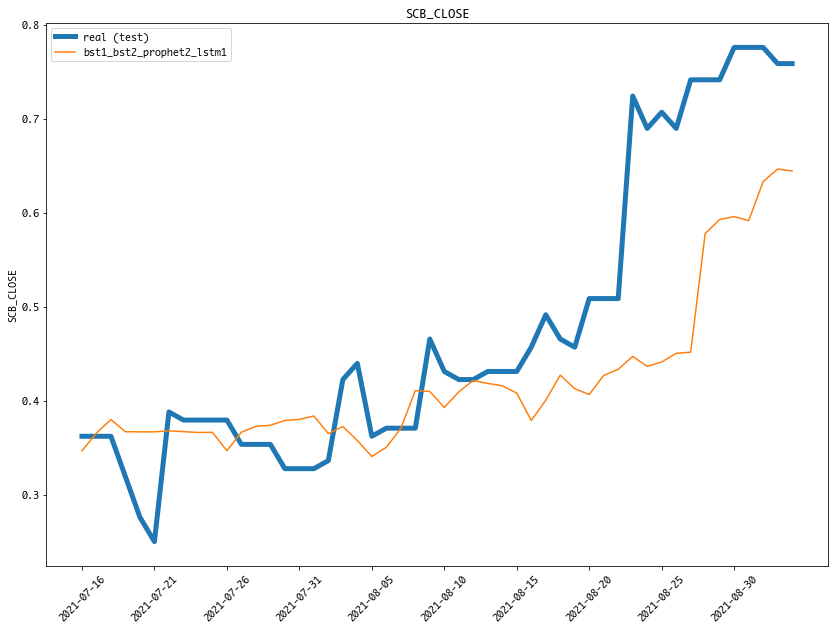

0it [00:00, ?it/s]

The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.
The x values include a column with constant values and so the test statistic cannot be computed.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE gradient boosting: 1.133652106918551
RMSE gradient boosting: 1.0918655854011485
Initial log joint probability = -6.21193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       380.954     0.0141568        195.87           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       386.455    0.00232968       96.5137        0.73        0.73      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       389.966     0.0010666       81.2012           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       391.593    0.00135321       132.428      0.8746      0.8746      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       392.495   0.000400233       81.2875      0.3515    

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


RMSE Facebook Prophet: 0.7769959980309322
Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.4007
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.3426
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.2547
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1419
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0760
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0486
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0275
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0165
0.7919434350442067


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


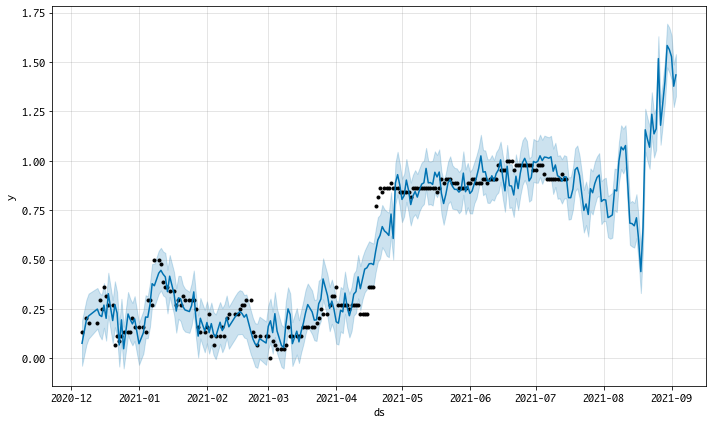

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


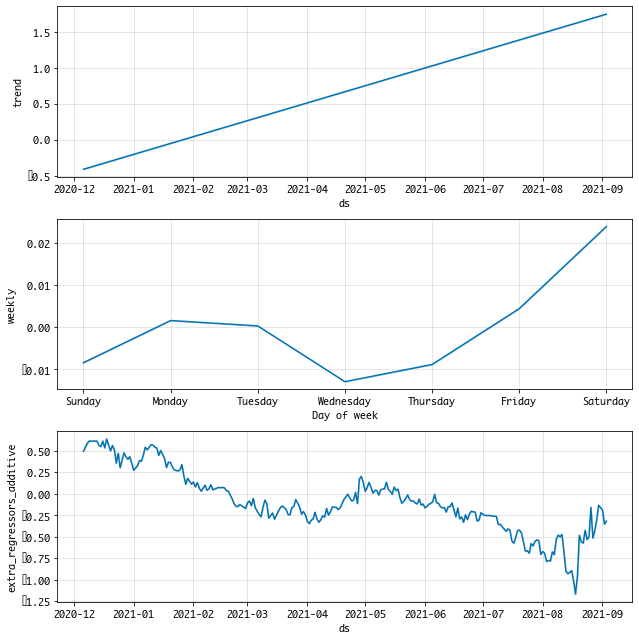

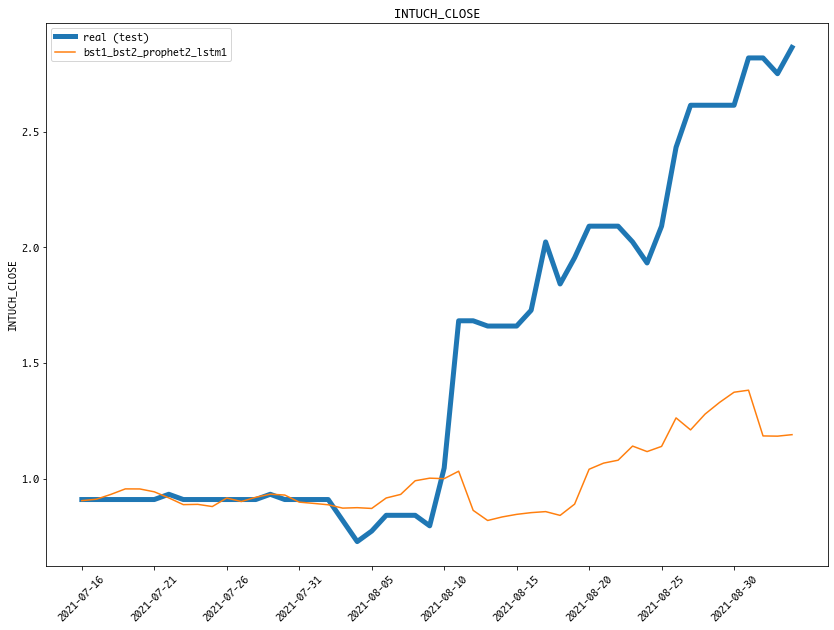

In [929]:
plot_final_model_train_test(stock_all_data1,'DELTA_CLOSE')
plot_final_model_train_test(stock_all_data2,'KCE_CLOSE')
plot_final_model_train_test(stock_all_data3,'SCB_CLOSE')
plot_final_model_train_test(stock_all_data4,'INTUCH_CLOSE')

## Predict and descale it back to normal for the price prediction
Here, we are going to do the quick prediction based on the data that we have for future prices.
Note, this is not going to be fully accurate as the number of features that we can use varies and does not consider external factors in play.

In [611]:
train_pred1[2]

[8,
             DELTA_ma30  DELTA_ema30  DELTA_ema10  TEAM_rsi14  DELTA_ema50
 2021-02-05  542.800000   517.076928   546.270964   58.951131   452.552280
 2021-02-06  548.866667   517.781642   542.948970   58.951131   455.511014
 2021-02-08  548.866667   517.781642   542.948970   58.951131   455.511014
 2021-02-09  553.333333   515.989278   533.321885   48.225071   456.863524
 2021-02-10  557.966667   514.957712   527.263360   48.225071   458.555150
 ...                ...          ...          ...         ...          ...
 2021-08-30  577.066667   568.016270   563.069492   57.725873   556.107701
 2021-08-31  576.933333   567.499092   562.511402   58.090880   556.260340
 2021-09-01  576.933333   567.015279   562.054784   64.099616   556.406994
 2021-09-02  576.333333   567.207842   563.499369   70.438984   556.940053
 2021-09-03  575.066667   566.742820   562.863120   69.124471   557.060051
 
 [200 rows x 5 columns],
             DELTA_ma30  DELTA_ema30  DELTA_ema10  TEAM_rsi14  DELTA_

In [940]:
def clean_train_pred_data(train_pred, stock_symbol = 'DELTA_CLOSE', data_index = 2):
    '''
    Function to clean the train and pred data that was prepared before modelling.
    Only difference here is that there is no test_y data.
    
    Input:
    - train_pred dataframe from create_train_test_predict_split_with_granger
    
    Output:
    - train_x, train_y, test_x = Data for modelling usage
    - scaler = to rescale back to original for getting price values
    
    '''
    
    # Define the data point that we want to use (which lag value data)
    data_point = data_index

    # Define the stock symbol column name with _CLOSE
    stock_symbol_close = stock_symbol
    
    # Define the train and test datasets
    train_x = train_pred[data_point][1]
    test_x = train_pred[data_point][2]
    train_y = train_pred[data_point][3]

    # Scale all the features so that it is in the same scale for testing
    df_transformed1, scaler0 = min_max_scaler_transform(pd.concat([train_x,train_y],axis=1))
    
    # Min max scale the data
    train_x, scaler1 = min_max_scaler_transform(train_x)
    train_y, scaler2 = min_max_scaler_transform(pd.DataFrame(train_y))

    # Scale the test results using the same scaler as above
    temp_scale_test = pd.DataFrame(scaler1.transform(test_x))
    
    test_x.index = train_pred[data_point][2].index
    
    return train_x, train_y, test_x, scaler2

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.4238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83        373.84    0.00462938       202.372   2.518e-05       0.001      138  LS failed, Hessian reset 
      99       375.141   0.000557818       64.3346       0.217           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       375.431    0.00138161       98.5041   1.592e-05       0.001      222  LS failed, Hessian reset 
     199       375.544   1.06467e-06       84.8247           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       381.838    0.00182935       88.6417           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       382.065   0.000200593        74.214   2.825e-06       0.001      541  LS failed, Hessian rese

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.0567
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0141
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0111
stock: DELTA_CLOSE
data_index: 0
features_used: (200, 1)
lag value in train_test 10
[0.58826859 0.58826859 0.58826859 0.58826859 0.58826859 0.58826859
 0.58826859 0.58826859 0.58826859 0.58826859]
         pred
0  558.248297
1  5

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.4238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.437    0.00022939       59.9171       0.697       0.697      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       449.382   3.26712e-05       60.6026   4.354e-07       0.001      298  LS failed, Hessian reset 
     199       449.385   5.93822e-05       81.1683           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       449.755   0.000664621       90.7572      0.3459           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       449.773   7.05714e-05       98.1397   8.693e-07       0.001      481  LS failed, Hessian reset 
     387       449.793   5.18504e-06        97.968   5.708e-08       0.001      617  LS failed, Hessian rese

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.1593
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0270
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0105
stock: DELTA_CLOSE
data_index: 1
features_used: (200, 3)
lag value in train_test 9
[0.57852014 0.57852014 0.57852014 0.57852014 0.57852014 0.57852014
 0.57852014 0.57852014 0.57852014]
         pred
0  550.565800
1  549.434983
2 

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3758
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        457.14    0.00172206       176.392   1.167e-05       0.001      151  LS failed, Hessian reset 
      99        458.81    0.00066439       62.6211      0.5319      0.5319      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       460.741    0.00198766       196.229   2.052e-05       0.001      279  LS failed, Hessian reset 
     199       461.357   2.30905e-05       59.2734           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       461.372   9.74156e-05       79.4105   1.259e-06       0.001      401  LS failed, Hessian reset 
     299       461.385    8.9143e-06       61.9356      0.6332           1      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2877
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1179
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0548
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0360
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0164
stock: DELTA_CLOSE
data_index: 2
features_used: (200, 5)
lag value in train_test 8
[0.71023734 0.71023734 0.71023734 0.71023734 0.71023734 0.71023734
 0.71023734 0.71023734]
         pred
0  602.913606
1  603.334796
2  601.437121

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.0344
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        442.42   0.000885006       82.1799      0.5655      0.5655      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        444.34   6.77901e-05       84.7974      0.3784           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       444.596   0.000416977       108.368   5.077e-06       0.001      325  LS failed, Hessian reset 
     276       444.644   7.91399e-06       83.3177   8.445e-08       0.001      411  LS failed, Hessian reset 
     299       444.644   1.84544e-07       73.3971           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       444.644    2.1171e-08       68.6572      0.4761           1      450   
Optimization terminat

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.2565
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1343
Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0687
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0346
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0095
stock: DELTA_CLOSE
data_index: 3
features_used: (200, 6)
lag value in train_test 7
[0.67979966 0.67979966 0.67979966 0.67979966 0.67979966 0.67979966
 0.67979966]
         pred
0  606.704101
1  606.297515
2  610.271407
3  613.673

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.772     0.0027885       104.132           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       460.153   1.27644e-06       87.2972       0.434           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       460.153   1.20522e-08       62.7713     0.06068           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.1724
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0682
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0308
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 10/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0087
stock: DELTA_CLOSE
data_index: 4
features_used: (200, 7)
lag value in train_test 6
[0.84303505 0.84303505 0.84303505 0.84303505 0.84303505 0.84303505]
         pred
0  631.110638
1  627.291094
2  630.941747
3  627.629815
4  628.7

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       468.419    0.00961293       80.2574           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       472.148   0.000412903       81.6414      0.5866      0.5866      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       472.281   1.73066e-05       88.8369      0.3582           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334        472.55   0.000655694       114.167   6.562e-06       0.001      451  LS failed, Hessian reset 
     399       472.653   4.22669e-07       81.8589           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       472.653   4.18219e-08    

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.2778
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.1235
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0107
stock: DELTA_CLOSE
data_index: 5
features_used: (200, 8)
lag value in train_test 5
[0.88542177 0.88542177 0.88542177 0.88542177 0.88542177]
         pred
0  634.354352
1  637.672037
2  633.614341
3  637.184149
4  637.093899


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.804   1.04311e-06       89.3099      0.3524           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       489.465    0.00330465       113.937           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       492.703   1.88706e-05       89.4736      0.5835      0.5835      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       492.707   1.10095e-08        89.826       0.309           1      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.3009
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1386
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0864
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0436
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0129
stock: DELTA_CLOSE
data_index: 6
features_used: (200, 13)
lag value in train_test 4
[0.88374459 0.88374459 0.88374459 0.88374459]
         pred
0  649.108685
1  645.735228
2  649.613776
3  650.586030


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        521.98    0.00130365       129.035      0.2814           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.761    0.00652732       174.312           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       535.753     0.0305446        451.66           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       538.558   3.50944e-05       108.416      0.5919      0.5919      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     434       538.567   1.93561e-08       98.5447           1           1      491   
Optimization terminated normally: 
  Convergence detected: relat

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.1215
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0234
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 7/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 8/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0110
stock: DELTA_CLOSE
data_index: 7
features_used: (200, 28)
lag value in train_test 3
[0.87517586 0.87517586 0.87517586]
         pred
0  645.931841
1  647.654478
2  646.002130


/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Initial log joint probability = -11.3389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       539.802     0.0111319       212.519      0.5512      0.5512      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       548.942     0.0216629        228.97           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       556.506    0.00494639       146.043           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        561.11    0.00354161       202.396      0.6873      0.6873      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       564.787    0.00535023       123.103       0.764       0.764      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Epoch 1/10
7/7 [==============================] - 1s 1ms/step - loss: 0.0744
Epoch 2/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0174
Epoch 3/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 4/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0131
Epoch 5/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 6/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 8/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 9/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 10/10
7/7 [==============================] - 0s 1ms/step - loss: 0.0065
stock: DELTA_CLOSE
data_index: 8
features_used: (200, 36)
lag value in train_test 2
[0.88205677 0.88205677]
         pred
0  633.165185
1  626.456674


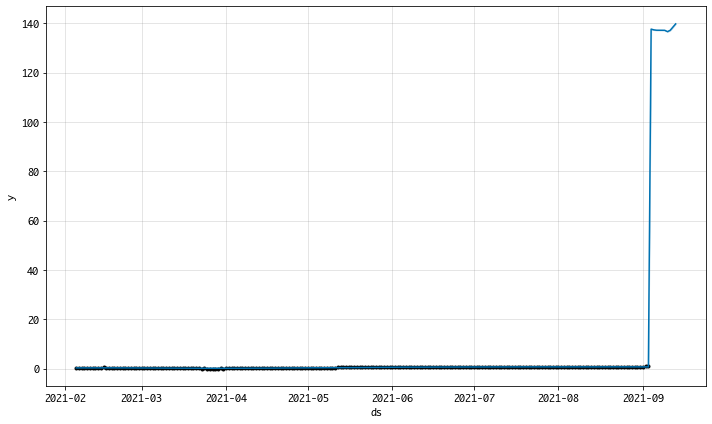

/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/pongsakorn/Documents/UdacityDS_course/proj_capstone/venv_proj_capstone_ds_pete/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


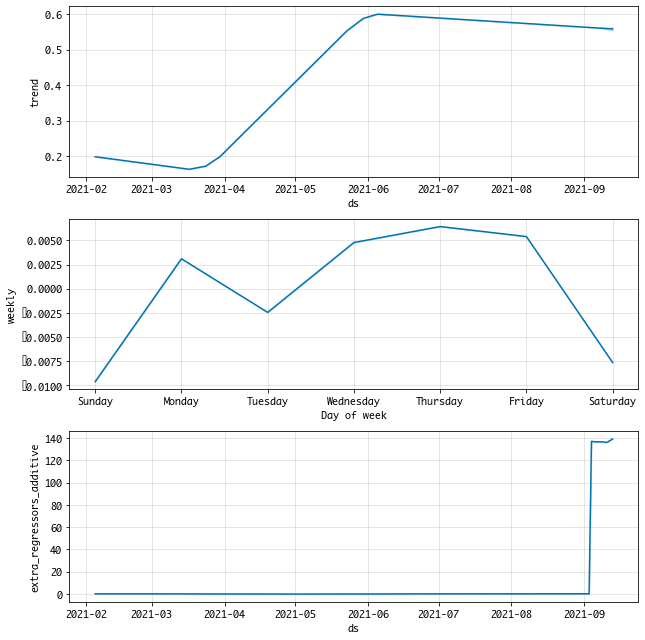

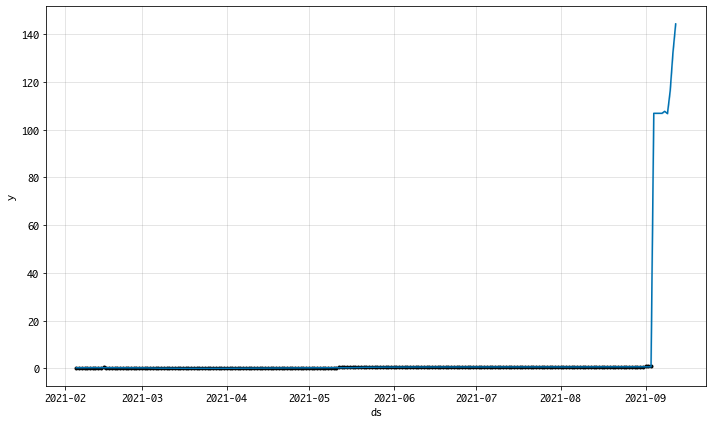

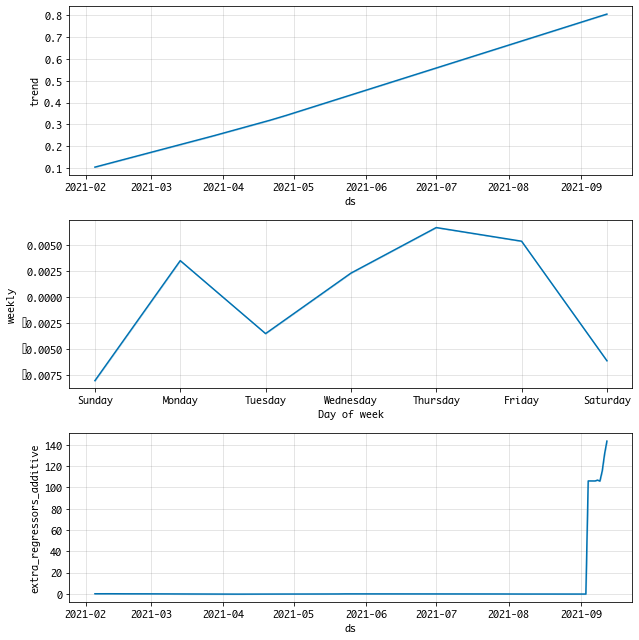

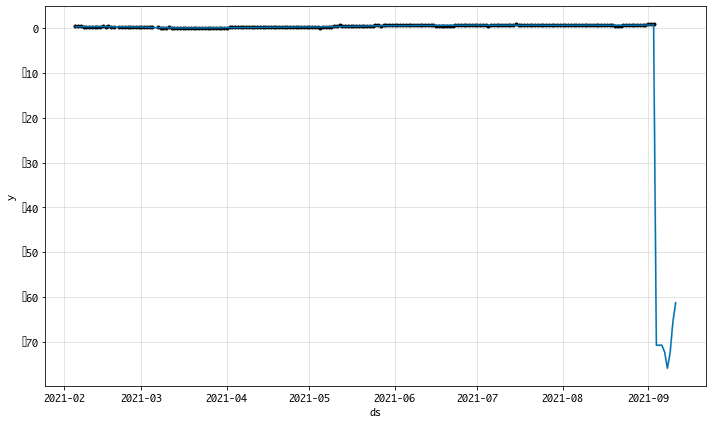

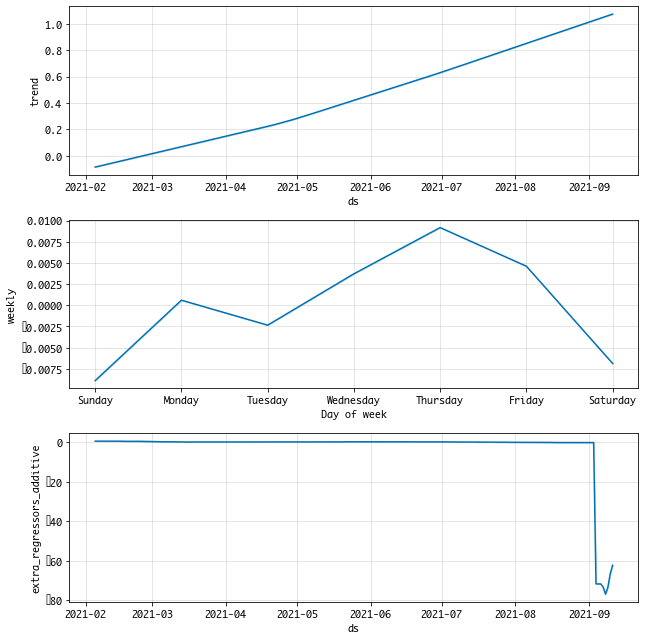

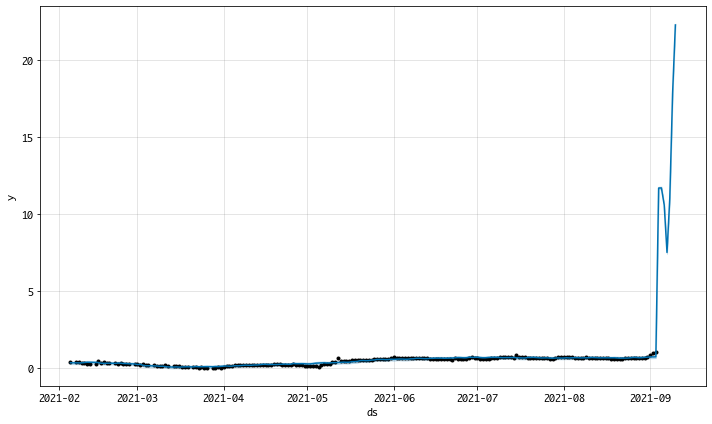

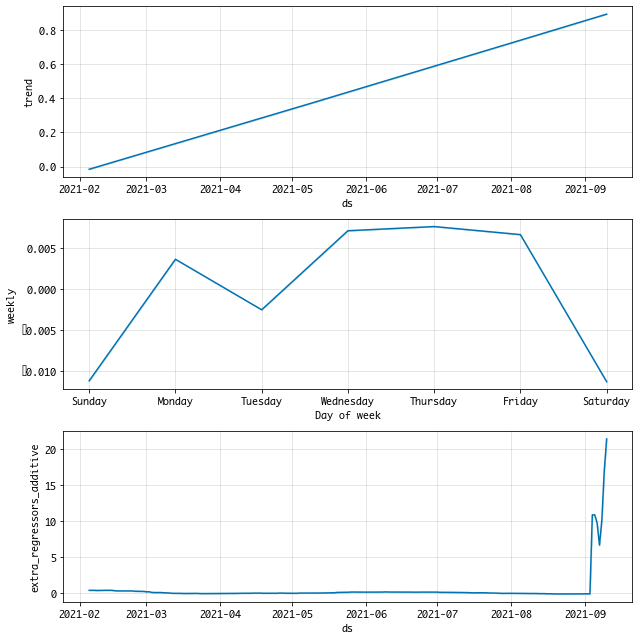

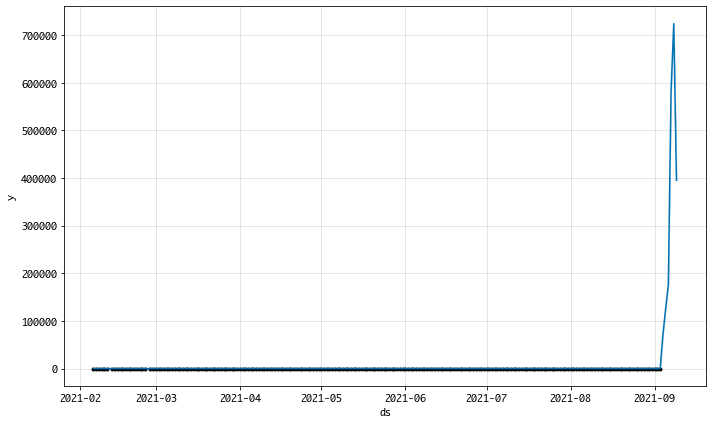

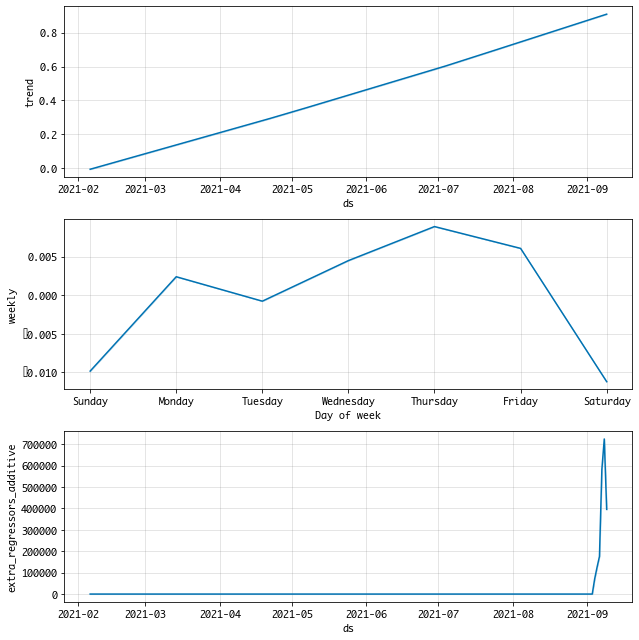

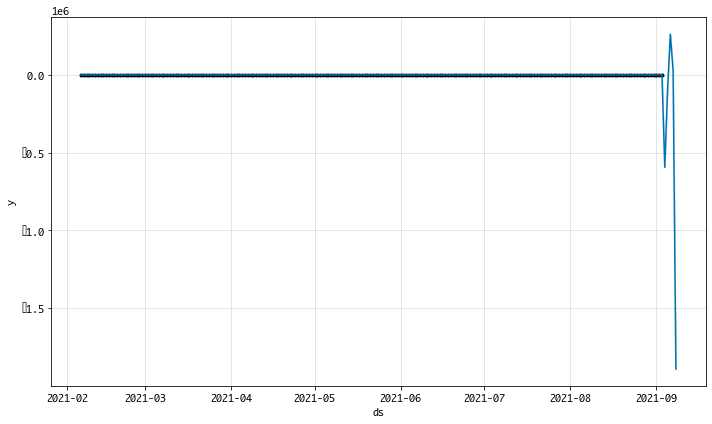

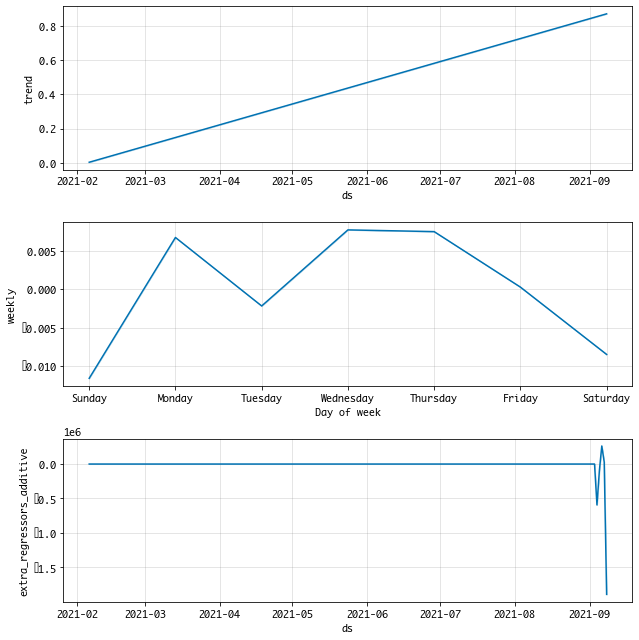

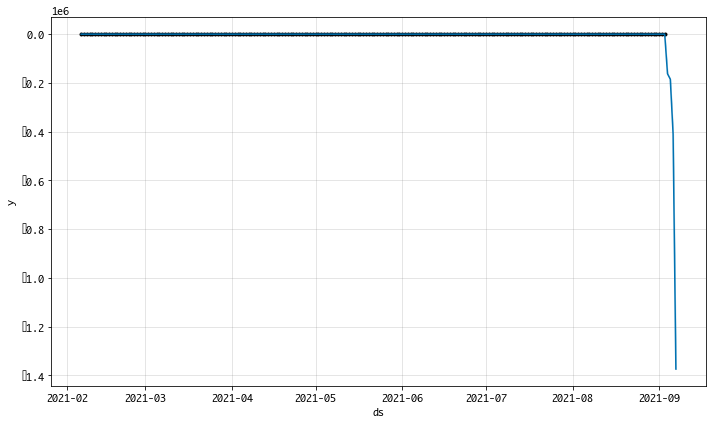

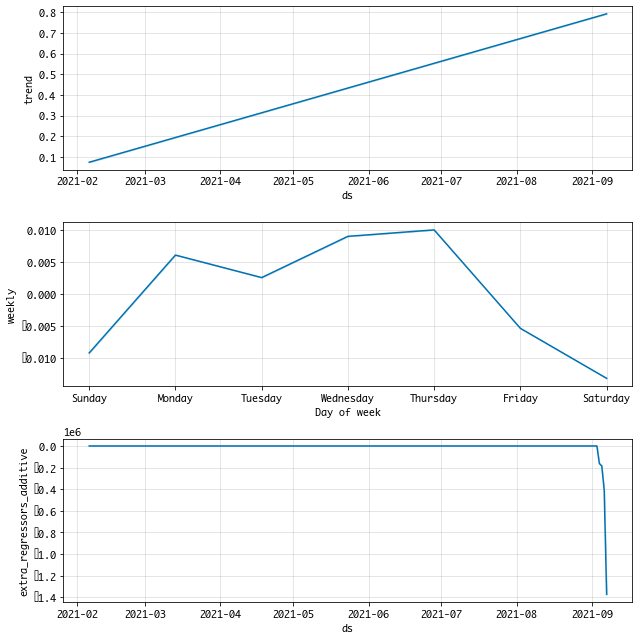

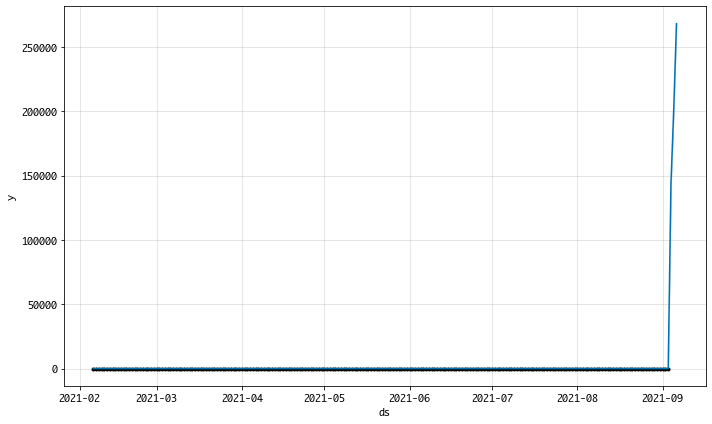

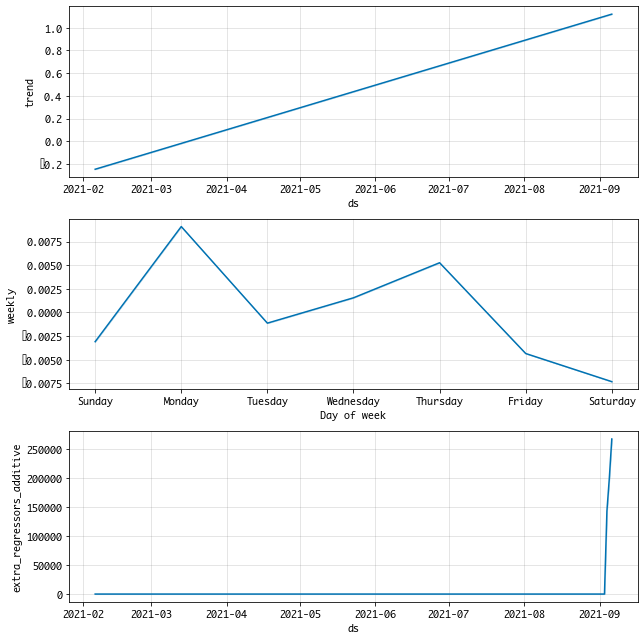

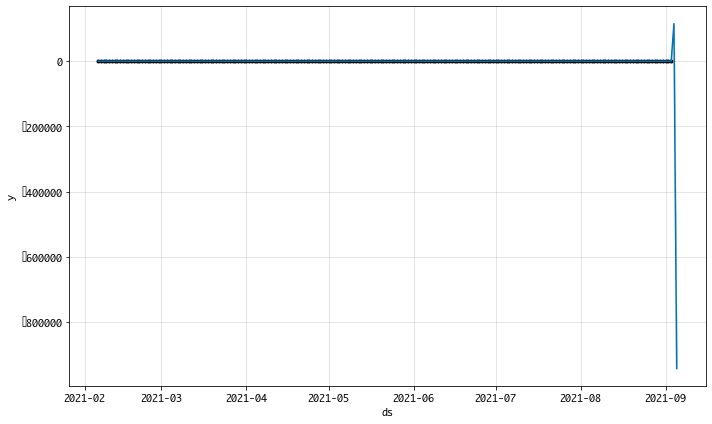

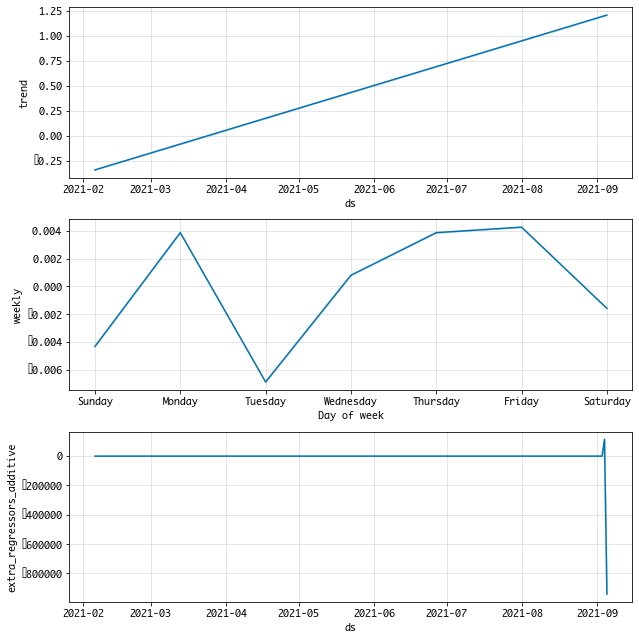

In [1022]:
pred_value_list = []

# Create the train test split with the new train_size
train_test1, train_pred1 = create_train_test_predict_split_with_granger(stock_all_data1, train_size = 200, test_size = 50)

stock_symbol_close = 'DELTA_CLOSE'

for data_index in tqdm(range(0,len(train_pred1))):
    # Create the train test data output
    train_x, train_y, test_x, scaler = clean_train_pred_data(train_pred1,stock_symbol_close, data_index = data_index)
    
    # Gradient boosting with specified parameters
    grad_bst_regr2 = GradientBoostingRegressor(random_state=0,criterion='mse',learning_rate=0.05,max_depth=5)
    grad_bst_regr2.fit(train_x,train_y)
    pred_grad_bst2 = grad_bst_regr2.predict(test_x)
    df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})

    
    ########## Gradient boosting regressor ##########
    grad_bst_regr1 = GradientBoostingRegressor(random_state=0)
    grad_bst_regr1.fit(train_x, train_y)
    pred_grad_bst1 = grad_bst_regr1.predict(test_x)
    df_pred_grad_bst1 = pd.DataFrame(pred_grad_bst1).rename(columns={0:'pred'})

    grad_bst_regr2 = GradientBoostingRegressor(random_state=0,criterion='mse', learning_rate=0.05, max_depth=5, n_estimators=50)
    grad_bst_regr2.fit(train_x,train_y)
    pred_grad_bst2 = grad_bst_regr2.predict(test_x)
    df_pred_grad_bst2 = pd.DataFrame(pred_grad_bst2).rename(columns={0:'pred'})

    ########## Facebook prophet ##########
    # Update dataset to match Facebook prophet usage protocol
    train_y.index = pd.to_datetime(train_y.index)
    temp_prophet_df = pd.concat([train_y.rename(columns={stock_symbol_close: 'y'}),train_x],axis=1).reset_index().rename(columns={'index': 'ds'})
    temp_prophet_df = temp_prophet_df.bfill()
    model_prophet2 = Prophet()
    for col in temp_prophet_df.columns:
        if col not in ('y','ds'):
            model_prophet2.add_regressor(col)

    # temp_prophet_df
    model_prophet2.fit(temp_prophet_df)
    future2 = model_prophet2.make_future_dataframe(periods=len(test_x))
    for col in temp_prophet_df.columns:
        if col not in ('y','ds'):
            df_aggresor = pd.concat([train_x[col] , test_x[col]]).reset_index().rename(columns={'index':'ds'})
            future2 = future2.merge(df_aggresor,how='left',on='ds').bfill()
    forecast_prophet2 = model_prophet2.predict(future2)
    model_prophet2.plot(forecast_prophet2)
    model_prophet2.plot_components(forecast_prophet2)
    df_pred_prophet2 = pd.DataFrame(forecast_prophet2['yhat'][-test_size:]).rename(columns={0:'pred'})

    # # Update prophet data for index
    df_pred_prophet2.rename(columns={'yhat' : 'pred'},inplace=True)
    df_pred_prophet2 = df_pred_prophet2.reset_index().drop('index',axis=1)
    df_pred_prophet2.head()

    model_lstm1 = Sequential()
    model_lstm1.add(LSTM(10, activation='relu', input_shape=(train_x2.shape[1], train_x2.shape[2]), return_sequences=True))
    model_lstm1.add(Dense(1))
    model_lstm1.compile(optimizer='adam', loss='mse')
    model_lstm1.fit(train_x2,train_y,epochs=10,batch_size=30)
    pred_lstm1 = model_lstm1.predict(test_x2)
    pred_lstm1 = pred_lstm1.reshape(-1)
    df_pred_lstm1 = pd.DataFrame(pred_lstm1).rename(columns={0:'pred'})

    # Find the average of the predicted results and then test for RMSE
    df_ensem_5 = (df_pred_grad_bst1 + df_pred_grad_bst2 +  df_pred_lstm1)/3
    
    pred_value = min_max_scaler_inverse_transform(df_ensem_5, scaler)
    
    print('stock:',stock_symbol_close)
    print('data_index:',data_index)
    print('features_used:',train_x.shape)
    print('lag value in train_test',train_test[data_index][0])
    print(pred_grad_bst2)
    print(pred_value.dropna())
    
    # lag_value (days ahead), predicted values, features used
    pred_value_list.append([train_test[data_index][0],pred_value.dropna(), train_x.shape[1]])
    

In [1025]:
pred_value_list

[[10,
           pred
  0  558.248297
  1  562.749182
  2  555.272654
  3  558.454256
  4  559.385033
  5  560.277716
  6  557.355149
  7  556.183216
  8  556.365920
  9  552.139808,
  1],
 [9,
           pred
  0  550.565800
  1  549.434983
  2  547.972136
  3  545.468178
  4  545.180128
  5  545.709492
  6  544.063256
  7  543.440718
  8  543.585423,
  3],
 [8,
           pred
  0  602.913606
  1  603.334796
  2  601.437121
  3  604.268736
  4  606.088235
  5  607.191241
  6  614.170827
  7  613.925386,
  5],
 [7,
           pred
  0  606.704101
  1  606.297515
  2  610.271407
  3  613.673755
  4  613.384687
  5  610.421144
  6  613.135592,
  6],
 [6,
           pred
  0  631.110638
  1  627.291094
  2  630.941747
  3  627.629815
  4  628.760764
  5  631.804659,
  7],
 [5,
           pred
  0  634.354352
  1  637.672037
  2  633.614341
  3  637.184149
  4  637.093899,
  8],
 [4,
           pred
  0  649.108685
  1  645.735228
  2  649.613776
  3  650.586030,
  13],
 [3,
           pr

## Shows prediction results
Finally, we plot to show the basic results and outputs from the prediction.
As shown, this is plotted for one of the stocks that have been tested (DELTA).
The plot shows that the longer the length of the line, there is more lag, therefore, we are able to predict for a longer period but the tradeoff to this is the number of features used to predict.

Thee result shows varying details but optimally, we would choose the results in the middle as it has a fair number of features used and may not be overfit in some ways.


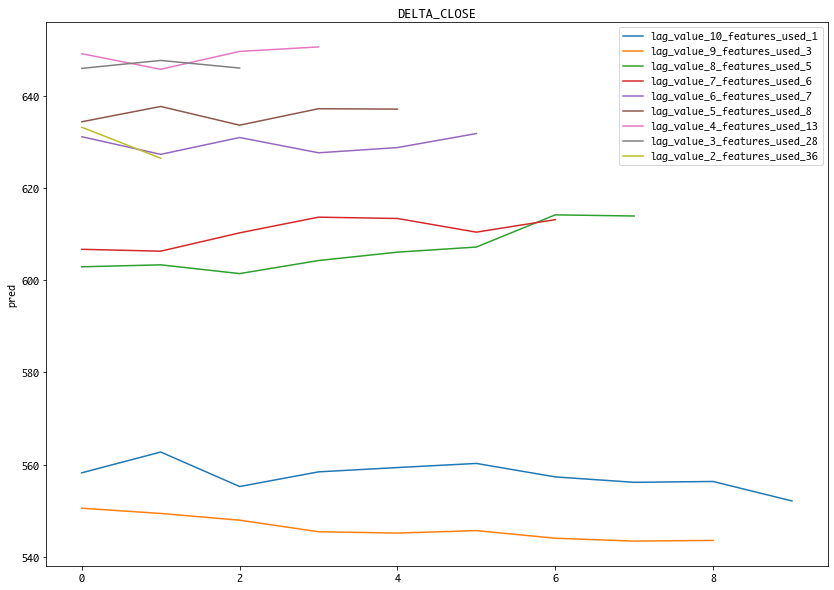

In [1024]:
# Plot results to visualise output
plt.figure(figsize=(14,10))
for lag_data, pred_data, features_used in pred_value_list:
    sns.lineplot(data=pred_data, x = pred_data.index, y='pred', label='lag_value_' + str(lag_data) + '_features_used_' + str(features_used))

plt.title(stock_symbol_close)
plt.show()